# Human-AI Synergy in Adaptive Active Learning for Continuous Lithium Carbonate Crystallization Optimization

**Shayan Mousavi Masouleh¹²*, Corey A. Sanz³, Ryan P. Jansonius³, Cara Cronin³, Jason E. Hein³, Jason Hattrick-Simpers¹***

¹ CanmetMATERIALS, Natural Resources Canada, Hamilton, ON, Canada  
² Clean Energy Innovation, National Research Council of Canada, Mississauga, ON, Canada  
³ Telescope Innovations, Vancouver, BC, Canada

---

## Notebook Overview

This Jupyter Notebook serves as supplementary material for the research paper, *"Human-AI Synergy in Adaptive Active Learning for Continuous Lithium Carbonate Crystallization Optimization."* It provides the executable code to reproduce the analyses, visualizations, and key findings presented in the publication.

The primary goal of our research is to demonstrate a Human-in-the-Loop Active Learning (HITL-AL) framework that optimizes the continuous crystallization of lithium carbonate ($Li_2CO_3$) from low-grade brines. This is particularly relevant for resources like the Smackover Formation, which are rich in lithium but also contain high levels of impurities such as magnesium (Mg), calcium (Ca), and potassium (K).

This notebook is structured to follow the narrative of the paper, guiding the user through the following key sections:

1. **Setup and Configuration**: Loading necessary libraries, defining utility functions, and configuring the computational environment for reproducible research.

2. **Auxiliary Functions**: Core data processing, surrogate space generation, statistical analysis, and optimization functions that implement the HITL-AL workflow described in the **Methods** section of the paper.

3. **Data Loading and Preparation**: Loading and cleaning the experimental dataset from multiple SIFT experimental campaigns, including progressive data loading to simulate the active learning timeline.

4. **Data and Results Inspection**: Comprehensive statistical analysis of the experimental data to understand relationships between input parameters and outcomes, including feature importance analysis and correlation studies.

5. **Exploration Phase (Pareto Frontier Analysis)**: Demonstrating how Gaussian Process Regression (GPR) and the NSGA-II algorithm were used to explore the parameter space and identify conditions that minimize Mg and Ca impurities simultaneously.

6. **The Human-in-the-Loop Insight (Random Walk Analysis)**: Showcasing the pivotal discovery where a model-guided random walk revealed the counterintuitive but critical role of the cold reactor temperature ($T_{cold}$) in magnesium removal.

7. **Exploitation Phase (Decision Boundary Refinement)**: Detailing how Gaussian Process Classification (GPC) was used to precisely map the decision boundary between battery-grade and non-battery-grade outcomes, including ray tracing for optimal experiment selection.

8. **Final Results and Analysis**: Presenting the final model performance, key parameter distributions, and comprehensive comparative analysis that underscores the efficiency of the HITL-AL approach.

9. **Comparative Simulation**: Quantifying the benefits of the HITL-AL approach through computational experiments comparing its efficacy against Bayesian optimization and random sampling in both informed and uninformed scenarios.

By providing this interactive and reproducible material, we aim to offer a transparent and in-depth view of our methodology and results, facilitating further research and application in the field of materials science and chemical process optimization.

## 0. Setup: Libraries and Configuration

### 0.1. Importing Libraries

This cell imports all the necessary Python libraries for data manipulation, scientific computing, machine learning, and visualization. We configure the notebook to display plots inline and set a consistent random seed for reproducibility.

In [1]:
# Jupyter notebook configuration
%matplotlib inline

# Standard library imports
import datetime
import math
import platform
import random
import warnings
import pickle

# Third-party scientific computing
import numpy as np
import pandas as pd
import scipy
from scipy.stats import qmc, zscore
from math import ceil

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Machine learning and optimization
import optuna
import shap
import sklearn
from sklearn import (
    ensemble, gaussian_process, linear_model, neighbors, preprocessing, svm, tree
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import (
    ConstantKernel, DotProduct, Matern, RationalQuadratic, RBF, WhiteKernel
)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import (
    f1_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error,
    mean_squared_error, pairwise, r2_score
)
from sklearn.model_selection import (
    GridSearchCV, ShuffleSplit, cross_val_score, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix

# Multi-objective optimization
import platypus
from platypus import NSGAII, Problem, Real, nondominated


# Progress tracking
from tqdm import tqdm
import tqdm

# =============================================================================
# CONFIGURATION
# =============================================================================

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set matplotlib style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

from io import StringIO, BytesIO
from typing import Any, Iterable, Optional, Union
import csv
import os

### 0.2. Library Versions

To ensure full reproducibility, we document the versions of the key libraries used in this analysis.

In [2]:
# Printing versions of the loaded modules
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scipy version: {scipy.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Tqdm version: {tqdm.__version__}")
print(f"Platypus-Opt version: {platypus.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"SHAP version: {shap.__version__}")
print(f"Notebook executed on: {datetime.datetime.now()}")

Python version: 3.9.23
NumPy version: 1.24.3
Pandas version: 2.0.3
Scipy version: 1.11.1
Matplotlib version: 3.7.2
Seaborn version: 0.12.2
Scikit-learn version: 1.3.0
Tqdm version: 4.65.0
Platypus-Opt version: 1.0.4
Optuna version: 3.2.0
SHAP version: 0.42.1
Notebook executed on: 2025-08-23 00:34:20.936326


## 1. Auxiliary Functions

This section contains the definitions of helper functions used throughout the notebook. These functions are categorized based on their role in the HITL-AL workflow described in the **Methods** section of the paper.

### 1.1 Data Extraction and Preparation

In [3]:
def sift_data_extractor(data, ppm=True, pH=False, slurry=False, score=False, NaOH=False):
    """Extract and standardize experimental data from raw SIFT files."""
    new_data = pd.DataFrame()
    if 'Experiment ID' in data.columns:
        new_data['experiment_id'] = data['Experiment ID']
    if 'Successful Experiment' in data.columns:
        new_data['success'] = data['Successful Experiment']
    else:
        new_data['success'] = 'T'
    if score:
        if 'Success score' in data.columns:
            new_data['score'] = data['Success score']
        else:
            new_data['score'] = 1
    if 'T cold (deg C)' in data.columns:
        new_data['T_cold'] = data['T cold (deg C)'].astype(float)
    if 'T hot (deg C)' in data.columns:
        new_data['T_hot'] = data['T hot (deg C)'].astype(float)
    if 'flow rate (mL/min)' in data.columns:
        new_data['flow_rate'] = data['flow rate (mL/min)'].astype(float)
    if 'slurry concentration (g total solid/100 mL)' in data.columns:
        new_data['slurry_concentration'] = data['slurry concentration (g total solid/100 mL)'].astype(float)
    if pH and 'pH of slurry (initial)' in data.columns:
        new_data['pH'] = data['pH of slurry (initial)'].astype(float)
    if NaOH and 'millimoles NaOH added' in data.columns:
        new_data['NaOH'] = data['millimoles NaOH added'].astype(float)
    if slurry:
        slurry_components = {
            'slurry concentration (g CaCO3/100 mL)': 'scl_Ca',
            'slurry concentration (g K2CO3/100 mL)': 'scl_K',
            'slurry concentration (g Li2CO3/100 mL)': 'scl_Li',
            'slurry concentration (g (Mg(CO3))4 Mg(OH)2/100 mL)': 'scl_Mg',
            'slurry concentration (g Na2CO3/100 mL)': 'scl_Na',
            'slurry concentration (g SrCO3/100 mL)': 'scl_Sr'
        }
        for column, new_column_name in slurry_components.items():
            if column in data.columns:
                new_data[new_column_name] = data[column].astype(float)
    if ppm:
        ppm_components = {
            'B (ppm)': 'init_B', 'Ca (ppm)': 'init_Ca', 'K (ppm)': 'init_K',
            'Li (ppm)': 'init_Li', 'Mg (ppm)': 'init_Mg', 'Na (ppm)': 'init_Na',
            'Si (ppm)': 'init_Si', 'Sr (ppm)': 'init_Sr', 'Li2CO3 purity (%)': 'init_Li_purity',
            'B (ppm).1': 'fini_B', 'Ca (ppm).1': 'fini_Ca', 'K (ppm).1': 'fini_K',
            'Li (ppm).1': 'fini_Li', 'Mg (ppm).1': 'fini_Mg', 'Na (ppm).1': 'fini_Na',
            'Si (ppm).1': 'fini_Si', 'Sr (ppm).1': 'fini_Sr', 'Li2CO3 purity (%).1': 'fini_Li_purity'
        }
        for column, new_column_name in ppm_components.items():
            if column in data.columns:
                new_data[new_column_name] = data[column].astype(float)
    else:
        percentage_components = {
            'B (%)': 'init_B', 'Ca (%)': 'init_Ca', 'K (%)': 'init_K', 'Li (%)': 'init_Li',
            'Mg (%)': 'init_Mg', 'Na (%)': 'init_Na', 'Si (%)': 'init_Si', 'Sr (%)': 'init_Sr',
            'B (%).1': 'fini_B', 'Ca (%).1': 'fini_Ca', 'K (%).1': 'fini_K', 'Li (%).1': 'fini_Li',
            'Mg (%).1': 'fini_Mg', 'Na (%).1': 'fini_Na', 'Si (%).1': 'fini_Si', 'Sr (%).1': 'fini_Sr'
        }
        for column, new_column_name in percentage_components.items():
            if column in data.columns:
                new_data[new_column_name] = data[column].astype(float)
    return new_data

def successful_sift_extraction(data):
    """Filter SIFT experimental data to include only successful experiments."""
    new_data = data[data['success'].isin(['T'])].copy()
    return new_data

def ppm_threshold(element):
    """This function returns the battery-grade threshold for each element in ppm."""
    fini_threshold ={
        'fini_Ca': 160,
        'fini_K': 10,
        'fini_Mg': 80,
        'fini_Na': 500,
        'fini_Si': 40
    }
    return fini_threshold.get(element)

### 1.2 Surrogate Space Generation

As described in **Section 2.2.3 (Informed Design and Adjustments)** of the paper, we construct a surrogate space to represent the multidimensional experimental conditions. We use Latin Hypercube Sampling (LHS) for its efficient and uniform coverage of the parameter space.

In [4]:
def latin_hypercube_sample(n_points, dimension, lower_bounds, upper_bounds, seed=None):
    """Generate Latin Hypercube samples for experimental design."""
    sampler = qmc.LatinHypercube(d=dimension, seed=seed, optimization='random-cd')
    sample = sampler.random(n=n_points)
    scaled_sample = qmc.scale(sample, lower_bounds, upper_bounds)
    return scaled_sample

def uniform_random_sample(n_points, dimension, lower_bounds, upper_bounds, seed=None):
    """Generate uniform random samples for experimental design."""
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(n_points, dimension))
    return samples

def sift_lhs_sample(n_points, bounds=None, lhs_sampler=True, seed=None, delta_T=0):
    """
    Generate a validated experimental design for SIFT experiments using LHS or uniform sampling.
    This function enforces physical constraints such as T_hot > T_cold and normalizes
    initial concentrations to realistic values.
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    if bounds is None:
        bounds = {
            "T_cold": (10, 90), "T_hot": (20, 95), "flow_rate": (0.5, 6),
            "slurry_concentration": (1.5, 10), "init_Ca": (1000, 300000),
            "init_K": (300, 3000), "init_Li": (15000, 300000),
            "init_Mg": (10, 20000), "init_Na": (300, 20000)
        }

    l_bounds = [v[0] for v in bounds.values()]
    u_bounds = [v[1] for v in bounds.values()]
    columns = list(bounds.keys())
    initial_n_points = int(4 * n_points + 50) if lhs_sampler else int(4 * n_points + 10)

    if lhs_sampler:
        sample = latin_hypercube_sample(initial_n_points, len(bounds), l_bounds, u_bounds, seed=seed)
    else:
        sample = uniform_random_sample(initial_n_points, len(bounds), l_bounds, u_bounds, seed=seed)

    exp_grid = pd.DataFrame(sample, columns=columns)
    mask = exp_grid['T_cold'] > exp_grid['T_hot']
    exp_grid.loc[mask, ['T_cold', 'T_hot']] = exp_grid.loc[mask, ['T_hot', 'T_cold']].values

    scaling_factors = {'init_Ca': 0.404, 'init_K': 0.5655, 'init_Li': 0.1878, 'init_Mg': 0.5094, 'init_Na': 0.4338}
    init_sum = sum(exp_grid[col] / scaling_factors.get(col, 1) for col in scaling_factors)
    for col in scaling_factors:
        if col in exp_grid.columns:
             exp_grid[col] = 1_000_000 * exp_grid[col] / init_sum

    for parameter, (lower_bound, upper_bound) in bounds.items():
        exp_grid = exp_grid[exp_grid[parameter].between(lower_bound, upper_bound)]

    exp_grid['T_hot'] += delta_T
    exp_grid_final = exp_grid.sample(frac=1, random_state=seed).reset_index(drop=True).head(n_points)
    return exp_grid_final

### 1.3 Statistical and ML Model Analysis

These functions implement the analyses described in **Section 2.2.1 (Data and Results Inspection)** of the paper. They include tools for hyperparameter tuning, model training, SHAP analysis, and other statistical evaluations used to provide insights for the "Human Interpretation" phase.

In [5]:
def tune_hyperparameters(X, y, n_trials=25):
    """Optimize RandomForestRegressor hyperparameters using Optuna."""
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'random_state': 42
        }
        model = RandomForestRegressor(**param)
        score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
        return -score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def train_model(X, y, best_params):
    """Train a RandomForestRegressor model with specified parameters."""
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X, y)
    return model

def shap_feature_importance(model, X):
    """Create a SHAP feature importance plot."""
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    plt.figure(figsize=(6, 4))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.xlabel("mean |SHAP value| (average impact on model output magnitude)")
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

def plot_data_analysis(data, pair_plot=False):
    """Create pair plots and a correlation matrix heatmap for the given data."""
    if pair_plot:
        sns.pairplot(data)
        plt.show()
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Pearson Correlation Matrix")
    plt.tight_layout()
    plt.show()

def plot_partial_dependence(model, X):
    """Generate and display partial dependence plots for each feature."""
    features = X.columns
    n_cols = 3
    n_rows = ceil(len(features) / n_cols)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
    fig.suptitle('Partial Dependence Plots', fontsize=16)
    for i, feature in enumerate(features):
        ax = axs.flat[i]
        PartialDependenceDisplay.from_estimator(model, X, features=[feature], ax=ax, grid_resolution=20)
        ax.set_title(feature)
    for ax in axs.flat[len(features):]:
        ax.set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_mutual_information(X, y):
    """Calculate and display a mutual information plot for features."""
    mutual_info = mutual_info_regression(X, y, random_state=42)
    mi_series = pd.Series(mutual_info, index=X.columns).sort_values()
    plt.figure(figsize=(6, 4))
    mi_series.plot(kind='barh', color='blue')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Mutual Information)')
    plt.tight_layout()
    plt.show()

def sensitivity_analysis(model, X, y, feature_names):
    """Perform and plot a normalized sensitivity analysis."""
    importances = {}
    baseline_mse = mean_squared_error(y, model.predict(X))
    for feature in feature_names:
        X_perturbed = X.copy()
        X_perturbed[feature] += X_perturbed[feature].std()
        mse_perturbed = mean_squared_error(y, model.predict(X_perturbed))
        change_in_mse = abs(mse_perturbed - baseline_mse)
        normalized_change = change_in_mse / baseline_mse if baseline_mse != 0 else 0
        importances[feature] = normalized_change
    sorted_importances = pd.Series(importances).sort_values()
    plt.figure(figsize=(6, 4))
    sorted_importances.plot(kind='barh', color='purple')
    plt.xlabel('Normalized Change in MSE')
    plt.ylabel('Features')
    plt.title('Normalized Sensitivity Analysis')
    plt.tight_layout()
    plt.show()
    return importances

def perform_full_analysis(data, feature_columns, target_columns, pair_plot=False):
    """Conduct a full statistical analysis pipeline for a given target."""
    for target in target_columns:
        print(f"\n--- Analyzing for Target: {target} ---")
        y = data[target]
        X = data[feature_columns]
        print("Tuning hyperparameters...")
        best_params = tune_hyperparameters(X, y)
        print(f"Best parameters found: {best_params}")
        print("Training model...")
        model = train_model(X, y, best_params)
        print("Generating Data Analysis Plots:")
        plot_data_analysis(data[feature_columns + [target]], pair_plot=pair_plot)
        print("Generating Partial Dependence Plots:")
        plot_partial_dependence(model, X)
        print("Generating SHAP Feature Importance Plot:")
        shap_feature_importance(model, X)
        print("Generating Mutual Information Plot:")
        plot_mutual_information(X, y)
        print("Performing Sensitivity Analysis:")
        sensitivity_analysis(model, X, y, feature_columns)

def find_missing_data(data):
    """Print a summary of missing data per column."""
    missing_data = data.isna().sum()
    if missing_data.sum() > 0:
        print("Missing data counts per column:\n", missing_data[missing_data > 0])
        for column in data.columns[data.isna().any()].tolist():
            print(f"\nNaNs in column '{column}':")
            print(data[data[column].isna()])
    else:
        print("No missing data found.")

### 1.4. Pareto Extraction

In [6]:
from platypus import NSGAII, Problem, Real, nondominated
import pandas as pd
from typing import Tuple

def optimize_pareto_front(
    grid_gpr: pd.DataFrame,
    obj1_col: str = "fini_Mg",
    obj2_col: str = "fini_Ca",
    min_unique_points: int = 30,
    population_size: int = 500,
    generations: int = 10000
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Perform NSGA-II optimization to extract a Pareto front from `grid_gpr`
    based on the specified objective columns.

    Args:
        grid_gpr (pd.DataFrame): DataFrame containing the surrogate predictions.
        obj1_col (str): Column name for the first objective.
        obj2_col (str): Column name for the second objective.
        min_unique_points (int): Minimum number of unique Pareto points to collect.
        population_size (int): Size of the NSGA-II population.
        generations (int): Number of generations to run per optimization cycle.

    Returns:
        pareto_front_unique (pd.DataFrame): Unique Pareto-optimized rows with only objective columns.
        grid_gpr_unique (pd.DataFrame): Full unique rows of `grid_gpr` for the Pareto-optimized indices.
    """
    
    def objective(x):
        idx = [int(i) for i in x]
        f1 = grid_gpr.loc[idx, obj1_col].values
        f2 = grid_gpr.loc[idx, obj2_col].values
        return [f1[0], f2[0]]

    # Define the problem
    problem = Problem(1, 2)
    problem.types[:] = Real(0, grid_gpr.shape[0] - 1)
    problem.function = objective

    # Prepare the dataframe with renamed objective columns
    df = grid_gpr[[obj1_col, obj2_col]].rename(columns={obj1_col: 'obj1', obj2_col: 'obj2'})

    pareto_front_unique = pd.DataFrame()
    pareto_indices_unique = set()
    algorithm = NSGAII(problem, population_size=population_size)

    while len(pareto_front_unique) < min_unique_points:
        algorithm.run(generations)

        front = nondominated(algorithm.result)
        pareto_indices = [int(solution.variables[0]) for solution in front]

        pareto_indices_unique.update(pareto_indices)
        pareto_front = df.iloc[pareto_indices]
        pareto_front_unique = pareto_front_unique.append(pareto_front, ignore_index=False)
        pareto_front_unique = pareto_front_unique.drop_duplicates()

        if len(pareto_front_unique) < min_unique_points:
            print(f"Warning: Only {len(pareto_front_unique)} unique points found. Re-running optimization...")
            algorithm = NSGAII(problem, population_size=population_size)

    grid_gpr_unique = grid_gpr.iloc[list(pareto_indices_unique)].drop_duplicates()

    print("Unique Pareto front:")
    print(pareto_front_unique.head(min_unique_points))
    print("\nCorresponding rows from grid_gpr:")
    print(grid_gpr_unique.head(min_unique_points))

    return pareto_front_unique, grid_gpr_unique



def pareto_gpr_prediction(file_path_exp: str,
                          file_path_lhs: str,
                          multi_dimensional: bool = True,
                          delta_T: bool = True,
                          alpha: float = 1e-10):
    """
    Perform Gaussian Process Regression (GPR) to predict post-crystallization impurity concentrations
    using experimental data and a test design space (e.g., Latin Hypercube Sampling).

    Parameters:
    -----------
    file_path_exp : str
        Path to the CSV file containing observed experimental data (features + target impurities).

    file_path_lhs : str
        Path to the CSV file containing unseen design points for prediction (e.g., LHS sample).

    multi_dimensional : bool, default=True
        If True, uses a multi-output GPR model to predict all targets simultaneously.
        If False, fits one independent GPR model per target impurity.

    delta_T : bool, default=True
        If True, computes and includes the temperature difference (T_hot - T_cold) as a feature.

    alpha : float, default=1e-10
        Value of alpha used for regularization in GPR to prevent overfitting in low-noise settings.

    Returns:
    --------
    grid_gpr : pd.DataFrame
        GPR-predicted impurity concentrations for each row in the test design space (X_test).
    
    X_train : pd.DataFrame
        Final processed training feature matrix used to fit GPR.
    
    y_train : pd.DataFrame
        Training targets (impurity levels after crystallization).

    Notes:
    ------
    - This function assumes that the experimental file includes both input features and observed outputs.
    - It supports both multi-output and independent GPR strategies.
    - Features are standardized using StandardScaler to ensure stable model behavior.
    """

    # Load experimental data
    data = pd.read_csv(file_path_exp)
    print("Initial experimental data sample:")
    print(data.head(5))

    # Drop irrelevant or noisy columns, if present
    columns_to_drop = [
        'init_Li_purity', 'fini_Li_purity', 'init_B', 'init_Si', 'fini_B', 'fini_Si',
        'init_Sr', 'fini_Sr', 'scl_Ca', 'scl_K', 'scl_Li', 'scl_Mg', 'scl_Na', 'scl_Sr'
    ]
    for column in columns_to_drop:
        if column in data.columns:
            data = data.drop(column, axis=1)

    # Compute delta_T (optional)
    cleaned_data = data.copy()
    if delta_T:
        cleaned_data['delta_T'] = cleaned_data['T_hot'] - cleaned_data['T_cold']
        

    # Drop rows with missing values
    cleaned_data = cleaned_data.dropna()

    # Define input features (X) for training
    base_features = ['T_cold', 'T_hot', 'flow_rate', 'slurry_concentration',
                     'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']
    if delta_T:
        feature_cols = base_features[:2] + ['delta_T'] + base_features[2:]
    else:
        feature_cols = base_features

    X_train = cleaned_data[feature_cols].copy()
    y_train = cleaned_data[['fini_Ca', 'fini_K', 'fini_Li', 'fini_Mg', 'fini_Na']].copy()

    # Load test data and prepare features
    X_test = pd.read_csv(file_path_lhs)
    if delta_T:
        X_test['delta_T'] = X_test['T_hot'] - X_test['T_cold']
    X_test = X_test[feature_cols].copy()

    print("Processed training features sample:")
    print(X_train.head(5))

    # Standardize features for both train and test
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform GPR
    if multi_dimensional:
        # Use multi-output GPR (single model)
        gpr_model = GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5),
                                             alpha=alpha,
                                             n_restarts_optimizer=1)
        gpr_model.fit(X_train_scaled, y_train)

        y_pred, y_std = gpr_model.predict(X_test_scaled, return_std=True)
        gpr_pred_df = pd.DataFrame(y_pred, columns=y_train.columns)

        # Combine predictions with original input space
        grid_gpr = pd.concat([X_test.reset_index(drop=True), gpr_pred_df], axis=1)

    else:
        # Use one GPR model per output target
        gpr_model = {}
        grid_gpr = {}

        for target in y_train.columns:
            gpr_model[target] = GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5),
                                                         alpha=alpha,
                                                         n_restarts_optimizer=10)
            gpr_model[target].fit(X_train_scaled, y_train[target])
            y_pred = gpr_model[target].predict(X_test_scaled)
            grid_gpr[target] = y_pred

        grid_gpr = pd.DataFrame(grid_gpr)

    return grid_gpr, X_train, y_train

### 1.5. Random Walk at Pareto Frontier Execution

In [7]:
def wobble_dataframe(df, n, wobble_factor=0.25):
    """
    Generate a new dataframe by applying a random 'wobble' to each value of the first row of the input dataframe.
    
    Args:
    df (pd.DataFrame): The input dataframe from which the first row is used as a base for generation.
    n (int): The number of 'wobbled' rows to generate.
    wobble_factor (float, optional): The maximum proportion of the original value by which to randomly vary. 
        Defaults to 0.25.
    
    Returns:
    pd.DataFrame: A new dataframe containing 'n' rows where each value is a 'wobbled' version of the first row's values,
        with adjusted initial concentrations to maintain a defined sum constraint and corrected temperature values.
    """
    # Fixing the random seed for reproducibility
    np.random.seed(42)
    
    new_rows = []
    for _ in range(n):
        wobbled_row = {}
        first_row = df.iloc[0]  # Use iloc to get the first row, regardless of its index
        for column in df.columns:
            value = first_row[column]
            # Apply the wobble factor
            wobbled_value = value + (np.random.uniform(-wobble_factor, wobble_factor) * value)
            wobbled_row[column] = wobbled_value
        new_rows.append(wobbled_row)
    
    new_df = pd.DataFrame(new_rows)
    
    # Compute the sum of the scaled initial concentrations
    init_sum = new_df['init_Ca']/0.404 + new_df['init_K']/0.5655 + new_df['init_Li']/0.1878 + new_df['init_Mg']/0.5094 + new_df['init_Na']/0.4338

    new_df_norm = new_df.copy()
    # Rescale the initial concentrations to enforce the sum constraint
    new_df_norm['init_Ca'] = 1000000 * new_df['init_Ca'] / init_sum
    new_df_norm['init_K'] = 1000000 * new_df['init_K'] / init_sum
    new_df_norm['init_Li'] = 1000000 * new_df['init_Li'] / init_sum
    new_df_norm['init_Mg'] = 1000000 * new_df['init_Mg'] / init_sum
    new_df_norm['init_Na'] = 1000000 * new_df['init_Na'] / init_sum
    
    # Correct temperatures if they are in the wrong order
    swap_values = new_df_norm.loc[new_df_norm['T_cold'] > new_df_norm['T_hot'], ['T_hot', 'T_cold']].values
    new_df_norm.loc[new_df_norm['T_cold'] > new_df_norm['T_hot'], ['T_cold', 'T_hot']] = swap_values
    
    # Calculate the temperature difference
    new_df_norm['delta_T'] = new_df_norm['T_hot'] - new_df_norm['T_cold']
    
    return new_df_norm

In [8]:
# def sift_data_extractor(data, ppm=True, pH=False, slurry=False, score=False, NaOH=False):
#     """
#     Extracts and standardizes experimental data from a raw data file.

#     This function processes raw data from lithium carbonate crystallization
#     experiments, converting it into a standardized format with consistent column names
#     and data types for easier analysis.

#     Parameters:
#     - data (pd.DataFrame): Raw experimental data.
#     - ppm (bool): If True, extracts concentration data in ppm. Otherwise, in percent.
#     - pH (bool): If True, includes pH data.
#     - slurry (bool): If True, includes individual slurry component concentrations.
#     - score (bool): If True, includes expert-assigned quality scores.
#     - NaOH (bool): If True, includes NaOH addition data.

#     Returns:
#     - pd.DataFrame: A standardized dataset with consistent column names.
#     """
#     new_data = pd.DataFrame()
    
#     # Standardize column names (lowercase with underscores)
#     column_map = {col: col.strip().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_').lower() for col in data.columns}
#     data.rename(columns=column_map, inplace=True)

#     if 'experiment_id' in data.columns:
#         new_data['experiment_id'] = data['experiment_id']
#     if 'successful_experiment' in data.columns:
#         new_data['success'] = data['successful_experiment']
#     else:
#         new_data['success'] = 'T'

#     if score:
#         if 'success_score' in data.columns:
#             new_data['score'] = data['success_score']
#         else:
#             new_data['score'] = 1
            
#     # Mapping for process parameters
#     param_map = {
#         't_cold_deg_c': 'T_cold',
#         't_hot_deg_c': 'T_hot',
#         'flow_rate_ml_min': 'flow_rate',
#         'slurry_concentration_g_total_solid_100_ml': 'slurry_concentration'
#     }
#     for old, new in param_map.items():
#         if old in data.columns:
#             new_data[new] = pd.to_numeric(data[old], errors='coerce')

#     # Mapping for concentration data (ppm or %)
#     unit = 'ppm' if ppm else '%'
#     elements = ['B', 'Ca', 'K', 'Li', 'Mg', 'Na', 'Si', 'Sr']
#     for el in elements:
#         # Initial concentrations
#         col_init = f'{el.lower()}_{unit}'
#         if col_init in data.columns:
#             new_data[f'init_{el}'] = pd.to_numeric(data[col_init], errors='coerce')
#         # Final concentrations
#         col_final = f'{el.lower()}_{unit}.1'
#         if col_final in data.columns:
#             new_data[f'fini_{el}'] = pd.to_numeric(data[col_final], errors='coerce')
    
#     # Purity
#     if f'li2co3_purity_%' in data.columns:
#         new_data['init_Li_purity'] = pd.to_numeric(data['li2co3_purity_%'], errors='coerce')
#     if f'li2co3_purity_%.1' in data.columns:
#         new_data['fini_Li_purity'] = pd.to_numeric(data['li2co3_purity_%.1'], errors='coerce')

#     return new_data

# def successful_sift_extraction(data):
#     """
#     Filters SIFT experimental data to include only successful experiments.
#     """
#     return data[data['success'].isin(['T', 't', True])].copy()

# def ppm_threshold(element):
#     """Returns the battery-grade threshold for a given element in ppm."""
#     fini_threshold ={
#         'fini_Ca': 160,
#         'fini_K': 10,
#         'fini_Mg': 80,
#         'fini_Na': 500,
#         'fini_Si': 40
#     }
#     return fini_threshold.get(element, None)

# def latin_hypercube_sample(n_points, dimension, lower_bounds, upper_bounds, seed=None):
#     """Generate Latin Hypercube samples for experimental design."""
#     sampler = qmc.LatinHypercube(d=dimension, seed=seed, optimization='random-cd')
#     sample = sampler.random(n=n_points)
#     return qmc.scale(sample, lower_bounds, upper_bounds)

# def sift_lhs_sample(n_points, bounds=None, lhs_sampler=True, seed=None, delta_T=0):
#     """Generates an experimental design for SIFT using Latin Hypercube Sampling."""
#     if seed is not None:
#         np.random.seed(seed)
#         random.seed(seed)
#     if bounds is None:
#         bounds = {
#             "T_cold": (10, 90), "T_hot": (20, 95), "flow_rate": (0.5, 6),
#             "slurry_concentration": (1.5, 10), "init_Ca": (1000, 300000),
#             "init_K": (300, 3000), "init_Li": (15000, 300000),
#             "init_Mg": (10, 20000), "init_Na": (300, 20000)
#         }
#     l_bounds = [v[0] for v in bounds.values()]
#     u_bounds = [v[1] for v in bounds.values()]
#     num_initial_points = int(4 * n_points + 50) if lhs_sampler else int(4 * n_points + 10)
#     sample = latin_hypercube_sample(num_initial_points, len(bounds), l_bounds, u_bounds, seed=seed)
#     exp_grid = pd.DataFrame(sample, columns=list(bounds.keys()))
#     exp_grid.loc[exp_grid['T_cold'] > exp_grid['T_hot'], ['T_cold', 'T_hot']] = exp_grid.loc[exp_grid['T_cold'] > exp_grid['T_hot'], ['T_hot', 'T_cold']].values
#     exp_grid['T_hot'] += delta_T
#     for parameter, (lower_bound, upper_bound) in bounds.items():
#         exp_grid = exp_grid[exp_grid[parameter].between(lower_bound, upper_bound)]
#     return exp_grid.sample(n=min(n_points, len(exp_grid)), random_state=seed).reset_index(drop=True)

# def perform_full_analysis(data, feature_columns, target_columns, pair_plot=False):
#     """Conducts a full analysis including tuning, training, and various plots."""
#     for target in target_columns:
#         print(f"\n--- Analyzing for Target: {target} ---")
#         y = data[target]
#         X = data[feature_columns]
#         model = RandomForestRegressor(n_estimators=100, random_state=42)
#         model.fit(X, y)
        
#         fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
#         # Pearson Correlation Matrix
#         correlation_matrix = data[feature_columns + [target]].corr()
#         sns.heatmap(correlation_matrix[[target]].sort_values(by=target, ascending=False), annot=True, cmap='coolwarm', ax=axs[0])
#         axs[0].set_title(f'Pearson Correlation with {target}')
        
#         # SHAP Feature Importance
#         explainer = shap.Explainer(model)
#         shap_values = explainer(X)
#         shap_sum = np.abs(shap_values.values).mean(axis=0)
#         sorted_indices = np.argsort(shap_sum)
#         axs[1].barh(X.columns[sorted_indices], shap_sum[sorted_indices])
#         axs[1].set_title('SHAP Feature Importance')
        
#         # Sensitivity Analysis
#         importances = {}
#         baseline_mse = mean_squared_error(y, model.predict(X))
#         for feature in feature_columns:
#             X_perturbed = X.copy()
#             X_perturbed[feature] += X_perturbed[feature].std()
#             mse_perturbed = mean_squared_error(y, model.predict(X_perturbed))
#             importances[feature] = abs(mse_perturbed - baseline_mse) / baseline_mse
#         sorted_features = sorted(importances, key=importances.get)
#         axs[2].barh(sorted_features, [importances[f] for f in sorted_features])
#         axs[2].set_title('Normalized Sensitivity Analysis')
        
#         plt.tight_layout()
#         plt.show()

### 1.6. Data Loading with Fallback

In [9]:
def _standardize_missing(df: pd.DataFrame,
                         extra_na: Optional[Iterable[Any]] = None) -> pd.DataFrame:
    """Unify all missing markers to Pandas NA and use nullable dtypes."""
    na_tokens = {
        "", " ", "-", "—", "–",
        "na", "n/a", "nan", "none", "null",
        "NA", "N/A", "NaN", "None", "NULL"
    }
    if extra_na:
        na_tokens.update(extra_na)

    def _strip_and_na(x):
        if isinstance(x, str):
            s = x.strip()
            return pd.NA if s == "" else s
        return x

    df = df.applymap(_strip_and_na)
    df = df.replace(list(na_tokens), pd.NA)
    return df.convert_dtypes()


def read_table_resilient(
    file: Union[str, BytesIO],
    sheet: Optional[Union[int, str]] = None,
    prefer_first_sheet: bool = True,
    csv_na_values: Optional[Iterable[str]] = None,
) -> pd.DataFrame:
    """
    Read an Excel-like file into a DataFrame with robust fallbacks and unified NA.

    Attempts (in order):
      1) pandas.read_excel (default)
      2) pandas.read_excel(engine='openpyxl')
      3) pandas.ExcelFile(..., engine='openpyxl').parse(sheet)
      4) Manual openpyxl → DataFrame
      5) openpyxl → in-memory CSV → pandas.read_csv
      6) pandas.read_excel(engine='xlrd') [legacy .xls only]

    Missing values are standardized to Pandas NA.

    Args:
        file: Path or BytesIO.
        sheet: Sheet index or name; if None, tries first sheet.
        prefer_first_sheet: If True and sheet is None, explicitly targets first sheet.
        csv_na_values: Extra NA tokens for CSV-based fallbacks.

    Returns:
        pd.DataFrame
    """
    is_path = isinstance(file, str)
    file_for_open = file if is_path else BytesIO(file.getvalue())

    # --- 1) Default pandas.read_excel ---
    try:
        df = pd.read_excel(file, sheet_name=sheet if sheet is not None else 0 if prefer_first_sheet else None)
        return _standardize_missing(df, csv_na_values)
    except Exception:
        pass

    # --- 2) pandas.read_excel with openpyxl ---
    try:
        df = pd.read_excel(file, sheet_name=sheet if sheet is not None else 0 if prefer_first_sheet else None,
                           engine="openpyxl")
        return _standardize_missing(df, csv_na_values)
    except Exception:
        pass

    # --- 3) pandas.ExcelFile(..., openpyxl).parse ---
    try:
        from pandas import ExcelFile
        xls = ExcelFile(file, engine="openpyxl")
        target = sheet if sheet is not None else (xls.sheet_names[0] if prefer_first_sheet else 0)
        df = xls.parse(sheet_name=target)
        return _standardize_missing(df, csv_na_values)
    except Exception:
        pass

    # --- 4) Manual openpyxl → DataFrame ---
    try:
        import openpyxl
        wb = openpyxl.load_workbook(file_for_open, read_only=True, data_only=True)
        ws = wb[sheet] if isinstance(sheet, str) and sheet in wb.sheetnames else (
            wb.worksheets[sheet] if isinstance(sheet, int) and 0 <= sheet < len(wb.worksheets) else wb.active
        )
        data = list(ws.values)
        if not data:
            raise ValueError("No data found in worksheet.")
        headers, rows = data[0], data[1:]
        df = pd.DataFrame(rows, columns=headers)
        return _standardize_missing(df, csv_na_values)
    except Exception:
        pass

    # --- 5) openpyxl → CSV → pandas.read_csv ---
    try:
        import openpyxl
        wb = openpyxl.load_workbook(file_for_open, read_only=True, data_only=True)
        ws = wb[sheet] if isinstance(sheet, str) and sheet in wb.sheetnames else (
            wb.worksheets[sheet] if isinstance(sheet, int) and 0 <= sheet < len(wb.worksheets) else wb.active
        )
        buf = StringIO()
        w = csv.writer(buf)
        for row in ws.iter_rows(values_only=True):
            w.writerow(["" if v is None else v for v in row])
        buf.seek(0)
        df = pd.read_csv(
            buf,
            na_values=set(csv_na_values or []),
            keep_default_na=True,
        )
        return _standardize_missing(df, csv_na_values)
    except Exception:
        pass

    # --- 6) pandas.read_excel with xlrd (legacy .xls only) ---
    try:
        if is_path and os.path.splitext(file)[1].lower() == ".xls":
            df = pd.read_excel(file, sheet_name=sheet if sheet is not None else 0 if prefer_first_sheet else None,
                               engine="xlrd")
            return _standardize_missing(df, csv_na_values)
    except Exception:
        pass

    raise ValueError("All read attempts failed. Check file format or integrity.")


## 2. Data Loading and Preparation

We begin by loading the complete experimental dataset from the supplementary Excel file. This file contains the results from all 80 experiments conducted throughout the study. The raw data is then cleaned and standardized using our `sift_data_extractor` helper function.

In [12]:
# Provide the path to the data file
# Note: Please adjust the path if you are running this notebook in a different directory structure.
file_path = "Data/raw/2024_03_05_SIFT.xlsx"

# Read the excel file
# raw_data = pd.read_excel(file_path)
raw_data = read_table_resilient(file_path)

# Extract and clean the data
cleaned_data = sift_data_extractor(raw_data, ppm=True, slurry=True, score=True, NaOH=True)

# Display the first few rows of the cleaned data
print("Cleaned Data Head:")
cleaned_data.head()

Cleaned Data Head:


,experiment_id,success,score,T_cold,T_hot,flow_rate,slurry_concentration,NaOH,scl_Ca,scl_K,...,init_Li_purity,fini_B,fini_Ca,fini_K,fini_Li,fini_Mg,fini_Na,fini_Si,fini_Sr,fini_Li_purity
0,Sift-003,T,3,25.0,70.0,2.00,2.000,0.0,0.0000,0.0002,...,0.9987,NaN,0.0,0.0,190934.9,71.6,41.1,16.4,NaN,0.9993
1,Sift-004,T,3,25.0,70.0,1.40,2.000,0.0,0.2360,0.0097,...,0.7076,NaN,231.8,19.6,187466.8,992.5,59.9,609.4,NaN,0.9899
2,Sift-005,T,3,10.0,80.0,5.25,23.002,0.0,0.0000,0.0027,...,0.9987,NaN,0.0,0.0,192859.8,62.1,29.9,200.7,NaN,0.9985
3,Sift-006,T,3,15.0,65.0,7.20,4.027,0.0,1.3378,0.0201,...,0.4098,NaN,321.6,0.0,190541.0,3463.0,19.4,1288.5,NaN,0.9740
4,Sift-007,T,1,10.0,74.0,1.00,6.002,0.0,0.0000,0.0007,...,0.9987,1.0,5.0,15.9,182949.6,6.9,3.0,49.5,0.0,0.9996


### 2.1. Filtering and Feature Engineering

Next, we filter out any unsuccessful or anomalous experiments to ensure the quality of our training data. We then engineer two important features:

1.  **$\Delta T$**: The temperature difference between the hot and cold reactors ($T_{hot} - T_{cold}$), a critical process parameter.
2.  **`bg` (Battery Grade)**: A binary label indicating whether an experiment achieved the battery-grade specification for magnesium (`fini_Mg` < 80 ppm). This will be our target for classification models.

In [13]:
# Filter to include only successful experiments
cleaned_data = successful_sift_extraction(cleaned_data).reset_index(drop=True)

# Additional filtering to remove specific experiments with known issues
experiments_to_drop = ['Sift-035', 'Sift-037', 'Sift-038', 'Sift-051', 'Sift-052', 'Sift-050', 'Sift-033', 'Sift-023', 'Sift-055', 'Sift-017', 'Sift-014', 'Sift-064', 'Sift_066', 'Sift-087','Sift-092']
cleaned_data = cleaned_data[~cleaned_data['experiment_id'].isin(experiments_to_drop)].reset_index(drop=True)

# Feature Engineering
cleaned_data['delta_T'] = cleaned_data['T_hot'] - cleaned_data['T_cold']
cleaned_data['bg'] = (cleaned_data['fini_Mg'] < 80).astype(int) # 0 for battery-grade, 1 for non-battery-grade

print(f"Final dataset contains {len(cleaned_data)} experiments.")
cleaned_data.describe()

Final dataset contains 80 experiments.


,T_cold,T_hot,flow_rate,slurry_concentration,NaOH,scl_Ca,scl_K,scl_Li,scl_Mg,scl_Na,...,fini_Ca,fini_K,fini_Li,fini_Mg,fini_Na,fini_Si,fini_Sr,fini_Li_purity,delta_T,bg
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,78.000000,69.000000,80.000000,80.000000,80.000000
mean,40.262500,75.415000,3.661875,5.001362,0.087500,0.915160,0.021449,3.698262,0.101776,0.075284,...,255.808750,41.417500,178586.328750,1726.545000,38.332500,537.414103,9.753623,0.985846,35.152500,0.225000
std,24.506648,12.320027,1.439085,3.581857,0.782624,1.287164,0.062401,3.084396,0.215540,0.101255,...,630.380691,40.961803,9721.539322,2496.865538,78.604649,944.368588,31.475792,0.019289,16.773917,0.420217
min,10.000000,50.000000,0.800000,1.530000,0.000000,0.000000,0.000000,1.410000,0.000300,0.000500,...,0.000000,0.000000,147452.000000,1.000000,0.000000,0.000000,0.000000,0.900200,11.000000,0.000000
25%,15.000000,65.750000,2.475000,2.657500,0.000000,0.162950,0.000300,2.150500,0.012600,0.008050,...,5.000000,11.925000,174151.700000,119.375000,4.175000,38.150000,0.000000,0.983100,20.000000,0.000000
50%,38.000000,75.000000,3.300000,3.456500,0.000000,0.246400,0.003000,2.563500,0.033200,0.035600,...,26.700000,33.900000,180917.850000,920.350000,10.200000,184.700000,0.000000,0.991600,35.000000,0.000000
75%,63.500000,86.250000,4.725000,6.094500,0.000000,0.998225,0.019350,4.099250,0.063600,0.099600,...,112.650000,56.700000,185397.225000,1985.675000,46.875000,598.900000,8.200000,0.997675,45.750000,0.000000
max,80.000000,95.000000,7.200000,23.002000,7.000000,5.938900,0.522200,21.090000,1.340900,0.552900,...,4365.800000,208.200000,192859.800000,12911.200000,614.400000,5550.300000,187.800000,0.999700,73.000000,1.000000


### 2.2. Progressive Data Loading

To simulate the active learning cycles, we also load the data progressively, as it was collected over time. This creates a list of DataFrames, where each represents the cumulative data available at a specific stage of the HITL-AL process. This is essential for demonstrating the evolution of the model's understanding.

In [14]:
# IMPORTANT: Update the file paths below to match the location of your data files.
data = pd.DataFrame() # Initialize empty dataframe
data_by_date = []

try:
    file_path = "Data/raw/2024_03_05_SIFT.xlsx" #<-- UPDATE THIS PATH
    data = pd.read_excel(file_path)
    print("Final dataset loaded successfully.")
    print(data.head())
except FileNotFoundError:
    print(f"ERROR: Final dataset not found at {file_path}. Please update the path.")

file_names = [
    '2023_03_29_SIFT.xlsx', '2023_04_04_SIFT.xlsx', '2023_04_10_SIFT.xlsx',
    '2023_04_12_SIFT.xlsx', '2023_05_02_SIFT.xlsx', '2023_05_18_SIFT.xlsx',
    '2023_06_12_SIFT.xlsx', '2023_07_16_SIFT.xlsx', '2023_09_18_SIFT.xlsx',
    '2023_10_31_SIFT.xlsx', '2023_12_13_SIFT.xlsx', '2024_03_05_SIFT.xlsx'
]
file_path_all = "Data/raw/" #<-- UPDATE THIS PATH

for file in file_names:
    try:
        full_path = file_path_all + file
        file_data = pd.read_excel(full_path)
        data_by_date.append(file_data)
    except FileNotFoundError:
        print(f"Warning: Progressive data file not found at {full_path}. Please update the path.")
        
if data_by_date:
    print(f"\nLoaded {len(data_by_date)} progressive datasets.")

Final dataset loaded successfully.
  Experiment ID Source of input powder Successful Experiment Success score  \
0      Sift-003      carbonate bottles                     T             3   
1      Sift-004         softened brine                     T             3   
2      Sift-005      carbonate bottles                     T             3   
3      Sift-006         softened brine                     T             3   
4      Sift-007      carbonate bottles                     T             1   

  Shayan Suggestion ID / experiment type  T cold (deg C)  T hot (deg C)  \
0                                    NaN              25           70.0   
1                                    NaN              25           70.0   
2                                    NaN              10           80.0   
3                                    NaN              15           65.0   
4                                    NaN              10           74.0   

   T difference (deg C)  flow rate (mL/min)  

### 2.3. Data Cleaning and Feature Engineering

We use our custom functions to extract relevant columns, handle different units, and create a clean DataFrame. We then filter for only successful experiments and engineer new features that might be insightful, such as the temperature differential, $\Delta T = T_{hot} - T_{cold}$.

In [15]:
if not data.empty:
    cleaned_data = sift_data_extractor(data, slurry=True, pH=False, score=True, NaOH=True)
    if 'crystal formation rate (mg/h)' in data.columns:
        cleaned_data['crystal formation rate (mg/h)'] = data['crystal formation rate (mg/h)'].copy()
    
    cleaned_data = successful_sift_extraction(cleaned_data).reset_index(drop=True)
    
    failed_experiments = [
        'Sift-035', 'Sift-037', 'Sift-038', 'Sift-051', 'Sift-052', 'Sift-050',
        'Sift-033', 'Sift-023', 'Sift-055', 'Sift-017', 'Sift-014', 'Sift-064',
        'Sift_066', 'Sift-087', 'Sift-092'
    ]
    cleaned_data = cleaned_data[~cleaned_data['experiment_id'].isin(failed_experiments)].reset_index(drop=True)

    cleaned_data['delta_T'] = cleaned_data['T_hot'] - cleaned_data['T_cold']
    cleaned_data['delta_Mg'] = (cleaned_data['init_Mg'] - cleaned_data['fini_Mg']) / cleaned_data['init_Mg']
    cleaned_data_all = cleaned_data.copy()
    
    # An outcome is battery-grade (bg=1) if final Mg concentration is < 80 ppm.
    cleaned_data_all['bg'] = np.where(cleaned_data_all['fini_Mg'] < 80, 1, 0)
    print("Final dataset cleaned and prepared.")
    print(f"Total successful, valid experiments: {len(cleaned_data_all)}")
    print(cleaned_data_all.describe())

cleaned_data_by_date = []
if data_by_date:
    for i, df in enumerate(data_by_date):
        cleaned_data_single = sift_data_extractor(df, slurry=True, pH=False, score=False, NaOH=True)
        cleaned_data_single['delta_T'] = cleaned_data_single['T_hot'] - cleaned_data_single['T_cold']
        cleaned_data_single['bg'] = np.where(cleaned_data_single['fini_Mg'] < 80, 1, 0)
        cols_to_keep = ['experiment_id', 'T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration', 'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na', 'fini_Ca', 'fini_K', 'fini_Li', 'fini_Mg', 'fini_Na', 'fini_Li_purity', 'bg']
        cleaned_data_single = cleaned_data_single[[col for col in cols_to_keep if col in cleaned_data_single.columns]].copy()
        cleaned_data_single.dropna(inplace=True)
        cleaned_data_by_date.append(cleaned_data_single)
    print("\nProgressive datasets cleaned and prepared.")

Final dataset cleaned and prepared.
Total successful, valid experiments: 80
          T_cold      T_hot  flow_rate  slurry_concentration       NaOH  \
count  80.000000  80.000000  80.000000             80.000000  80.000000   
mean   40.262500  75.415000   3.661875              5.001362   0.087500   
std    24.506648  12.320027   1.439085              3.581857   0.782624   
min    10.000000  50.000000   0.800000              1.530000   0.000000   
25%    15.000000  65.750000   2.475000              2.657500   0.000000   
50%    38.000000  75.000000   3.300000              3.456500   0.000000   
75%    63.500000  86.250000   4.725000              6.094500   0.000000   
max    80.000000  95.000000   7.200000             23.002000   7.000000   

          scl_Ca      scl_K     scl_Li     scl_Mg     scl_Na  ...  \
count  80.000000  80.000000  80.000000  80.000000  80.000000  ...   
mean    0.915160   0.021449   3.698262   0.101776   0.075284  ...   
std     1.287164   0.062401   3.084396   

## 3. Data and Results Inspection

This section corresponds to **Section 2.2.1** of the paper. We perform a full statistical analysis on our final cleaned dataset to understand the relationships between our input parameters (features) and key outcomes. A random feature is included as a baseline to gauge the significance of our actual process parameters.

Missing data counts per column:
 score                            27
init_B                           50
init_Si                          28
init_Sr                          39
fini_B                           20
fini_Si                           2
fini_Sr                          11
crystal formation rate (mg/h)    23
dtype: int64

NaNs in column 'score':
   experiment_id success score  T_cold  T_hot  flow_rate  \
53      Sift-074       T   NaN    15.0   57.0        3.1   
54      Sift-075       T   NaN    70.0   88.0        2.7   
55      Sift-076       T   NaN    53.0   74.0        5.1   
56      Sift-077       T   NaN    20.0   63.0        2.2   
57      Sift-078       T   NaN    15.0   57.0        3.1   
58      Sift-080       T   NaN    63.0   79.0        3.9   
59      Sift-081       T   NaN    25.0   70.0        4.0   
60      Sift-082       T   NaN    65.0   85.0        4.0   
61      Sift-083       T   NaN    43.0   70.0        3.2   
62      Sift-084       T   NaN    43.0   

[I 2025-08-23 00:51:10,390] A new study created in memory with name: no-name-aadbfa09-807c-4abe-9418-93f4b9cb6485


   experiment_id success score  T_cold  T_hot  flow_rate  \
0       Sift-003       T     3    25.0   70.0       2.00   
1       Sift-004       T     3    25.0   70.0       1.40   
2       Sift-005       T     3    10.0   80.0       5.25   
3       Sift-006       T     3    15.0   65.0       7.20   
5       Sift-008       T     3    10.0   79.2       2.90   
7       Sift-011       T     3    10.0   80.0       1.20   
8       Sift-012       T     3    40.0   60.0       2.00   
9       Sift-013       T     1    35.0   58.0       4.00   
10      Sift-015       T     2    30.0   85.0       6.00   
11      Sift-016       T     2    20.0   60.0       4.50   
64      Sift-086       T   NaN    54.0   72.0       4.80   

    slurry_concentration  NaOH  scl_Ca   scl_K  ...   fini_Li  fini_Mg  \
0                  2.000   0.0  0.0000  0.0002  ...  190934.9     71.6   
1                  2.000   0.0  0.2360  0.0097  ...  187466.8    992.5   
2                 23.002   0.0  0.0000  0.0027  ...  1928

[I 2025-08-23 00:51:12,245] Trial 0 finished with value: 4293920.445567129 and parameters: {'n_estimators': 163, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 4293920.445567129.
[I 2025-08-23 00:51:13,423] Trial 1 finished with value: 4719148.366363222 and parameters: {'n_estimators': 112, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 4293920.445567129.
[I 2025-08-23 00:51:15,373] Trial 2 finished with value: 3847142.826666134 and parameters: {'n_estimators': 137, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 2 with value: 3847142.826666134.
[I 2025-08-23 00:51:16,934] Trial 3 finished with value: 4334456.936918025 and parameters: {'n_estimators': 117, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 2 with value: 3847142.826666134.
[I 2025-08-23 00:51:19,403] Trial 4 finished with value: 3621838.5292675197 and parameters: {'n_estima

Best parameters found: {'n_estimators': 212, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}
Training model...
Generating Data Analysis Plots:


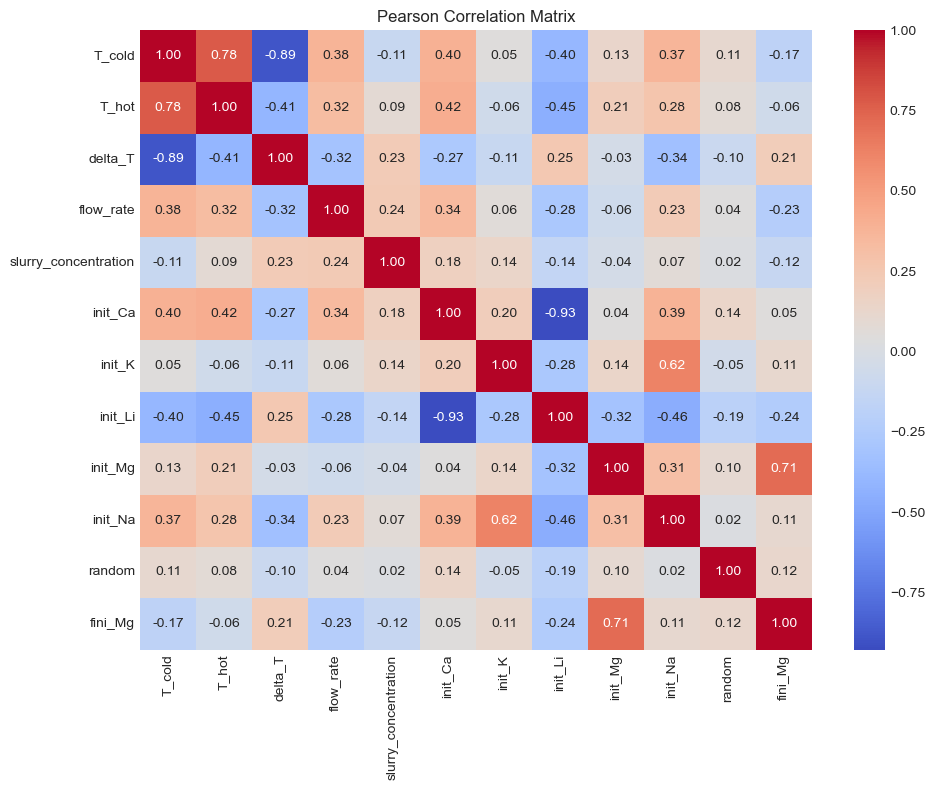

Generating Partial Dependence Plots:


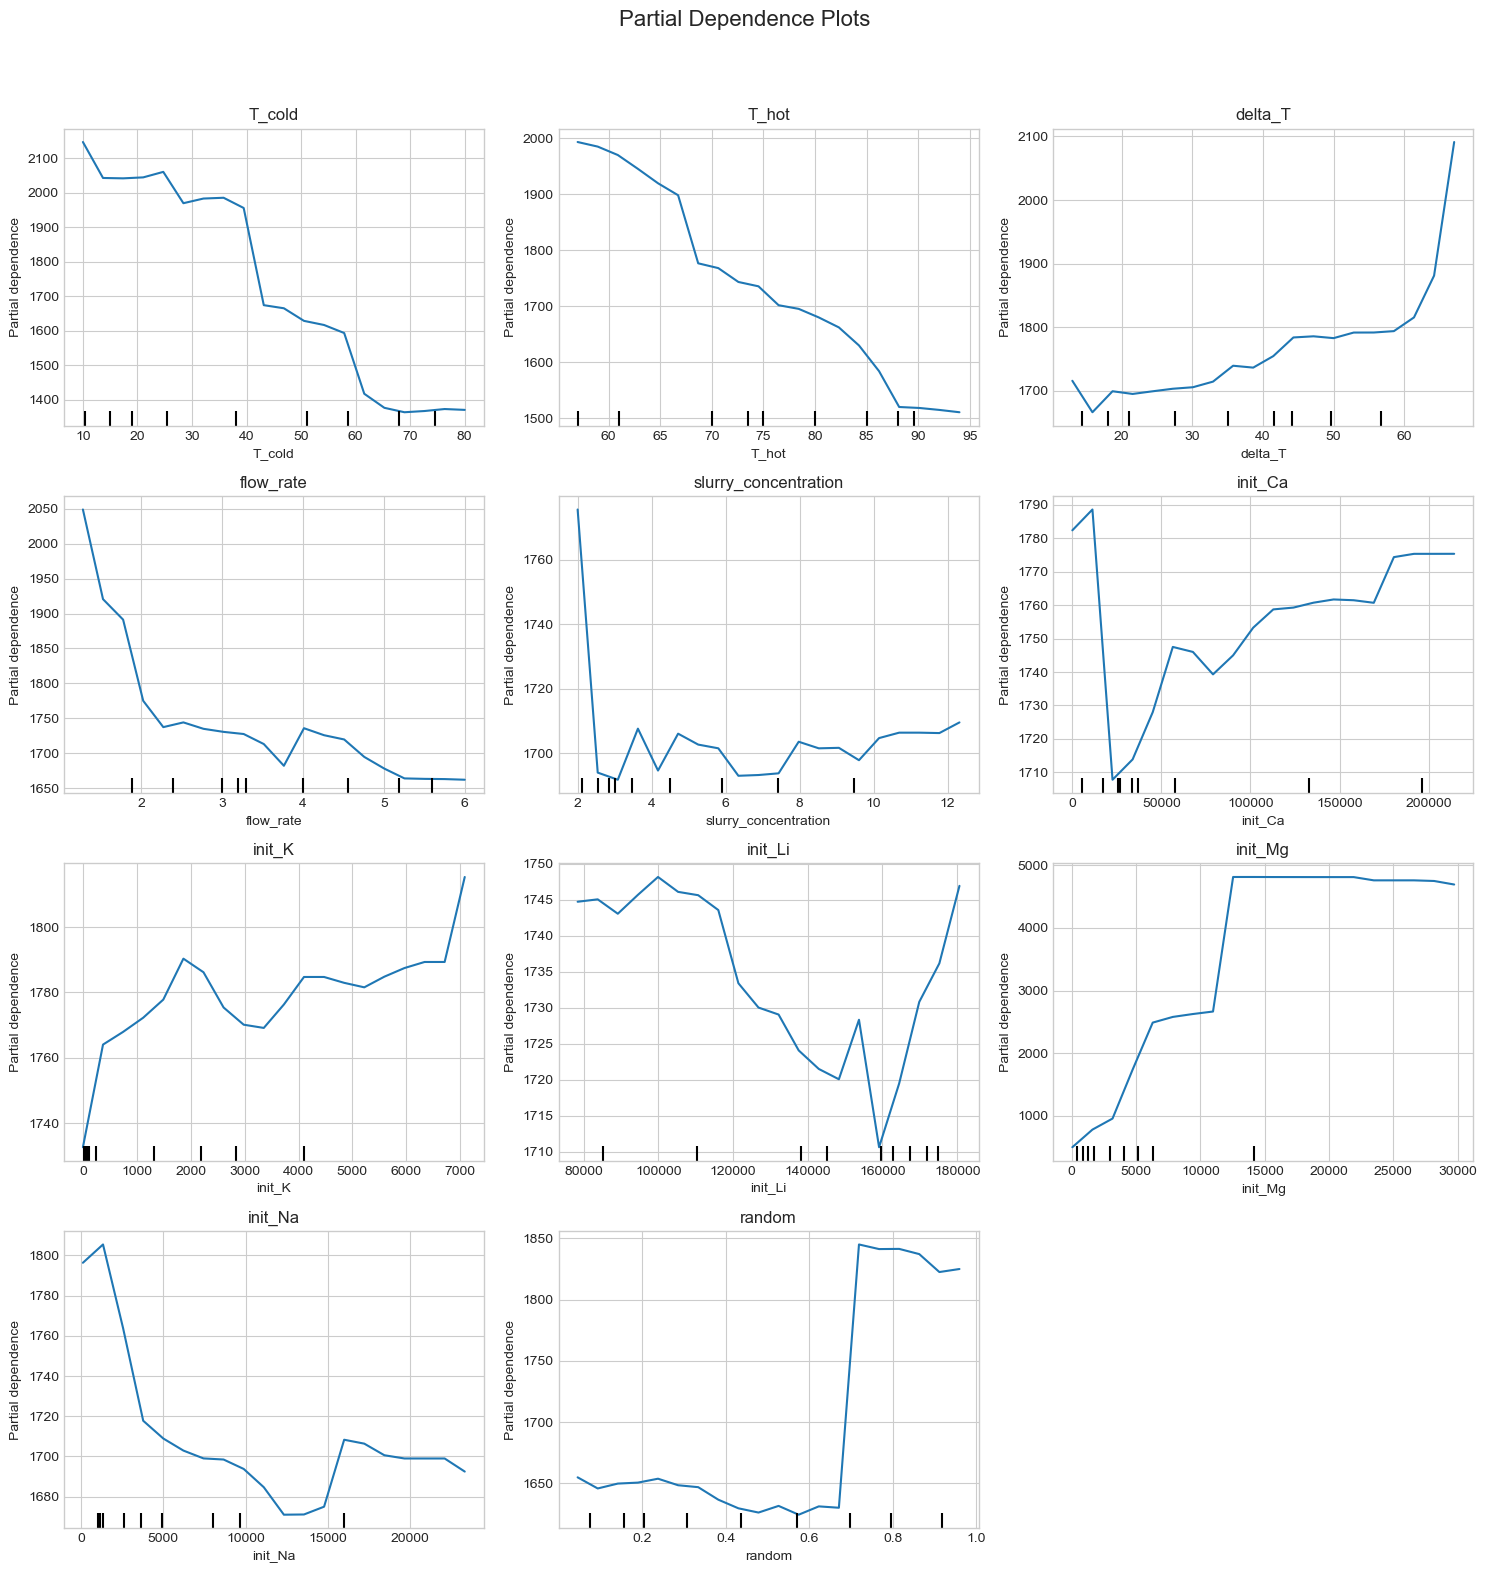

Generating SHAP Feature Importance Plot:


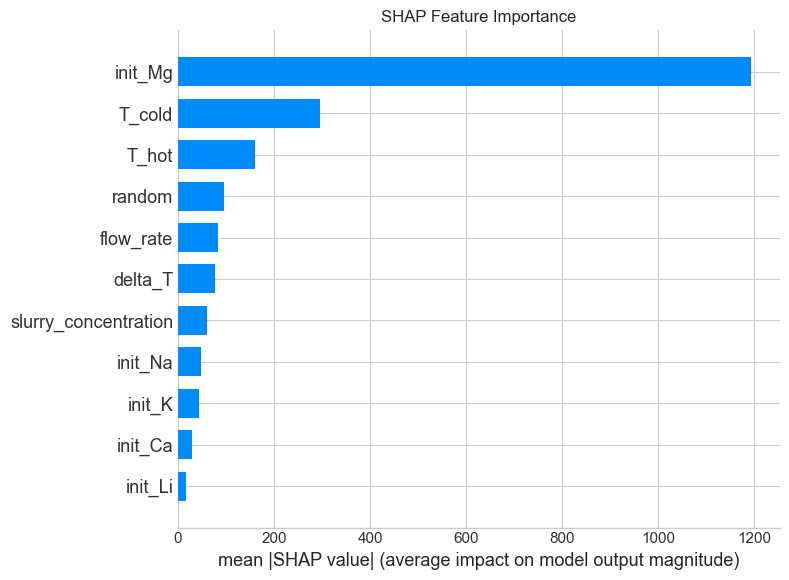

Generating Mutual Information Plot:


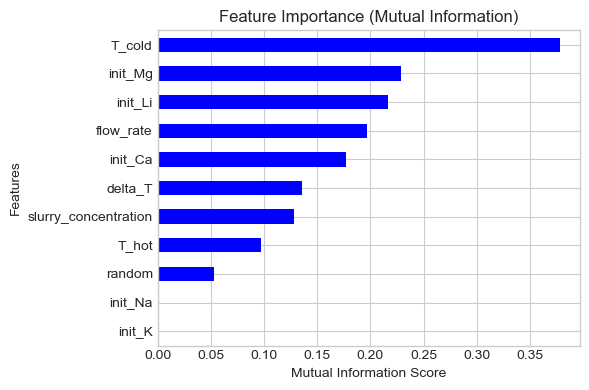

Performing Sensitivity Analysis:


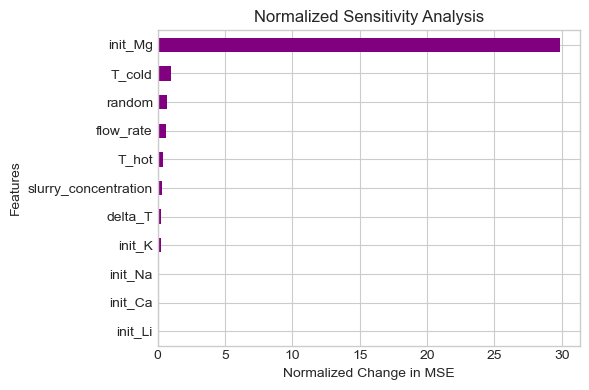

[I 2025-08-23 00:52:30,825] A new study created in memory with name: no-name-200d727f-f4b8-4354-858c-6d65417fd88f



--- Analyzing for Target: bg ---
Tuning hyperparameters...


[I 2025-08-23 00:52:32,944] Trial 0 finished with value: 0.20462377469145113 and parameters: {'n_estimators': 188, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.20462377469145113.
[I 2025-08-23 00:52:33,771] Trial 1 finished with value: 0.18821635077586157 and parameters: {'n_estimators': 63, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.18821635077586157.
[I 2025-08-23 00:52:36,516] Trial 2 finished with value: 0.16584862775545944 and parameters: {'n_estimators': 214, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.16584862775545944.
[I 2025-08-23 00:52:37,311] Trial 3 finished with value: 0.1717352725901808 and parameters: {'n_estimators': 58, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.16584862775545944.
[I 2025-08-23 00:52:38,850] Trial 4 finished with value: 0.20966656381570753 and param

Best parameters found: {'n_estimators': 236, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
Training model...
Generating Data Analysis Plots:


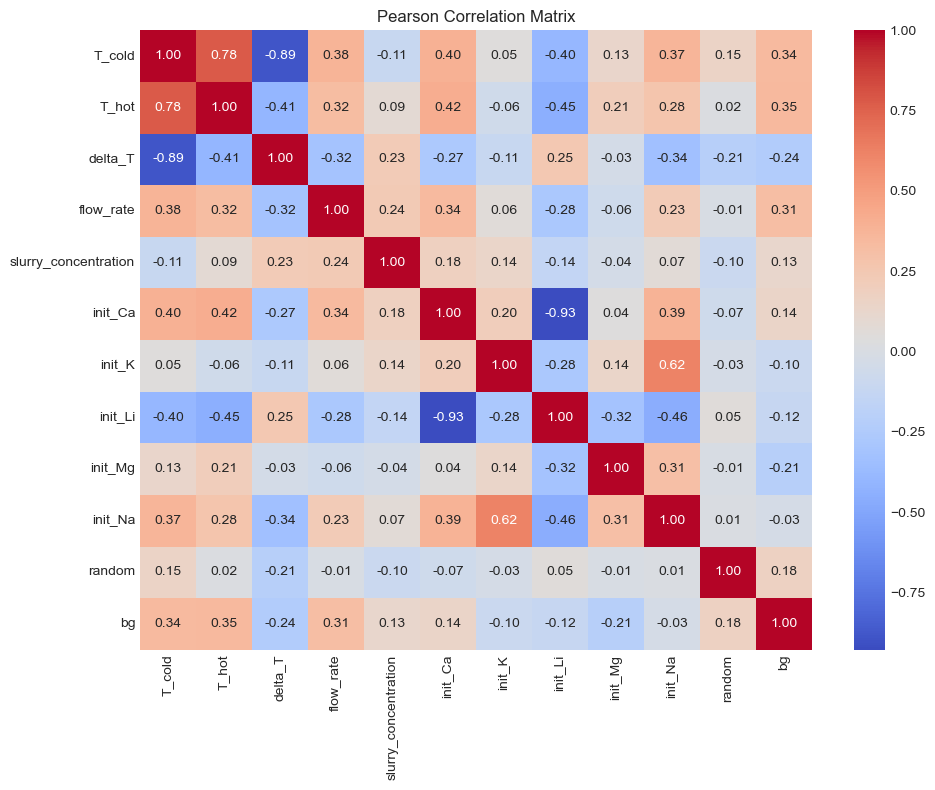

Generating Partial Dependence Plots:


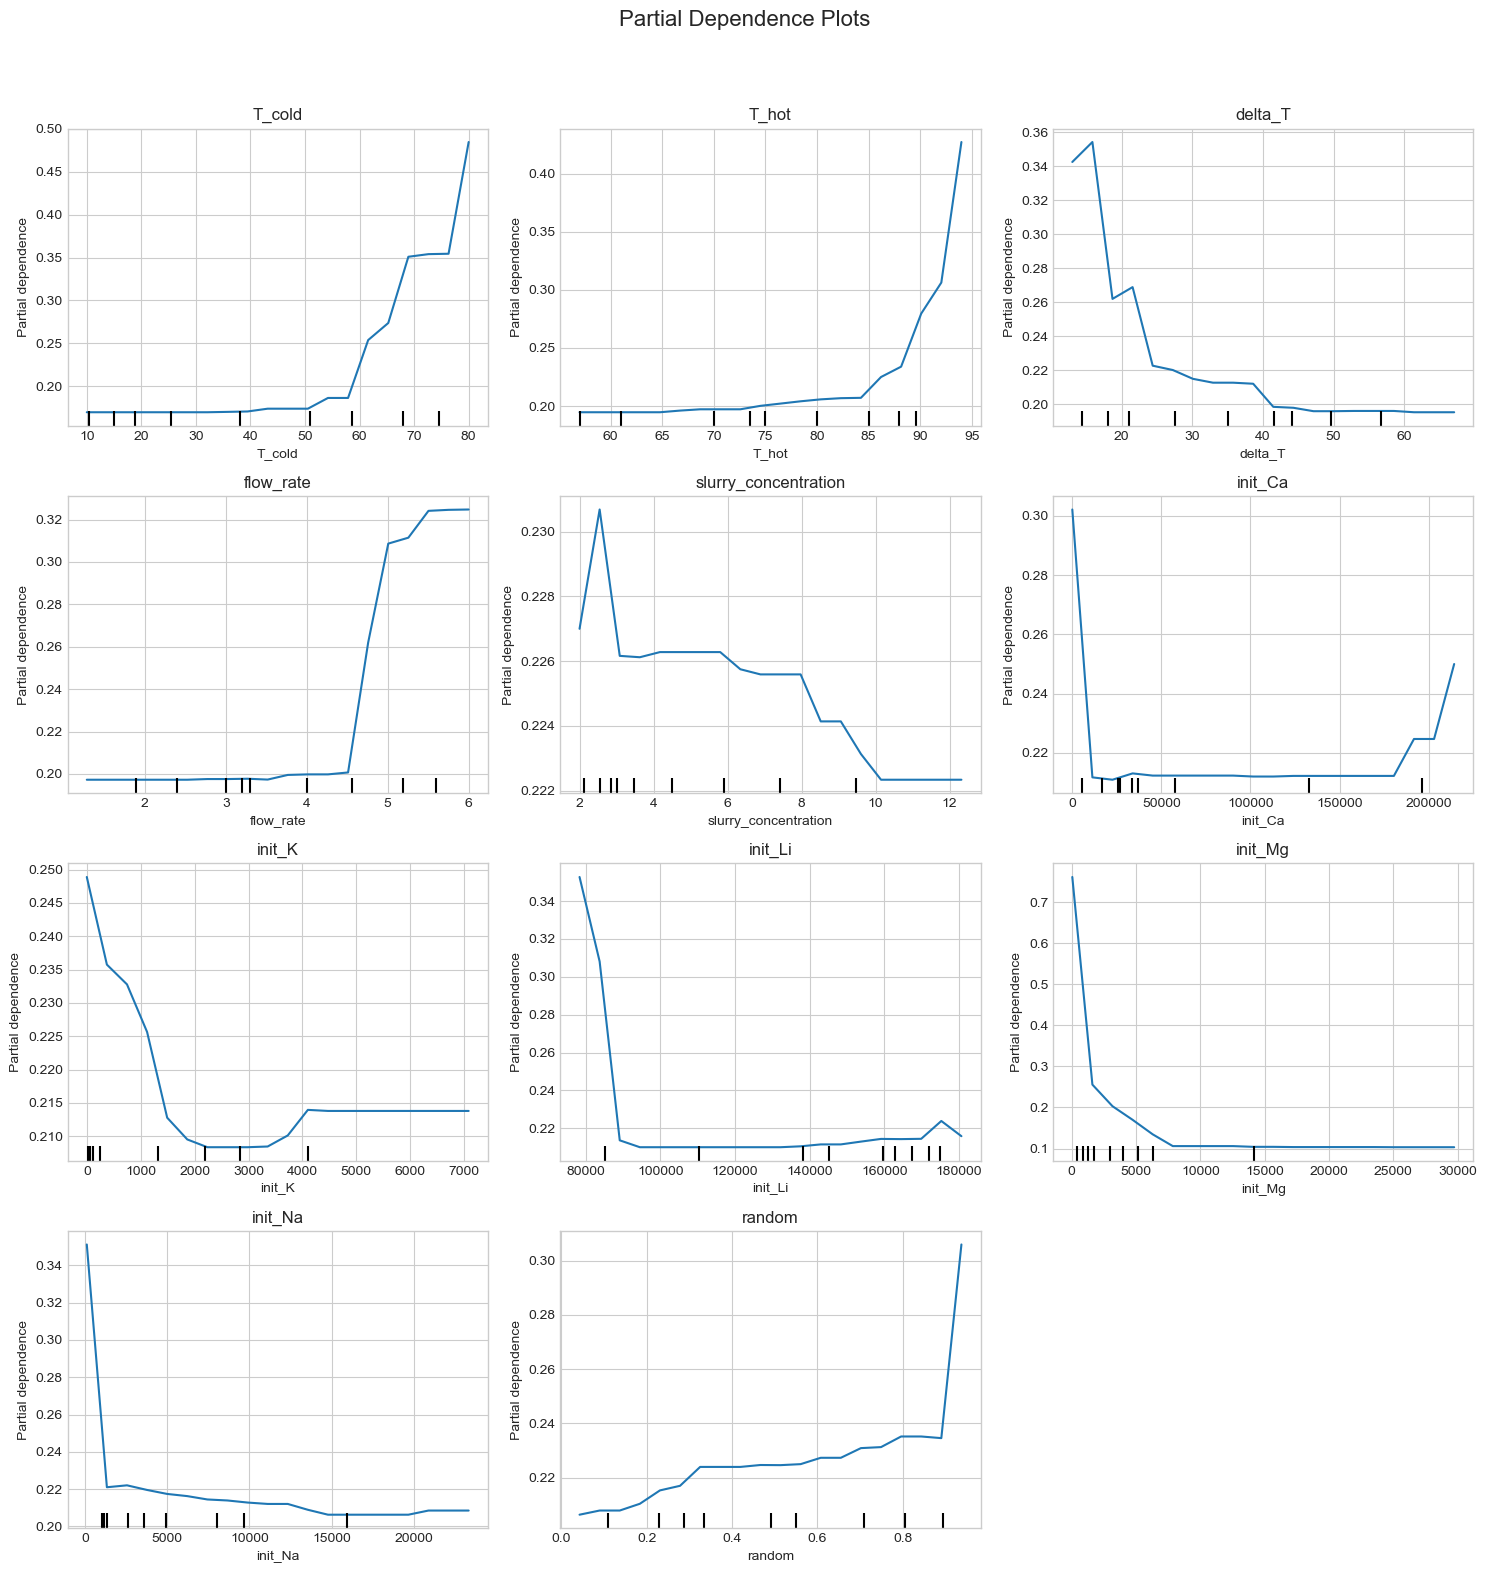

Generating SHAP Feature Importance Plot:


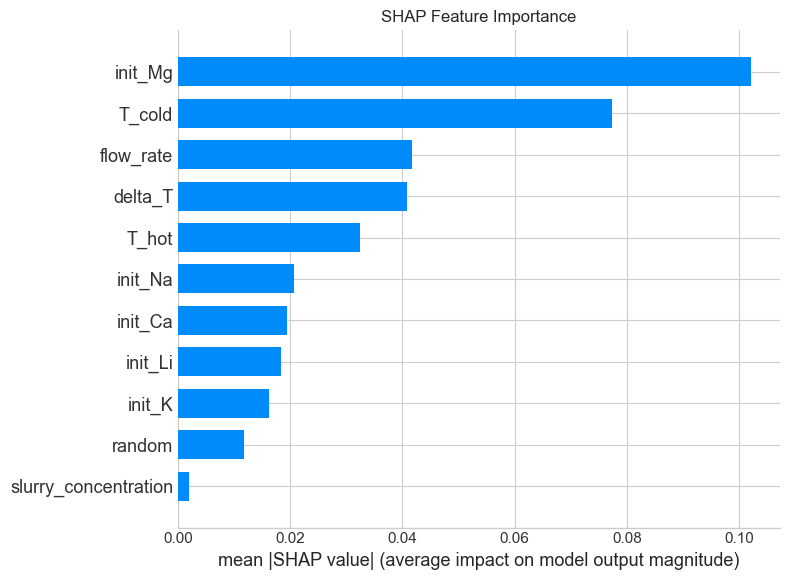

Generating Mutual Information Plot:


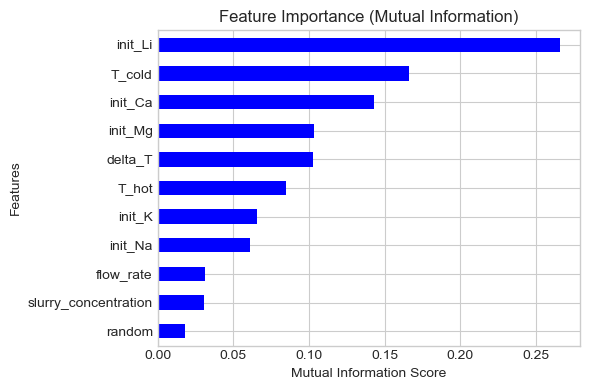

Performing Sensitivity Analysis:


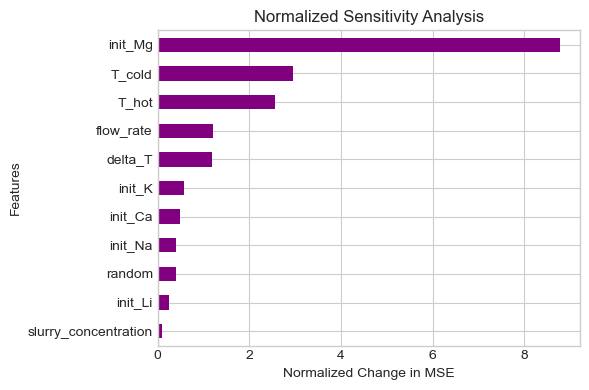

In [16]:
if 'cleaned_data_all' in locals() and not cleaned_data_all.empty:
    find_missing_data(cleaned_data_all)

    feature_columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration', 'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']
    target_columns_mg = ['fini_Mg']
    analysis_df_mg = cleaned_data_all.copy()
    analysis_df_mg['random'] = np.random.random(size=len(analysis_df_mg))
    feature_columns_with_random = feature_columns + ['random']
    
    # Perform analysis for Final Mg Concentration
    perform_full_analysis(analysis_df_mg.dropna(subset=feature_columns_with_random + target_columns_mg), 
                          feature_columns_with_random, 
                          target_columns_mg)

    # Perform analysis for Battery Grade Label
    target_columns_bg = ['bg']
    analysis_df_bg = cleaned_data_all.copy().dropna(subset=feature_columns + target_columns_bg)
    analysis_df_bg['random'] = np.random.random(size=len(analysis_df_bg))
    perform_full_analysis(analysis_df_bg, feature_columns_with_random, target_columns_bg)
else:
    print("Skipping analysis because data was not loaded.")

### 3.1. Inspections: Cycle by Cycle

[I 2025-08-23 00:54:23,099] A new study created in memory with name: no-name-543c98cd-7631-411d-85c0-458cd37c1712



--- Analyzing for Target: fini_Mg ---
Tuning hyperparameters...


[I 2025-08-23 00:54:25,267] Trial 0 finished with value: 24381448.92756308 and parameters: {'n_estimators': 225, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 24381448.92756308.
[I 2025-08-23 00:54:26,378] Trial 1 finished with value: 25173797.36871357 and parameters: {'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 24381448.92756308.
[I 2025-08-23 00:54:27,496] Trial 2 finished with value: 20583752.733398557 and parameters: {'n_estimators': 124, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 2 with value: 20583752.733398557.
[I 2025-08-23 00:54:29,865] Trial 3 finished with value: 24445827.294274718 and parameters: {'n_estimators': 273, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 2 with value: 20583752.733398557.
[I 2025-08-23 00:54:30,506] Trial 4 finished with value: 20193117.335030872 and parameters: {'n_esti

Best parameters found: {'n_estimators': 106, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4}
Training model...
Generating Data Analysis Plots:


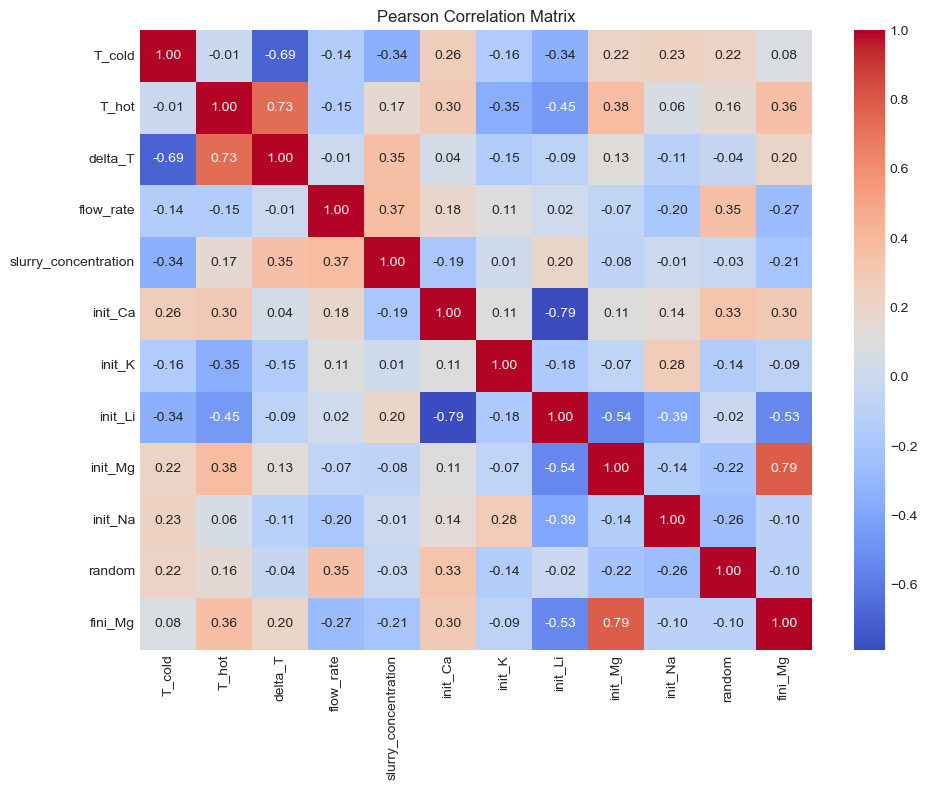

Generating Partial Dependence Plots:


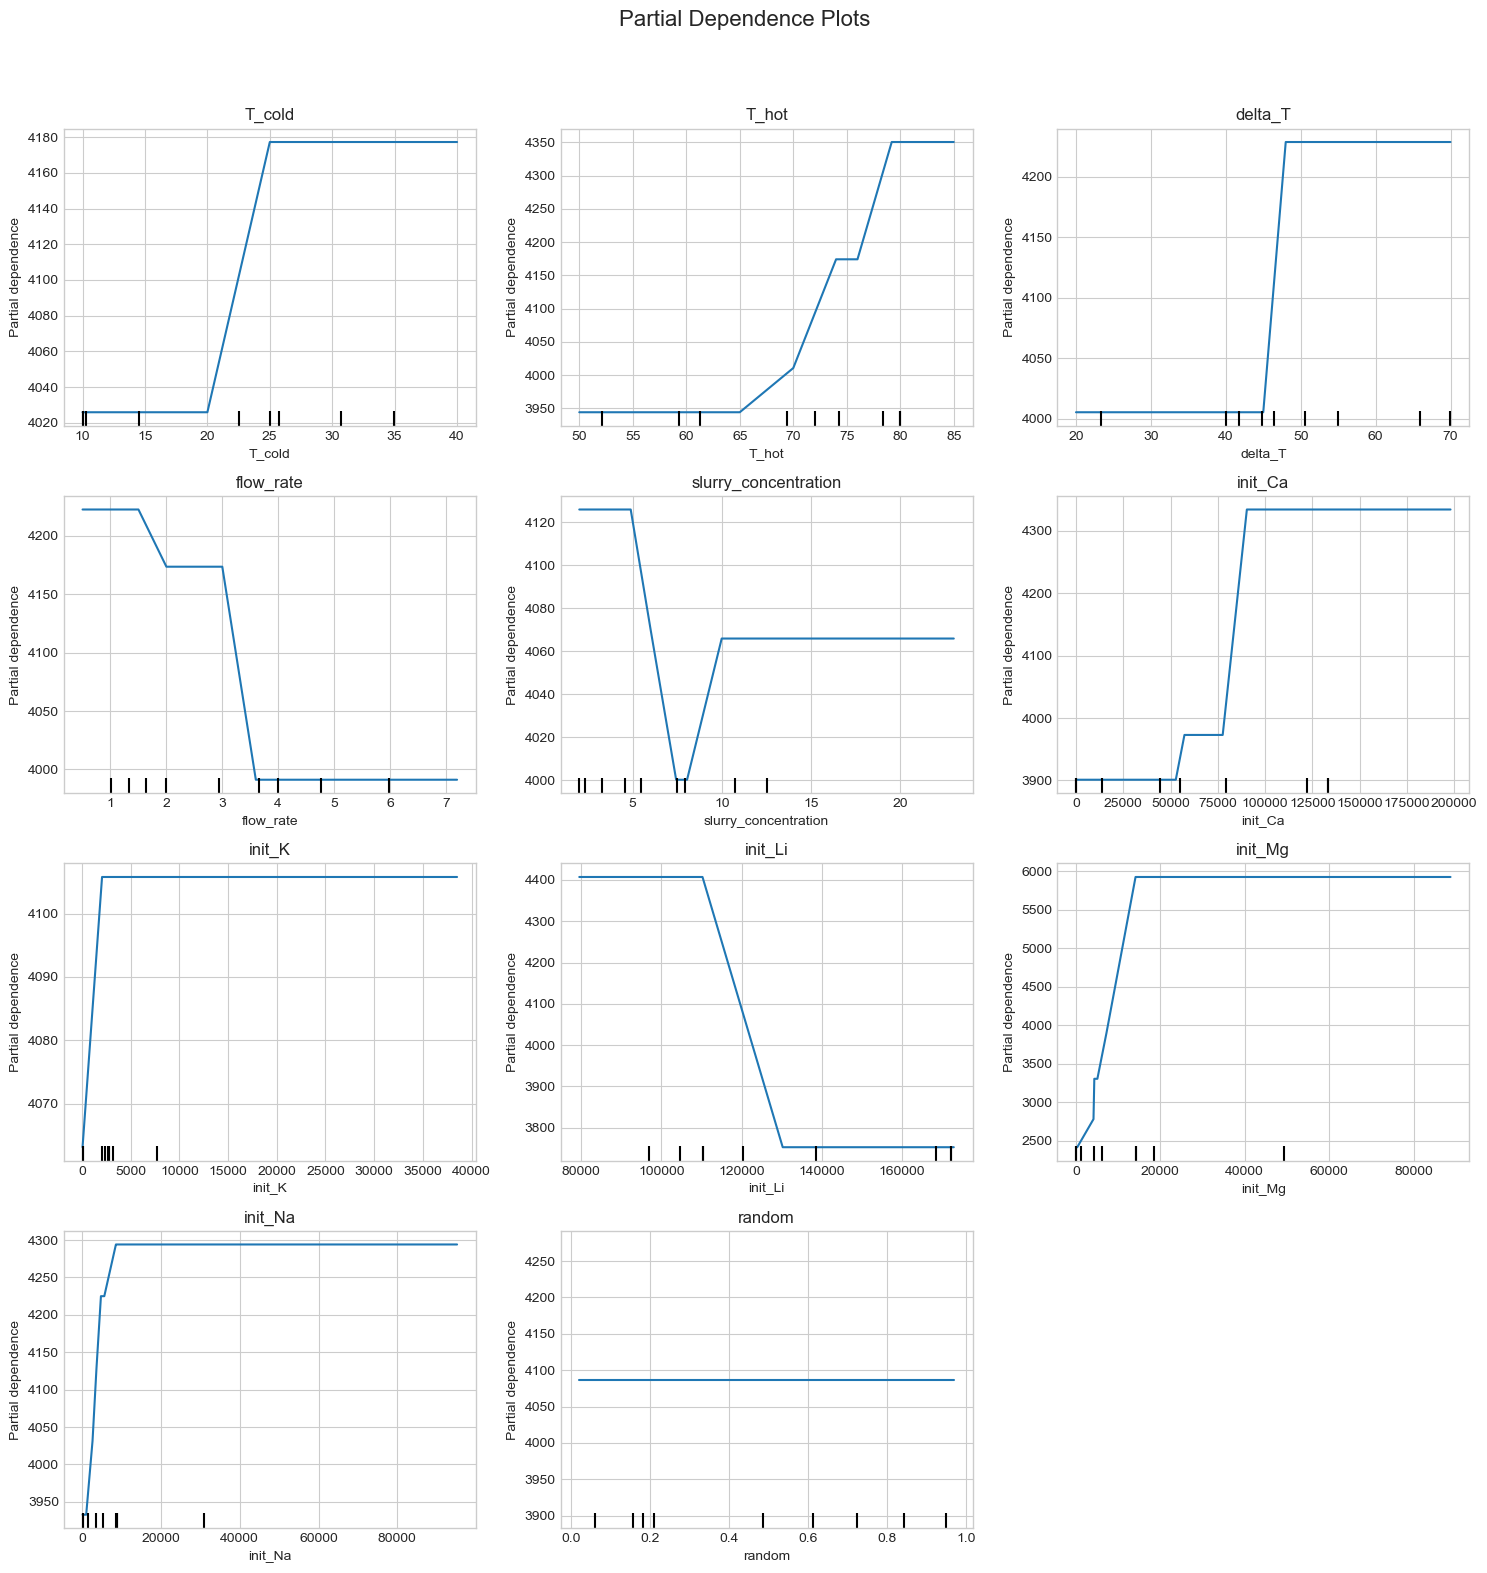

Generating SHAP Feature Importance Plot:


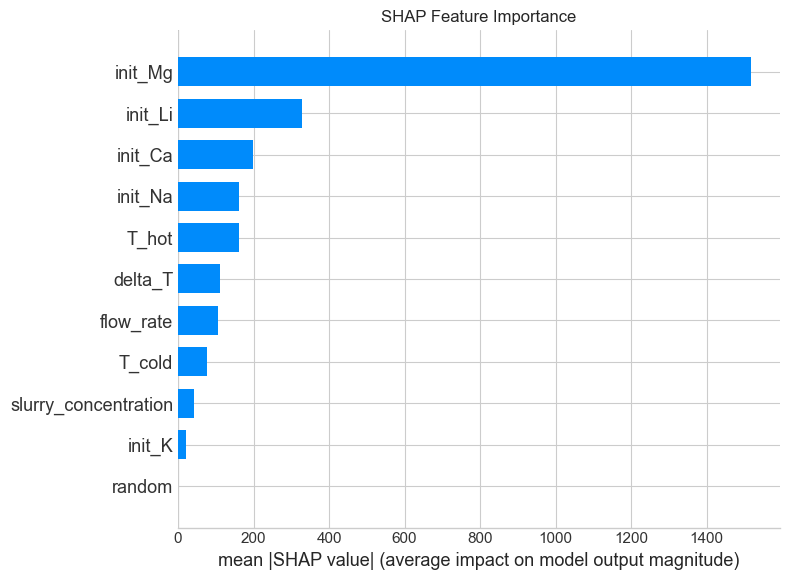

Generating Mutual Information Plot:


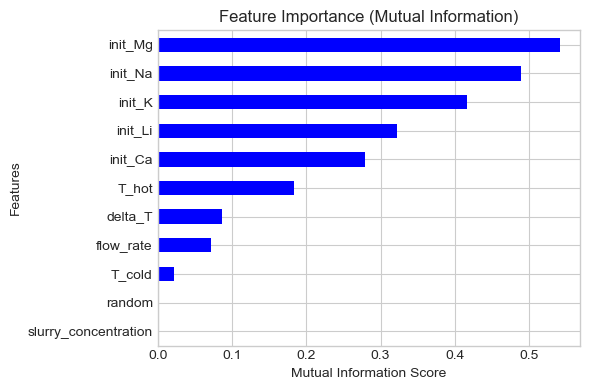

Performing Sensitivity Analysis:


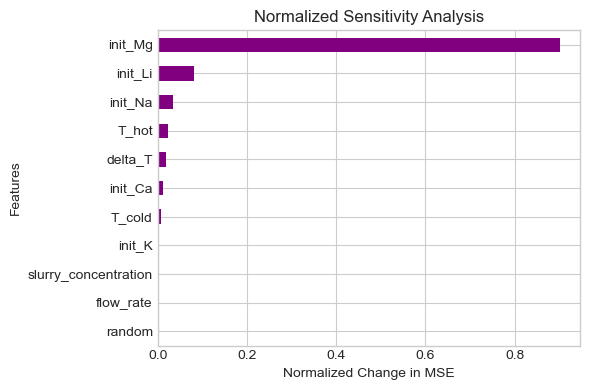

[I 2025-08-23 00:55:03,141] A new study created in memory with name: no-name-c0af8dd8-9cc1-45ca-b41f-5e0b038848fb



--- Analyzing for Target: fini_K ---
Tuning hyperparameters...


[I 2025-08-23 00:55:03,899] Trial 0 finished with value: 29339.632945073965 and parameters: {'n_estimators': 123, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 29339.632945073965.
[I 2025-08-23 00:55:06,026] Trial 1 finished with value: 29439.953232099586 and parameters: {'n_estimators': 181, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 0 with value: 29339.632945073965.
[I 2025-08-23 00:55:07,434] Trial 2 finished with value: 29396.245339408233 and parameters: {'n_estimators': 161, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 29339.632945073965.
[I 2025-08-23 00:55:08,545] Trial 3 finished with value: 27126.906980247288 and parameters: {'n_estimators': 82, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 3 with value: 27126.906980247288.
[I 2025-08-23 00:55:10,000] Trial 4 finished with value: 28760.207503221765 and parameters: 

Best parameters found: {'n_estimators': 251, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4}
Training model...
Generating Data Analysis Plots:


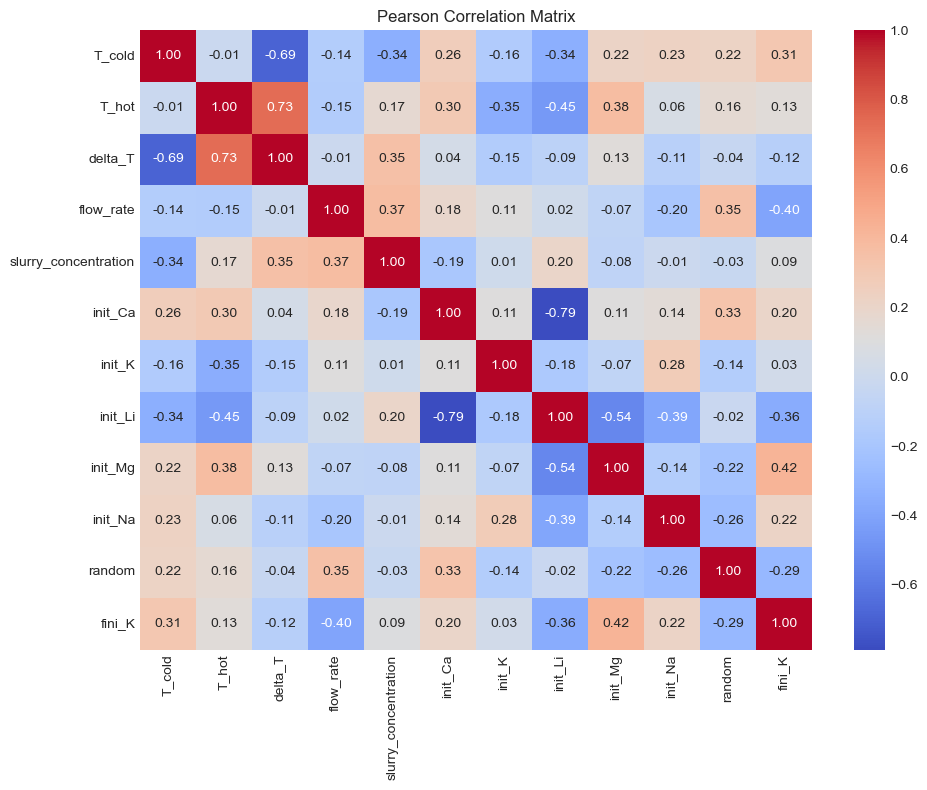

Generating Partial Dependence Plots:


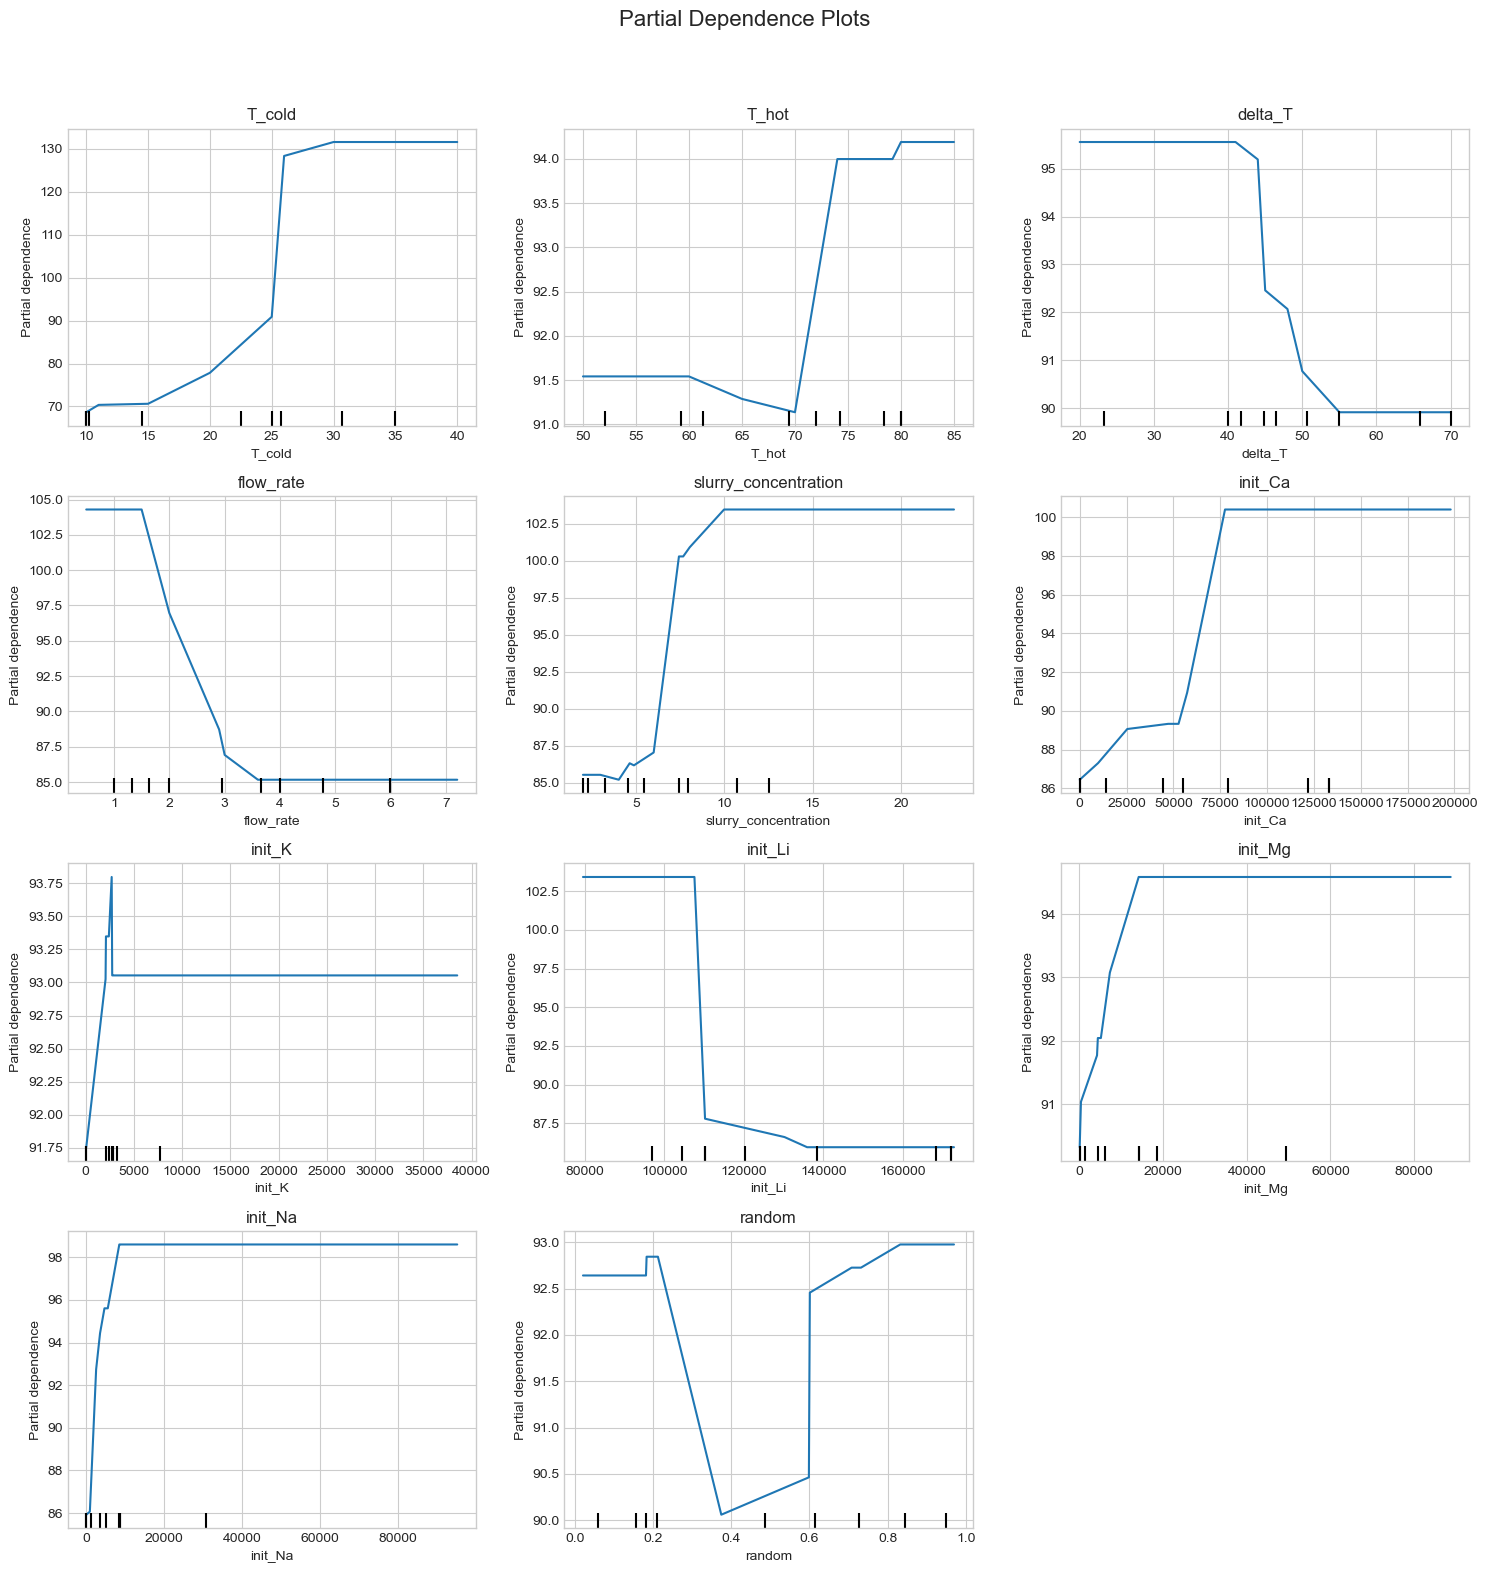

Generating SHAP Feature Importance Plot:


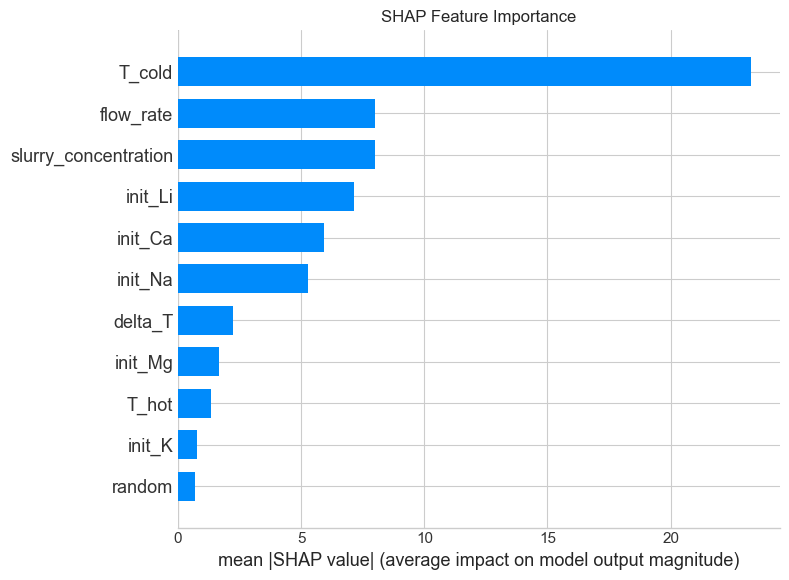

Generating Mutual Information Plot:


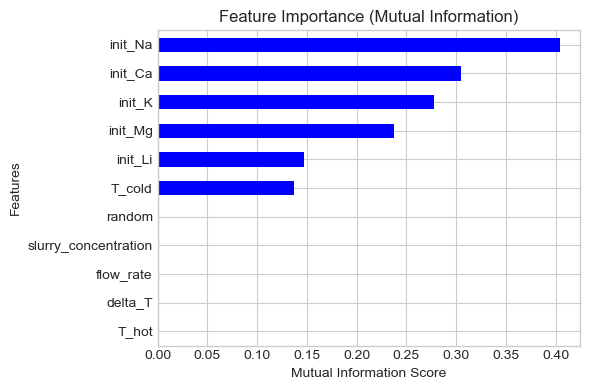

Performing Sensitivity Analysis:


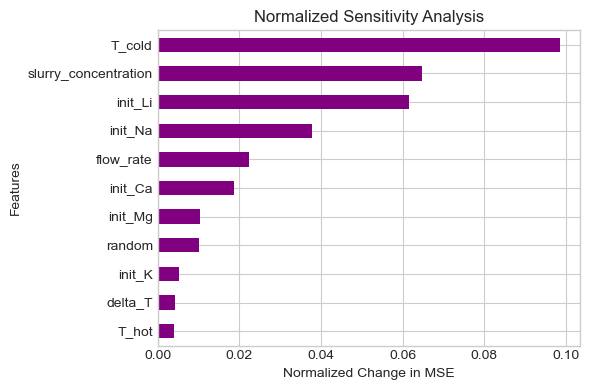

[I 2025-08-23 00:55:54,840] A new study created in memory with name: no-name-39f26693-a362-4e1a-b38d-3228391ce437



--- Analyzing for Target: fini_Li_purity ---
Tuning hyperparameters...


[I 2025-08-23 00:55:55,587] Trial 0 finished with value: 0.0011897943901040787 and parameters: {'n_estimators': 52, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.0011897943901040787.
[I 2025-08-23 00:55:56,202] Trial 1 finished with value: 0.0012667388191279186 and parameters: {'n_estimators': 57, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.0011897943901040787.
[I 2025-08-23 00:55:57,377] Trial 2 finished with value: 0.0011040778486033347 and parameters: {'n_estimators': 103, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.0011040778486033347.
[I 2025-08-23 00:55:59,385] Trial 3 finished with value: 0.0011946594325743481 and parameters: {'n_estimators': 154, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.0011040778486033347.
[I 2025-08-23 00:56:01,236] Trial 4 finished with value: 0.00110032080

Best parameters found: {'n_estimators': 135, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4}
Training model...
Generating Data Analysis Plots:


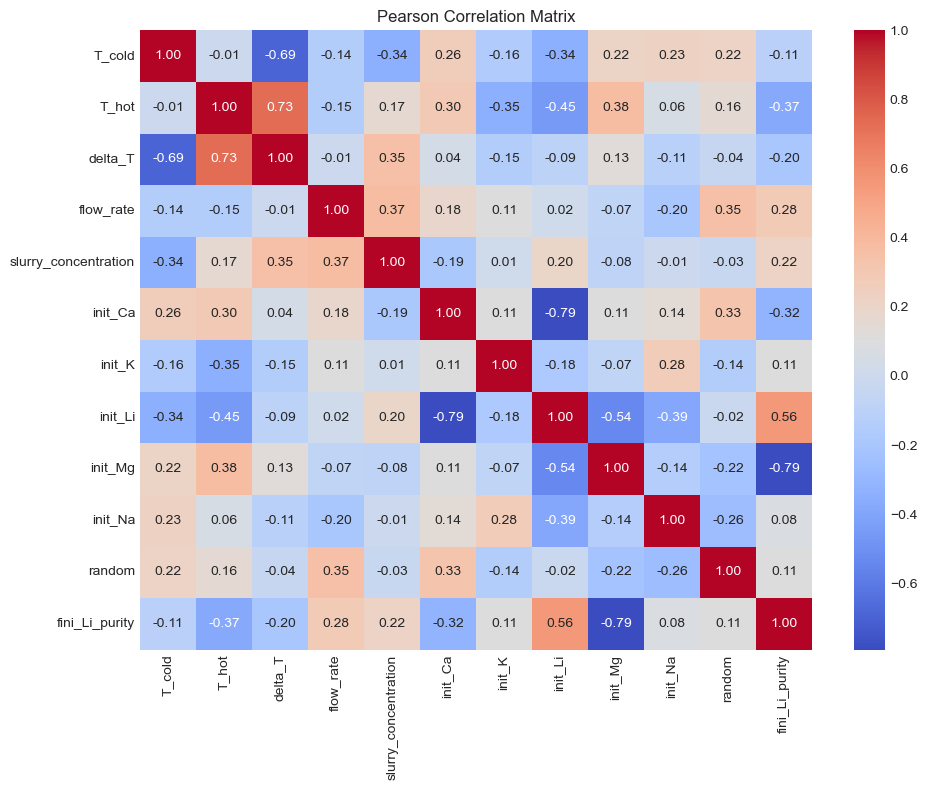

Generating Partial Dependence Plots:


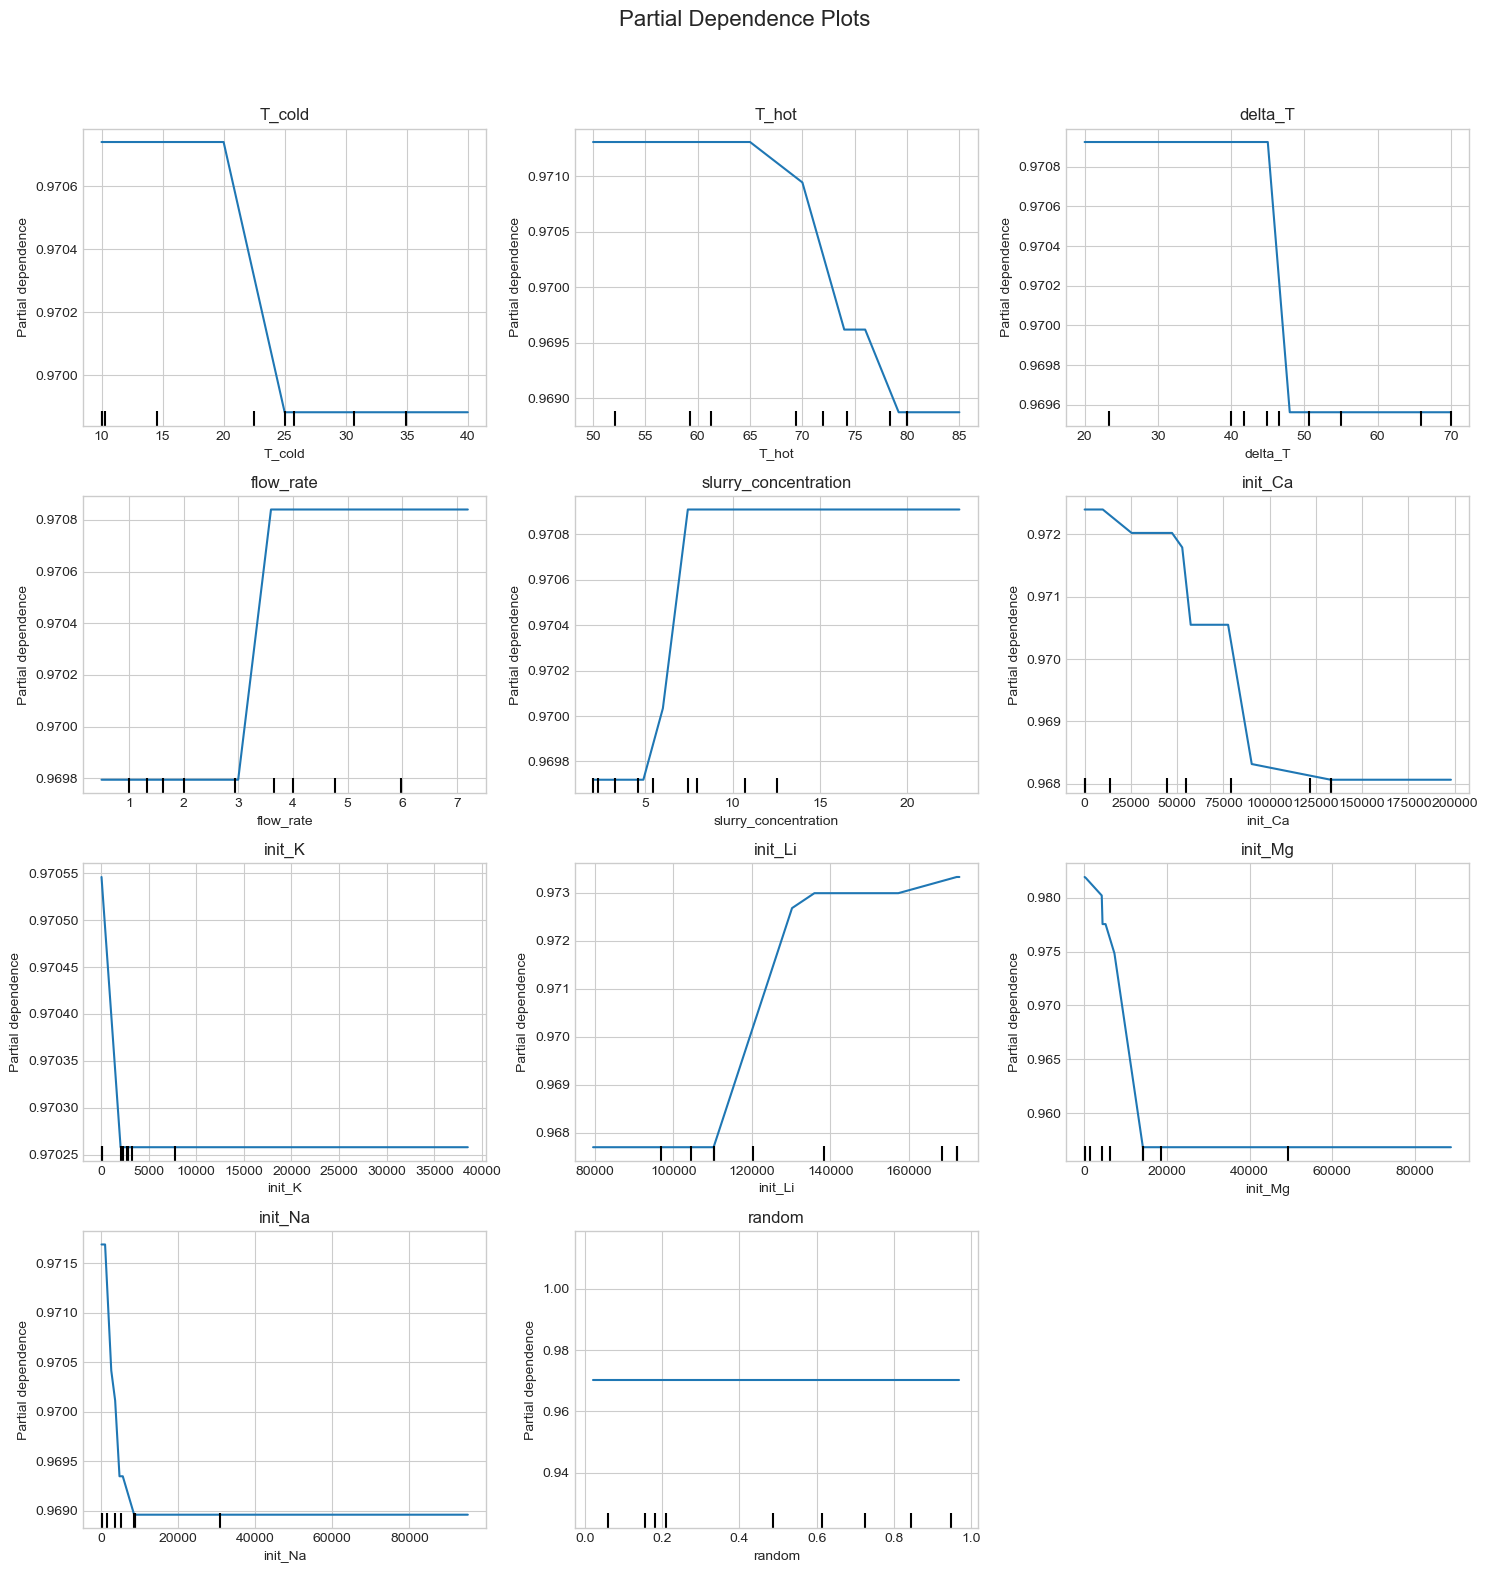

Generating SHAP Feature Importance Plot:


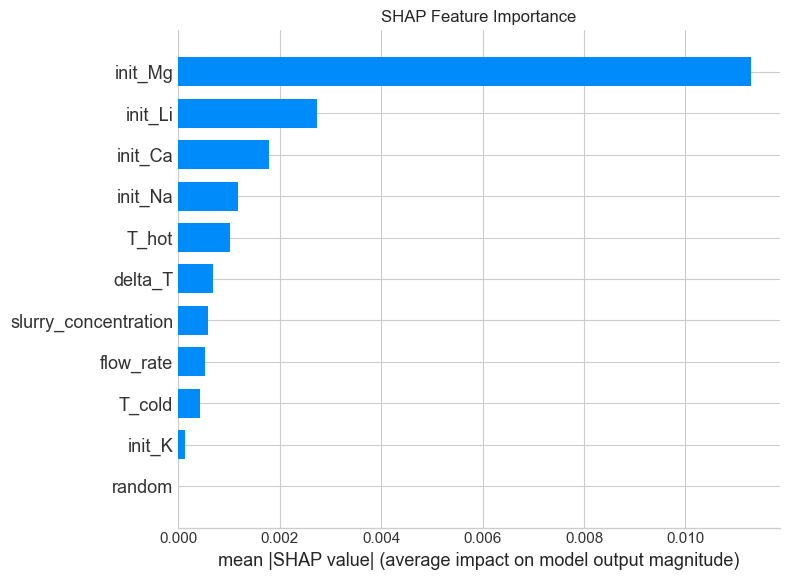

Generating Mutual Information Plot:


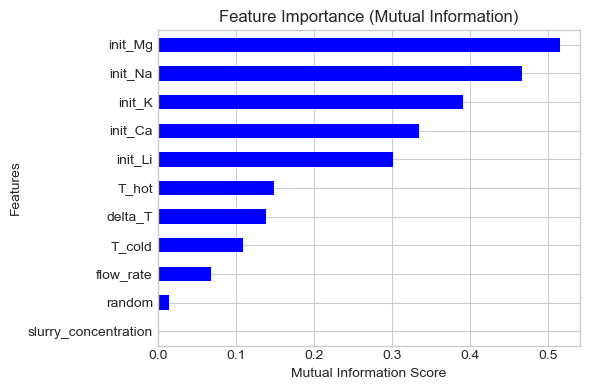

Performing Sensitivity Analysis:


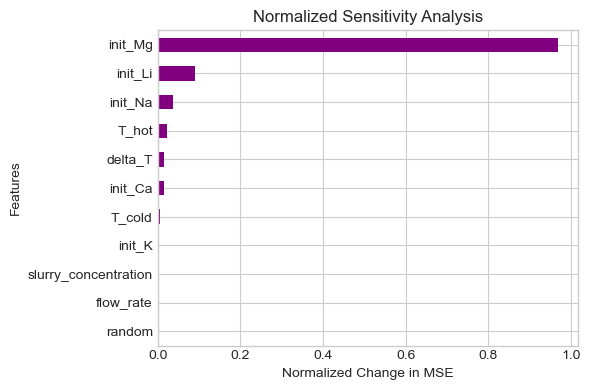

[I 2025-08-23 00:56:48,974] A new study created in memory with name: no-name-b2fa0129-8448-45f3-9950-f38d42bc192f



--- Analyzing for Target: fini_Ca ---
Tuning hyperparameters...


[I 2025-08-23 00:56:56,141] Trial 0 finished with value: 105438.21251706973 and parameters: {'n_estimators': 299, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 105438.21251706973.
[I 2025-08-23 00:57:02,389] Trial 1 finished with value: 105340.18661955444 and parameters: {'n_estimators': 262, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 1 with value: 105340.18661955444.
[I 2025-08-23 00:57:05,663] Trial 2 finished with value: 104673.56965158871 and parameters: {'n_estimators': 138, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 2 with value: 104673.56965158871.
[I 2025-08-23 00:57:08,527] Trial 3 finished with value: 104445.76073663212 and parameters: {'n_estimators': 119, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 3 with value: 104445.76073663212.
[I 2025-08-23 00:57:14,617] Trial 4 finished with value: 105467.77939569621 and parameters: 

Best parameters found: {'n_estimators': 208, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}
Training model...
Generating Data Analysis Plots:


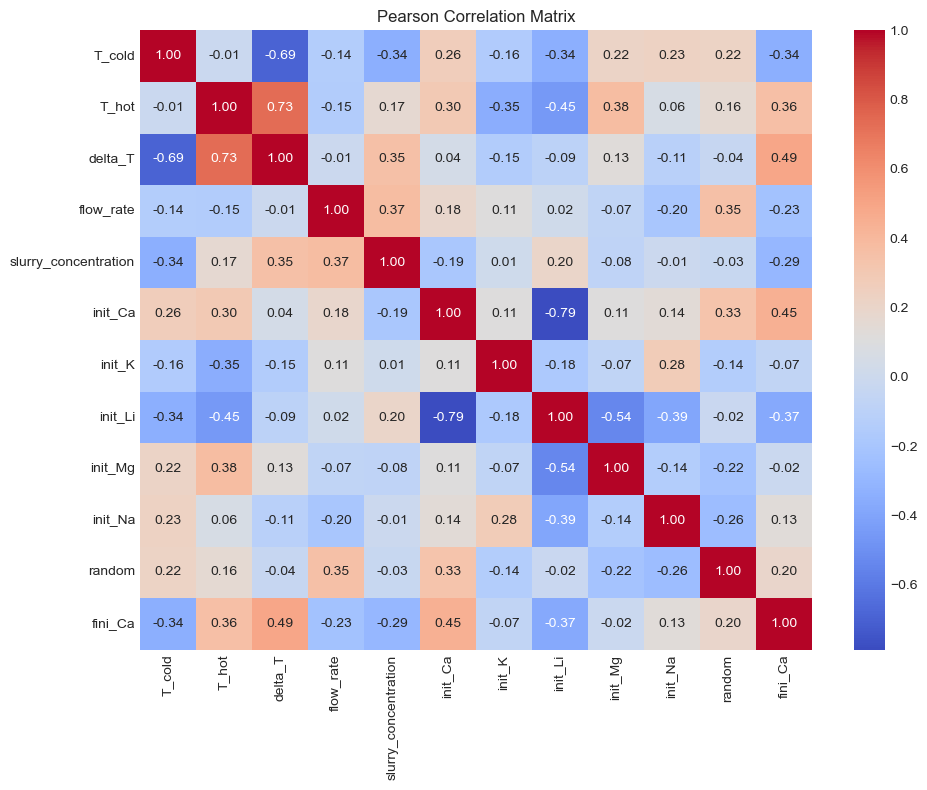

Generating Partial Dependence Plots:


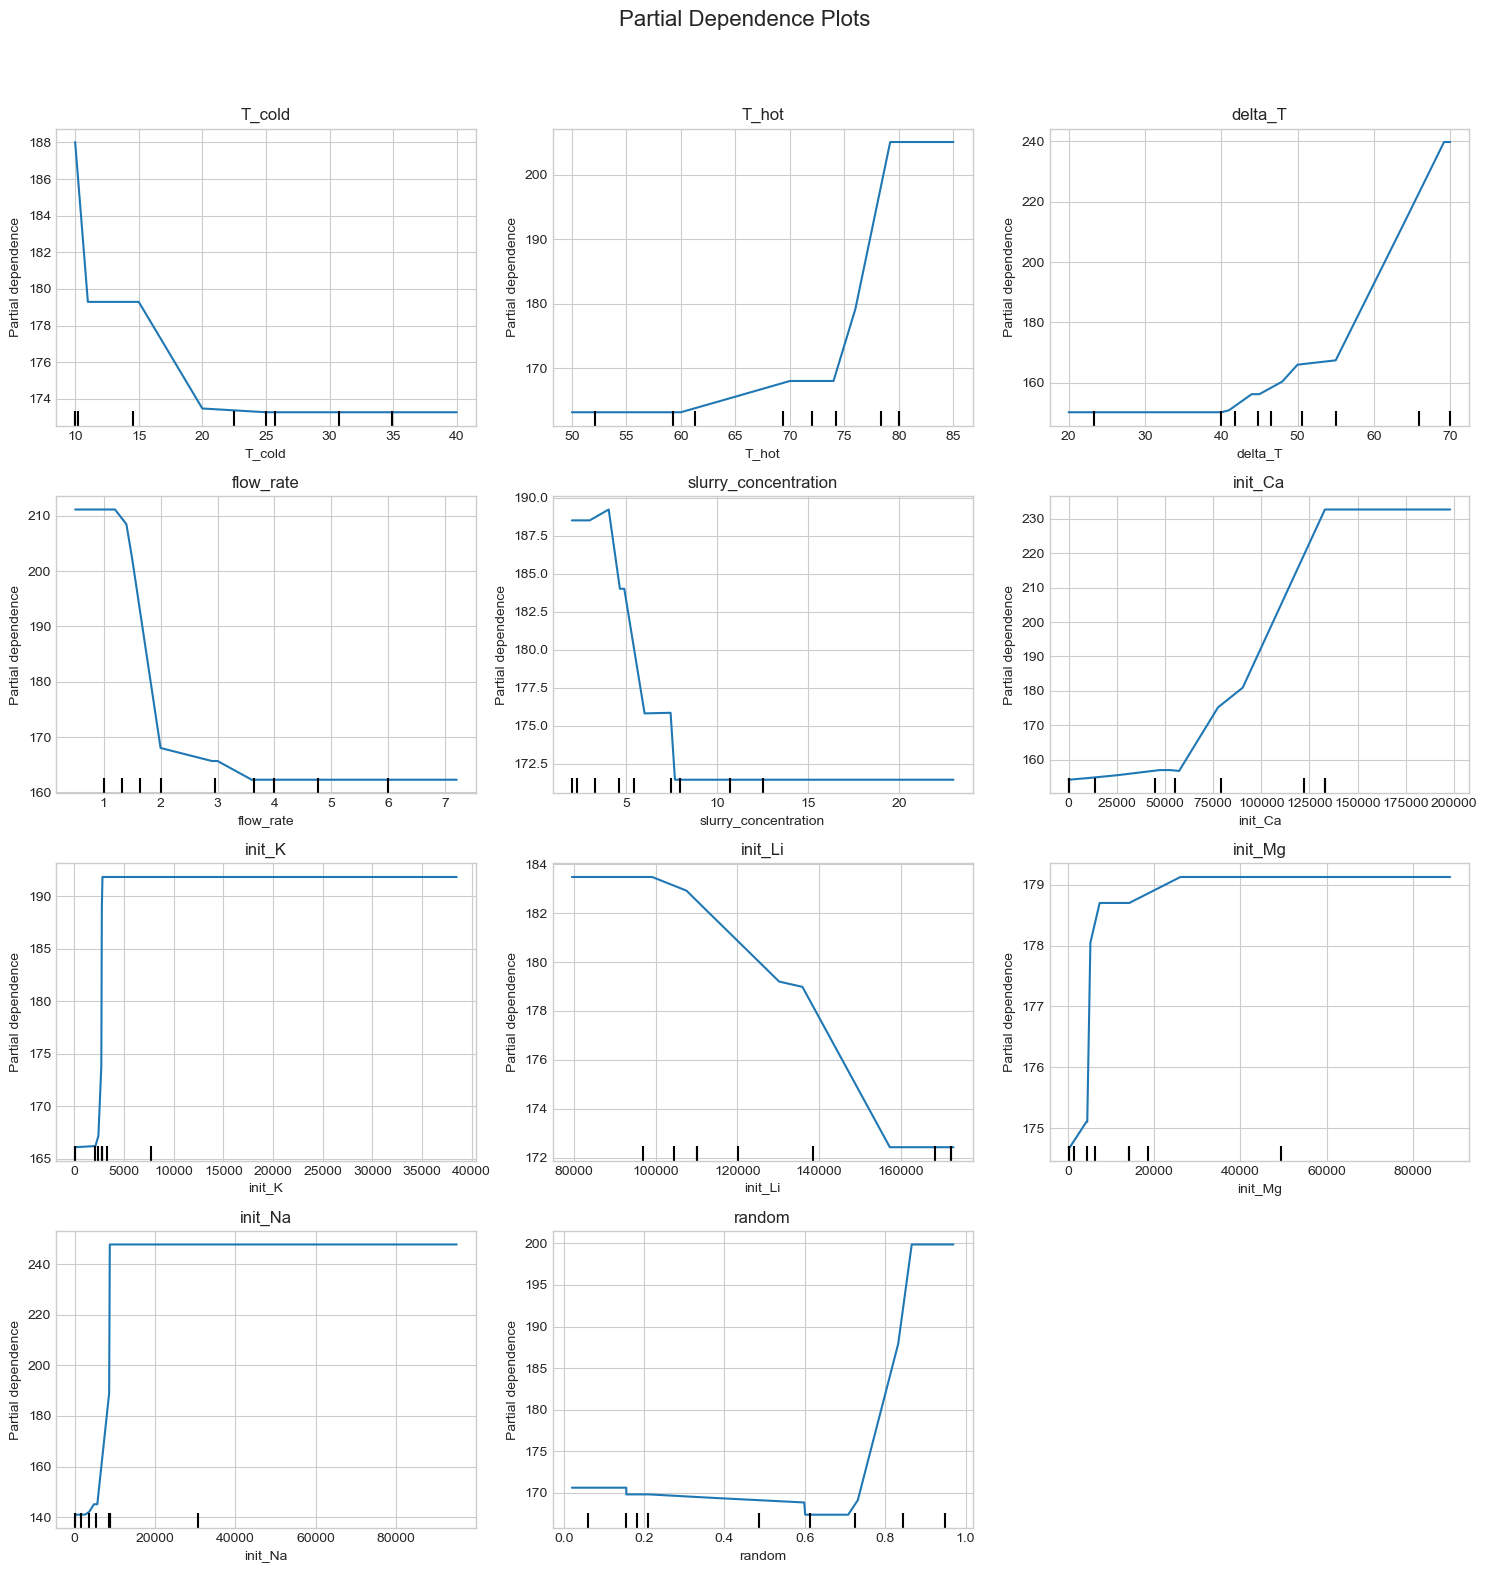

Generating SHAP Feature Importance Plot:


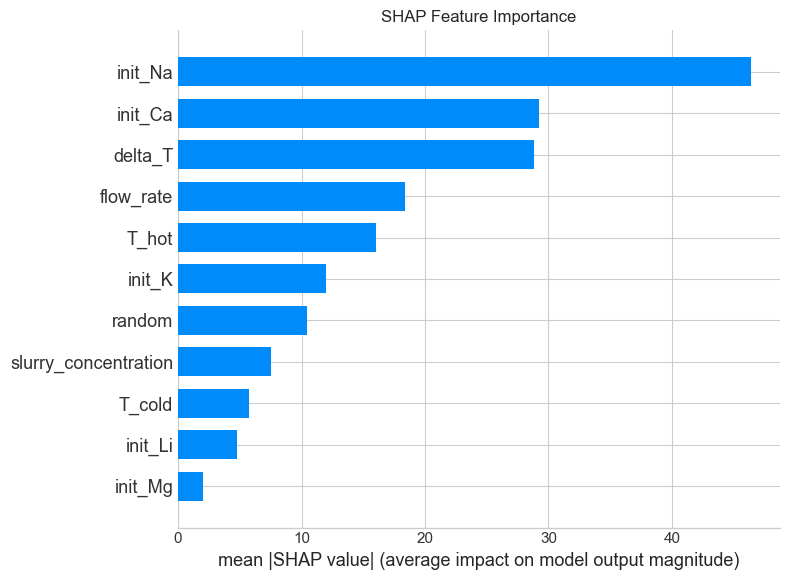

Generating Mutual Information Plot:


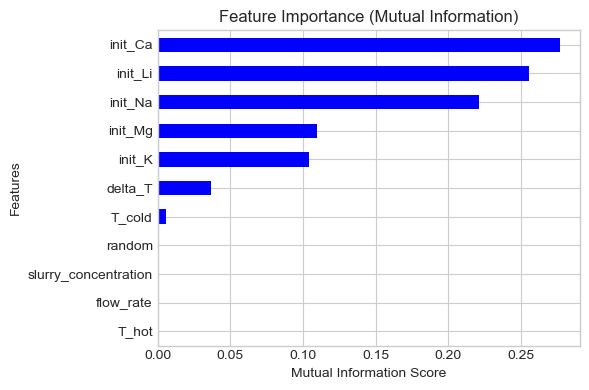

Performing Sensitivity Analysis:


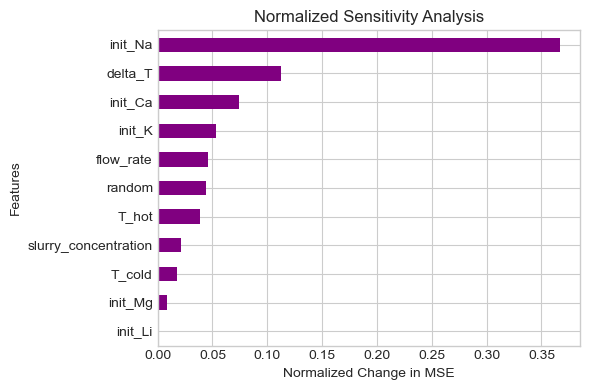

[I 2025-08-23 00:59:03,077] A new study created in memory with name: no-name-d4b41f74-fe59-4ace-a9ba-56edbb99c056



--- Analyzing for Target: fini_Na ---
Tuning hyperparameters...


[I 2025-08-23 00:59:05,823] Trial 0 finished with value: 18112.40526153215 and parameters: {'n_estimators': 108, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 18112.40526153215.
[I 2025-08-23 00:59:12,096] Trial 1 finished with value: 19205.043824585184 and parameters: {'n_estimators': 278, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 18112.40526153215.
[I 2025-08-23 00:59:18,759] Trial 2 finished with value: 18329.33683572898 and parameters: {'n_estimators': 287, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 18112.40526153215.
[I 2025-08-23 00:59:20,928] Trial 3 finished with value: 18173.656548811174 and parameters: {'n_estimators': 79, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 18112.40526153215.
[I 2025-08-23 00:59:23,061] Trial 4 finished with value: 18251.401587203167 and parameters: {'n_esti

Best parameters found: {'n_estimators': 141, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4}
Training model...
Generating Data Analysis Plots:


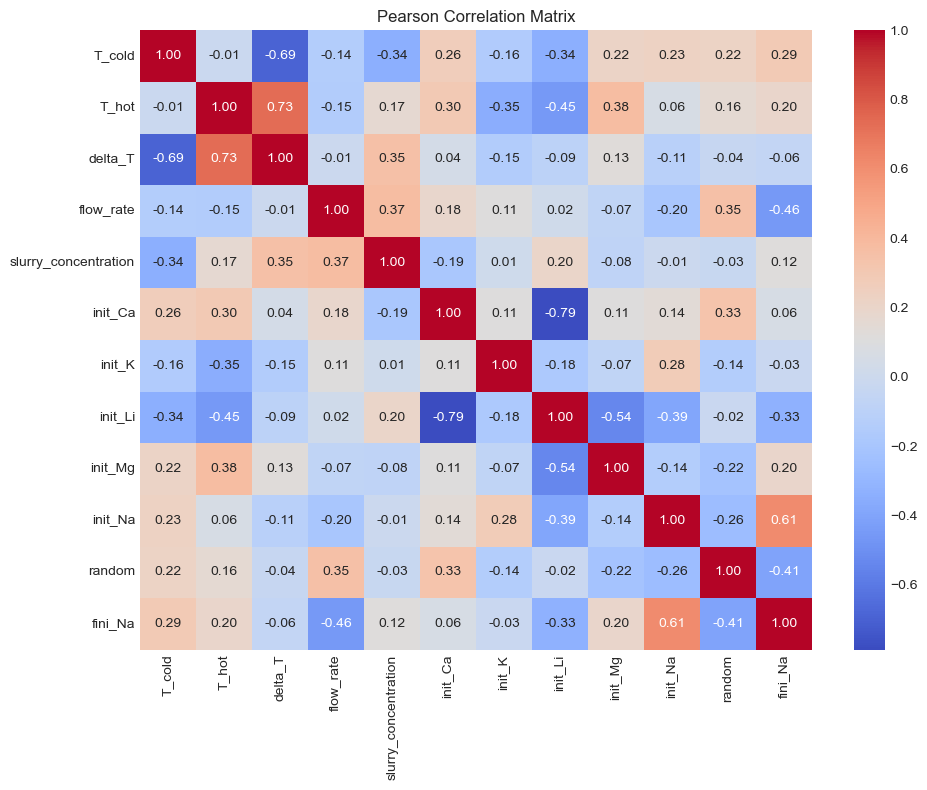

Generating Partial Dependence Plots:


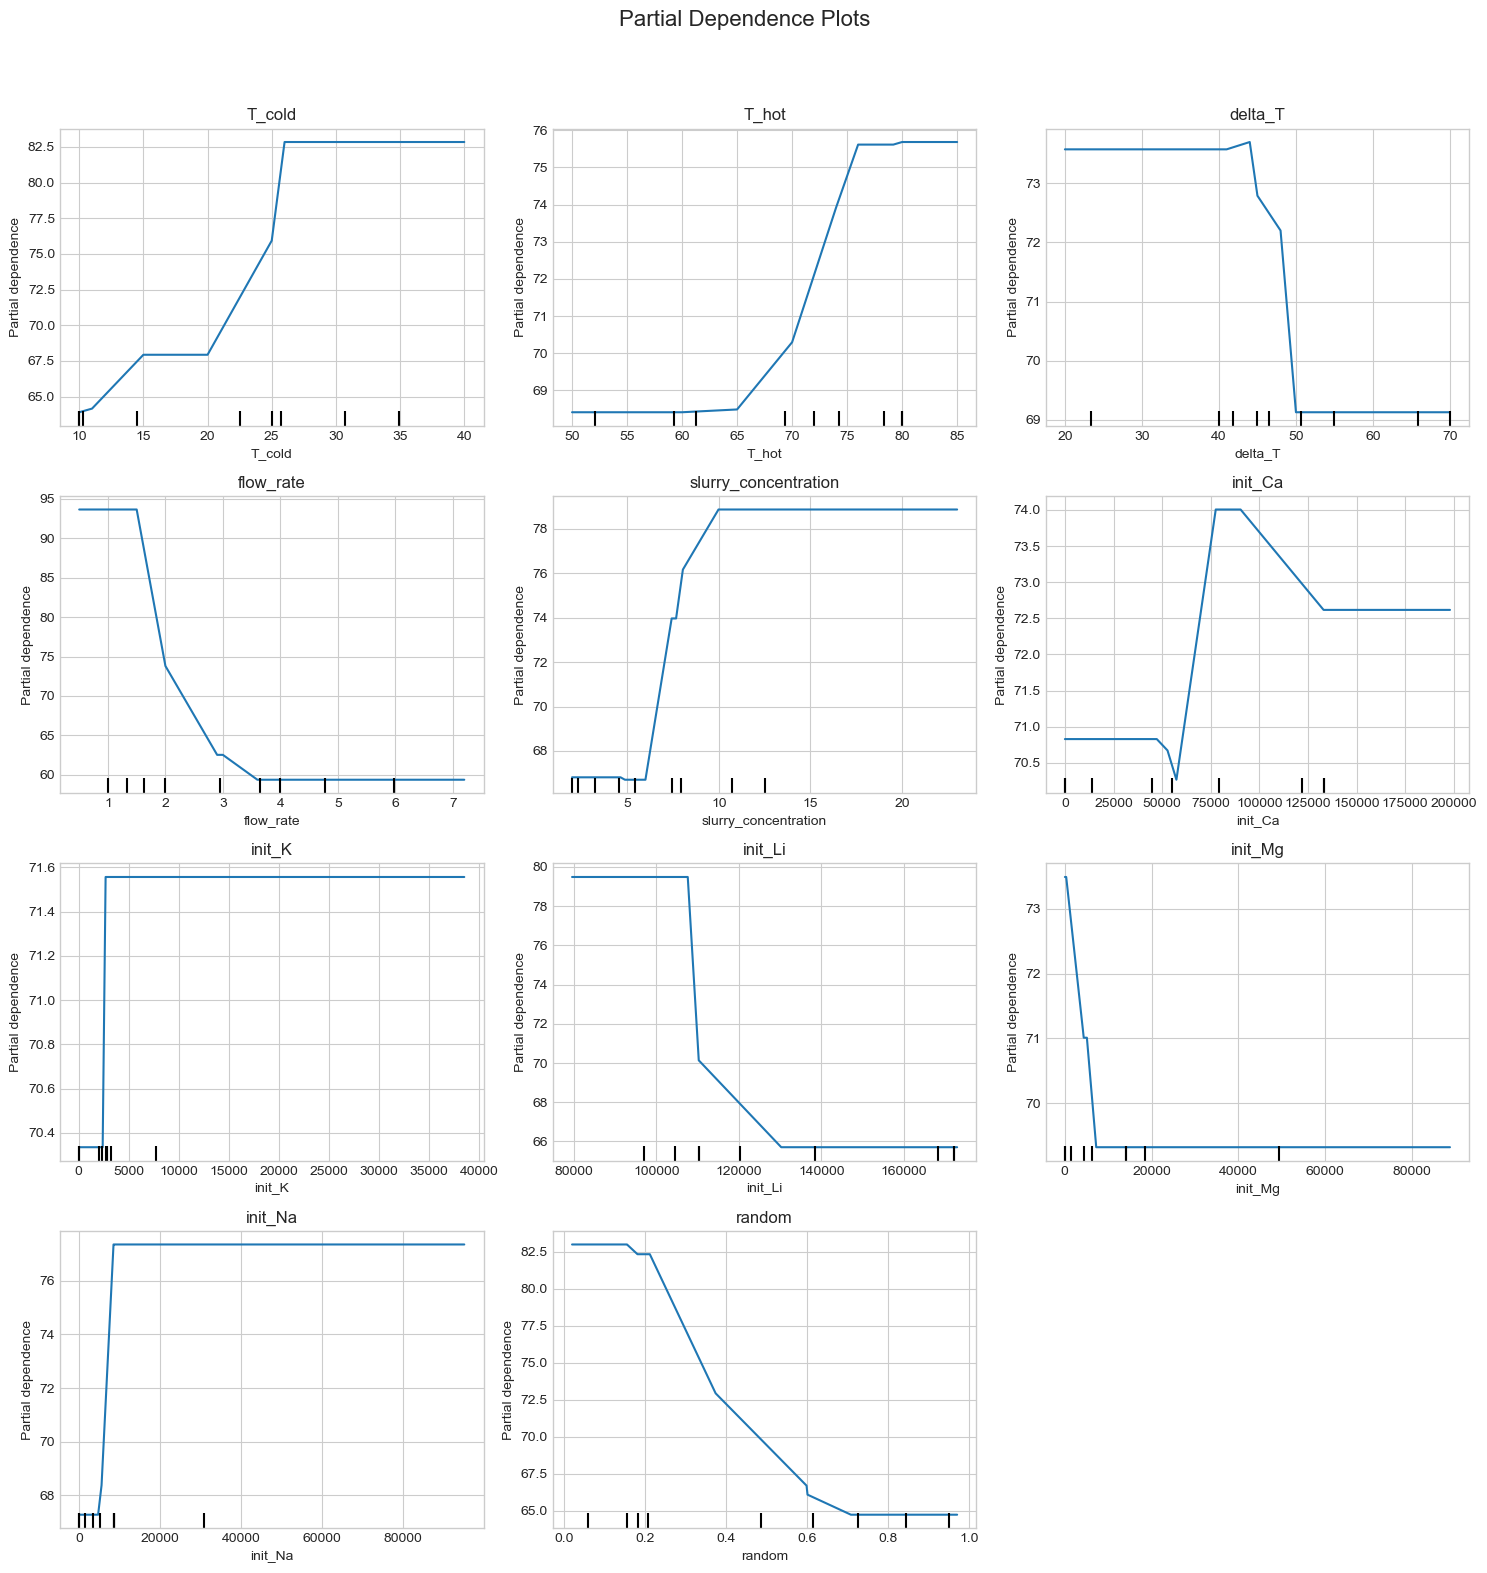

Generating SHAP Feature Importance Plot:


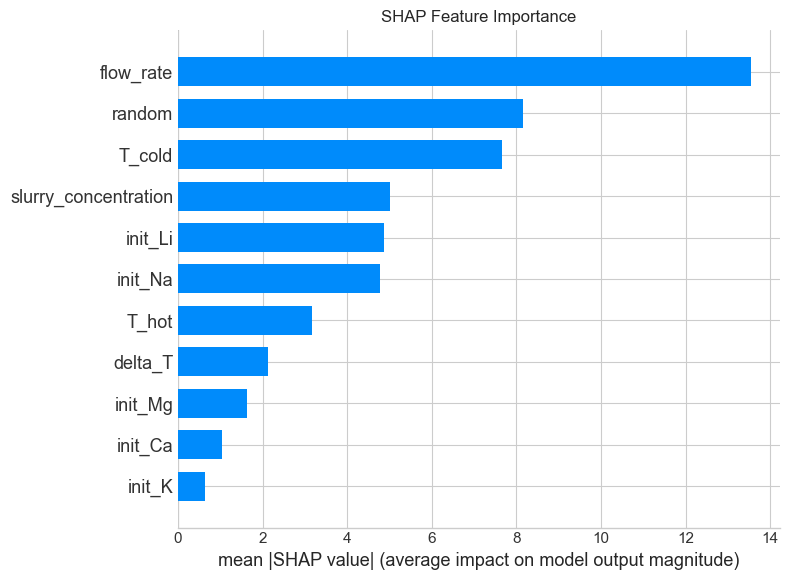

Generating Mutual Information Plot:


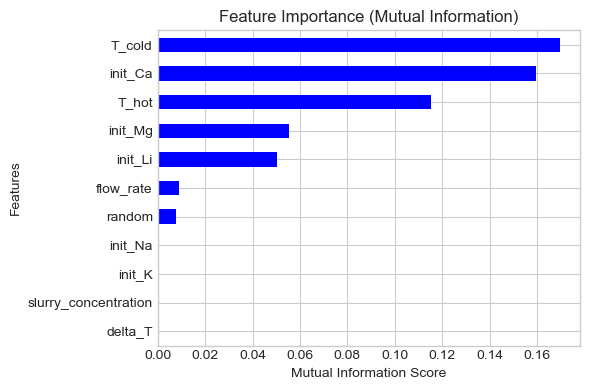

Performing Sensitivity Analysis:


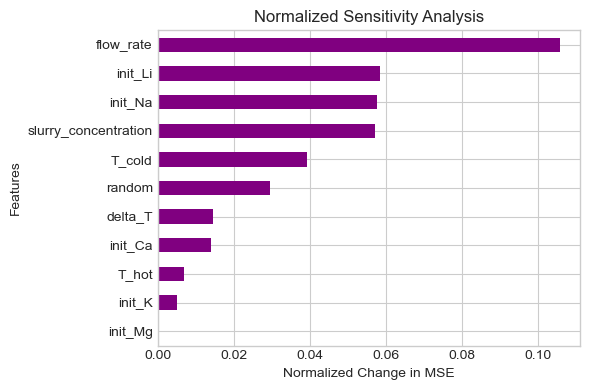

In [17]:
# Define columns for features and targets
feature_columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration', 'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']
target_columns = ['fini_Mg', 'fini_K', 'fini_Li_purity', 'fini_Ca', 'fini_Na']

# Create a copy of the DataFrame
cleaned_data_all_copy = cleaned_data_by_date[0][['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration', 'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na',
                                                 'fini_Mg', 'fini_K', 'fini_Li_purity', 'fini_Ca', 'fini_Na']].copy()

# Add a random feature column
np.random.seed(42)  # for reproducibility
cleaned_data_all_copy['random'] = np.random.random(size=len(cleaned_data_all_copy))

# Include the random column in the feature columns list
feature_columns.append('random')

# Perform analysis for each target
perform_full_analysis(cleaned_data_all_copy, feature_columns, target_columns)

## 4. Exploration Phase: Pareto Frontier Analysis

The exploration phase of our HITL-AL framework aims to efficiently search the vast parameter space to find regions that are promising for achieving our objectives. The primary goal here is to minimize the final concentrations of both Magnesium (`fini_Mg`) and Calcium (`fini_Ca`), the two most challenging impurities.

To do this, we employ a two-step process in each active learning cycle:
1.  **Gaussian Process Regression (GPR)**: We train a GPR model on the accumulated experimental data. This model learns the relationship between the input parameters (temperatures, flow rates, initial concentrations) and the output impurities. The GPR provides not only a prediction but also an uncertainty estimate, which is crucial for exploration.
2.  **Pareto Frontier Extraction (NSGA-II)**: Using the trained GPR model, we predict the outcomes for a large surrogate space of potential experiments (10,000 points generated via Latin Hypercube Sampling). We then use the NSGA-II genetic algorithm to identify the *Pareto frontier*—a set of experimental conditions that represent the optimal trade-offs for minimizing both `fini_Mg` and `fini_Ca` simultaneously. A point is on the Pareto front if you cannot improve one objective without worsening the other.

The following cells demonstrate this process for a single cycle and then visualize the evolution of the Pareto frontier across multiple cycles, showing how the model's understanding improves over time.

### 4.1. Single Cycle Pareto Frontier Extraction Demonstration

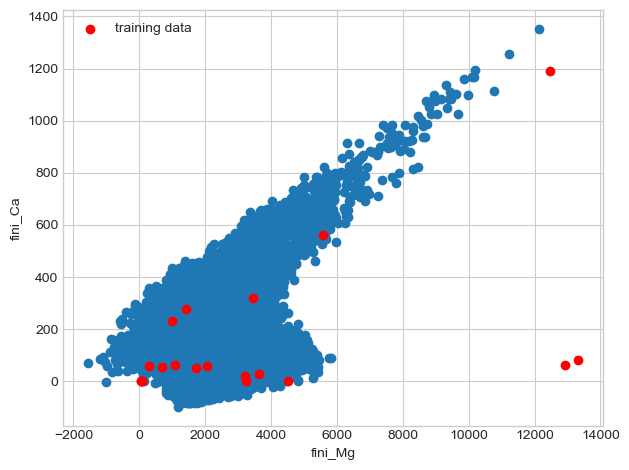

In [18]:
# Load the experimental data captured on 2023-04-04
file_path = "Data\\clean\\2023_04_04_SIFT_cleaned.csv"
data_2023_04_04 = pd.read_csv(file_path)


# Add temperature difference:
data_2023_04_04['delta_T'] = data_2023_04_04['T_hot'] - data_2023_04_04['T_cold'] 

# Clean the data based on the recipe used for 2023-04-04 (in active learning projects your recipe changes from cycle to cycle) 
## Drop unnecessary columns
cleaned_data_2023_04_04 = data_2023_04_04.drop(['init_Li_purity', 'fini_Li_purity', 'init_B',
                                                'init_Si', 'fini_B', 'fini_Si', 'init_Sr', 'fini_Sr',
                                                'scl_Ca', 'scl_K', 'scl_Li', 'scl_Mg', 'scl_Na', 'scl_Sr'], axis=1)
cleaned_data_2023_04_04 = cleaned_data_2023_04_04.dropna()

# Load the experimental grid used for analysing that data 
exp_grid_norm = pd.read_csv('Data\\generated\\Sift_lhs_10000_2023_04_04.csv')
exp_grid_norm['delta_T'] = exp_grid_norm['T_hot'] - exp_grid_norm["T_cold"]

# Define the training and testing data
X_train = cleaned_data_2023_04_04[['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration','init_Ca',
                                 'init_K', 'init_Li', 'init_Mg', 'init_Na']].copy()

y_train = cleaned_data_2023_04_04[['fini_Ca', 'fini_K', 'fini_Li', 'fini_Mg', 'fini_Na']].copy()

X_test = exp_grid_norm[['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration','init_Ca',
                        'init_K', 'init_Li', 'init_Mg', 'init_Na']].copy()

scale = StandardScaler()
scaler = scale.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GPR prediction
gpr_flexible = GaussianProcessRegressor(Matern(length_scale=1, nu=1.5), 
                                        alpha=1e-10,
                                        random_state = 0,
                                        n_restarts_optimizer=10)

gpr_flexible.fit(X_train_scaled, y_train)

y_pred, y_std = gpr_flexible.predict(X_test_scaled, return_std=True)

gpr_pred_df = pd.DataFrame(y_pred, columns=['fini_Ca', 'fini_K', 'fini_Li', 'fini_Mg', 'fini_Na'])

grid_gpr = pd.concat([exp_grid_norm, gpr_pred_df], axis=1)
grid_gpr.head()


# create a new figure
fig, ax = plt.subplots()

# scatter plot with log-scale axes
scatter = ax.scatter(gpr_pred_df['fini_Mg'], gpr_pred_df['fini_Ca'])
ax.set_xscale('linear')
ax.set_yscale('linear')

# add colorbar and labels
# clb = plt.colorbar(scatter)
# clb.ax.set_ylabel('fini_Ca')
plt.xlabel('fini_Mg')
plt.ylabel('fini_Ca')


# plot final Mg threshold: 

plt.scatter(y_train['fini_Mg'], y_train['fini_Ca'], c='r', label='training data')

# set the legend and tighten the layout
plt.legend()
plt.tight_layout()

# show the plot
plt.show()


In [19]:
# The following function call optimizes the Pareto front based on impurity levels
# of magnesium (fini_Mg) and calcium (fini_Ca) using the NSGA-II algorithm.
# It returns two dataframes:
# 1. pareto_front_df – objective-only Pareto front
# 2. grid_gpr_pareto_df – full rows of grid_gpr corresponding to selected Pareto indices

pareto_front_df, grid_gpr_pareto_df = optimize_pareto_front(
    grid_gpr,              # Input dataframe with impurity predictions
    obj1_col="fini_Mg",    # First objective column
    obj2_col="fini_Ca",    # Second objective column
    min_unique_points=30,  # Minimum number of unique Pareto points to collect
    population_size=500,   # Population size for NSGA-II algorithm
    generations=10000      # Number of generations to run per cycle
)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# # Manual Replication of Optimization Workflow without Function

# # Define the objective function to extract fini_Mg and fini_Ca for a given row index
# def objective(x):
#     idx = [int(i) for i in x]  # Ensure index is integer
#     f1 = grid_gpr.loc[idx, 'fini_Mg'].values
#     f2 = grid_gpr.loc[idx, 'fini_Ca'].values
#     return [f1[0], f2[0]]

# # Define the optimization problem: 1 decision variable (row index), 2 objectives
# problem = Problem(1, 2)
# problem.types[:] = Real(0, grid_gpr.shape[0] - 1)
# problem.function = objective

# # Prepare a simplified DataFrame with just the two objective columns
# df = grid_gpr[['fini_Mg', 'fini_Ca']].rename(columns={
#     'fini_Mg': 'obj1',
#     'fini_Ca': 'obj2'
# })

# # Initialize NSGA-II with a specified population size
# algorithm = NSGAII(problem, population_size=500)

# # Track unique Pareto points and their indices
# pareto_front_unique = pd.DataFrame()
# pareto_indices_unique = set()

# # Iterate until enough unique Pareto points are found
# while len(pareto_front_unique) < 30:
#     # Run the optimization algorithm
#     algorithm.run(10000)

#     # Extract the current nondominated (Pareto) solutions
#     front = nondominated(algorithm.result)

#     # Extract corresponding indices of the Pareto front
#     pareto_indices = [int(solution.variables[0]) for solution in front]
#     pareto_indices_unique.update(pareto_indices)

#     # Add the new Pareto rows to the cumulative dataframe
#     pareto_front = df.iloc[pareto_indices]
#     pareto_front_unique = pareto_front_unique.append(pareto_front, ignore_index=False)
#     pareto_front_unique = pareto_front_unique.drop_duplicates()

#     # If too few unique rows are found, reinitialize the optimizer and retry
#     if len(pareto_front_unique) < 30:
#         print("Warning: Found fewer than 30 unique Pareto points. Retrying NSGA-II.")
#         print(f"Current Pareto front length: {len(pareto_front_unique)}")
#         algorithm = NSGAII(problem, population_size=500)


# # Final Output and Display

# # Display the unique Pareto front (objective values only)
# print("Unique Pareto front (first 30 rows):")
# print(pareto_front_unique.head(30))

# # Display full rows of grid_gpr corresponding to unique Pareto indices
# print("\nFull unique rows from grid_gpr:")
# grid_gpr_unique = grid_gpr.iloc[list(pareto_indices_unique)].drop_duplicates()
# print(grid_gpr_unique.head(30))ront_df, grid_gpr_pareto_df = optimize_pareto_front(
#     grid_gpr,
#     obj1_col="fini_Mg",
#     obj2_col="fini_Ca",
#     min_unique_points=30,
#     population_size=500,
#     generations=10000
# )

In [ ]:
from matplotlib import ticker

# create a new figure
fig, ax = plt.subplots()

# scatter plot with log-scale axes
ax.scatter(grid_gpr['fini_Mg'], grid_gpr['fini_Ca'])
ax.scatter(grid_gpr_pareto_df['fini_Mg'], grid_gpr_pareto_df['fini_Ca'], c='cyan', label = 'NSGA-II Pareto frontier')



plt.xlabel('fini_Mg')
plt.ylabel('fini_Ca')


# set the legend and tighten the layout
plt.legend()
plt.tight_layout()

# show the plot
plt.show()

### 4.2. Evolution of Pareto Frontiers

The plot below visualizes the GPR-predicted Pareto frontiers from four different cycles of the active learning process. As more experimental data is gathered, the GPR model becomes more accurate, and the predicted Pareto front shifts towards the bottom-left corner, representing improved (lower) impurity concentrations. This demonstrates the progressive optimization achieved by the HITL-AL framework.

In [ ]:
pareto_files = {
    'Cycle 1': 'Data/generated/AI_suggestions_pareto_2023_03_31.csv',
    'Cycle 2': 'Data/generated/AI_suggestions_pareto_2023_04_04.csv',
    'Cycle 3': 'Data/generated/AI_suggestions_pareto_2023_04_10.csv',
    'Cycle 4': 'Data/generated/AI_suggestions_pareto_2023_04_24.csv'
}

plt.figure(figsize=(10, 7))
colors = plt.cm.plasma(np.linspace(0, 1, len(pareto_files)))

for i, (cycle_name, file_path) in enumerate(pareto_files.items()):
    pareto_df = pd.read_csv(file_path)
    plt.scatter(pareto_df['fini_Mg'], pareto_df['fini_Ca'], color=colors[i], label=cycle_name, s=50, alpha=0.8)

plt.xlabel('Predicted Final Mg (ppm)')
plt.ylabel('Predicted Final Ca (ppm)')
plt.title('Evolution of Pareto Frontiers Over Active Learning Cycles')
plt.legend()
plt.grid(True)
plt.show()

#### 4.2.1. Cycle by Cycle Patero Evolution Demonstratoin

In [ ]:
pareto_03_31 = pd.read_csv('Data/generated/AI_suggestions_pareto_2023_03_31.csv')
pareto_04_04 = pd.read_csv('Data/generated/AI_suggestions_pareto_2023_04_04.csv')
pareto_04_10 = pd.read_csv('Data/generated/AI_suggestions_pareto_2023_04_10.csv')
pareto_04_24 = pd.read_csv('Data/generated/AI_suggestions_pareto_2023_04_24.csv')
pareto_05_04 = pd.read_csv('Data/generated/AI_suggestions_pareto_2023_05_04.csv')

In [ ]:
file_path = 'Data/clean/2023_03_29_SIFT.csv'
file_path_lhs = 'Data/generated/Sift_lhs_10000_2023_03_31.csv'

grid_gpr, X_train, y_train = pareto_gpr_prediction(file_path, file_path_lhs, multi_dimensional = True, delta_T=False, alpha = 1e-5)

print(grid_gpr.shape)

# create a new figure
fig, ax = plt.subplots()

# scatter plot with log-scale axes
scatter = ax.scatter(grid_gpr['fini_Mg'], grid_gpr['fini_Ca'], label = 'GPR')
ax.set_xscale('linear')
ax.set_yscale('linear')

plt.xlabel('fini_Mg')
plt.ylabel('fini_Ca')

plt.scatter(y_train['fini_Mg'], y_train['fini_Ca'], c='r', label='training data')

# set the legend and tighten the layout
plt.legend()
plt.tight_layout()


plt.scatter(pareto_03_31['fini_Mg'], pareto_03_31['fini_Ca'], label='pareto_03_31')
# show the plot
plt.show()

In [ ]:
file_path = "Data\\clean\\2023_04_04_SIFT_cleaned.csv"
file_path_lhs = 'Data\\generated\\Sift_lhs_10000_2023_04_04.csv'

grid_gpr, X_train, y_train = pareto_gpr_prediction(file_path, file_path_lhs, multi_dimensional = True)


print(grid_gpr.shape)

# create a new figure
fig, ax = plt.subplots()

# scatter plot with log-scale axes
scatter = ax.scatter(grid_gpr['fini_Mg'], grid_gpr['fini_Ca'], label = 'GPR')
ax.set_xscale('linear')
ax.set_yscale('linear')

plt.xlabel('fini_Mg')
plt.ylabel('fini_Ca')

plt.scatter(y_train['fini_Mg'], y_train['fini_Ca'], c='r', label='training data')

# set the legend and tighten the layout
plt.legend()
plt.tight_layout()

plt.scatter(pareto_04_04['fini_Mg'], pareto_04_04['fini_Ca'], label='pareto_04_04')

# show the plot
plt.show()

In [ ]:
file_path = "Data\\clean\\2023_04_10_SIFT_cleaned.csv"
file_path_lhs = 'Data\\generated\\Sift_lhs_10000_2023_04_04.csv'

grid_gpr, X_train, y_train = pareto_gpr_prediction(file_path, file_path_lhs, multi_dimensional = True)


print(grid_gpr.shape)

# create a new figure
fig, ax = plt.subplots()

# scatter plot with log-scale axes
scatter = ax.scatter(grid_gpr['fini_Mg'], grid_gpr['fini_Ca'], label = 'GPR')
ax.set_xscale('linear')
ax.set_yscale('linear')

plt.xlabel('fini_Mg')
plt.ylabel('fini_Ca')

plt.scatter(y_train['fini_Mg'], y_train['fini_Ca'], c='r', label='training data')

# set the legend and tighten the layout
plt.legend()
plt.tight_layout()

plt.scatter(pareto_04_10['fini_Mg'], pareto_04_10['fini_Ca'], label='pareto_04_10')

# show the plot
plt.show()

In [ ]:
file_path = "Data\\clean\\2023_04_12_SIFT_cleaned.csv"
file_path_lhs = 'Data\\generated\\Sift_lhs_10000_2023_04_04.csv'

grid_gpr,  X_train, y_train  = pareto_gpr_prediction(file_path, file_path_lhs, multi_dimensional = False, alpha = 1e-5)


print(grid_gpr.shape)

# create a new figure
fig, ax = plt.subplots()

# scatter plot with log-scale axes
scatter = ax.scatter(grid_gpr['fini_Mg'], grid_gpr['fini_Ca'], label = 'GPR')
ax.set_xscale('linear')
ax.set_yscale('linear')

plt.xlabel('fini_Mg')
plt.ylabel('fini_Ca')

plt.scatter(y_train['fini_Mg'], y_train['fini_Ca'], c='r', label='training data')

# set the legend and tighten the layout
plt.legend()
plt.tight_layout()

plt.scatter(pareto_04_24['fini_Mg'], pareto_04_24['fini_Ca'], label='pareto_04_24')


# ax.plot([ppm_threshold('fini_Mg'), ppm_threshold('fini_Mg')], [-50,350] , c='k', label='fini_Mg threshold')
# ax.plot([-50,12500], [ppm_threshold('fini_Ca'), ppm_threshold('fini_Ca')], c='g', label='fini_Ca threshold')

# show the plot
plt.show()

## 5. The "Aha!" Moment: The Random Walk and the Role of $T_{cold}$

Despite progress, reducing Mg impurities below the battery-grade threshold remained a challenge. This led to a key human intervention: questioning the initial assumptions about the parameter space. Experts hypothesized that the model might be stuck in a local minimum and that unexplored regions could hold the key.

To test this, a **random walk algorithm** was deployed. This algorithm generated a new surrogate space of 5,000 points by taking small, random steps (±25%) from the boundaries of the last identified Pareto front. A GPR model, trained on all 36 available experiments, was then used to make predictions on this new "wobbled" space.

The analysis of these predictions revealed a surprising and statistically significant inverse correlation between the cold reactor's temperature ($T_{cold}$) and the final Mg concentration. This contradicted prevailing heuristics and prior literature. The plots below replicate the analysis from Figure 4 in the paper, clearly showing this crucial insight.

In [ ]:
# Load the pre-generated wobbled pareto data
wobbled_pareto_data = pd.read_csv('Data/generated/wobbled_pareto_2023_04_24.csv')

# Define features and target
feature_columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration', 'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']
target_columns = ['fini_Mg']

# Add a random feature for baseline comparison
wobbled_pareto_data['random'] = np.random.random(size=len(wobbled_pareto_data))
feature_columns_with_random = feature_columns + ['random']

# Perform analysis on the GPR predictions from the wobbled data
print("Analysis of GPR Predictions on Wobbled Pareto Frontier Data")
perform_full_analysis(wobbled_pareto_data, feature_columns_with_random, target_columns)

In [ ]:
wobbled_pareto_2023_04_24 = pd.read_csv('Data\\generated\\wobbled_pareto_2023_04_24.csv')

In [ ]:
# plot pearson correlatino matrix: 
plt.figure(figsize=(12, 8))
# Use fmt='.2f' to format the annotation to 2 decimal places
sns.heatmap(wobbled_pareto_2023_04_24.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

The analyses above clearly demonstrate that `T_cold` has the strongest negative correlation and highest feature importance for reducing `fini_Mg`, an insight that was not apparent from the initial data but was uncovered through this human-guided exploration.

### 5.1. Experimental Validation

Prompted by this model-derived insight, human experts designed a validation experiment to directly test the hypothesis. Two experiments were run with identical initial conditions, but one with a low $T_{cold}$ (10°C) and one with a high $T_{cold}$ (68°C). The results, mirroring Figure 5 in the paper, dramatically confirmed the model's prediction: the higher cold reactor temperature led to a remarkable reduction in Mg impurities, achieving the battery-grade target.

#### Bar Plets: One by One Comparison

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the elements to compare
elements = ['Ca', 'Mg', 'K', 'Na'] # 'Li', 'Mg', 

# Select the rows for 'Sift-099' and 'Sift-100'
comparison_row_1 = cleaned_data[cleaned_data['experiment_id'] == 'Sift-099']
comparison_row_2 = cleaned_data[cleaned_data['experiment_id'] == 'Sift-100']

# Define distinct colors for initial and final values
color_init = 'green'
color_fini_1 = 'blue'
color_fini_2 = 'maroon'

# Plotting
fig, axs = plt.subplots(1, len(elements), figsize=(25, 8))

# Plot each element separately
for i, element in enumerate(elements):
    ax = axs[i]

    # Get the initial and final values for the current element from both rows
    init_values_1 = comparison_row_1[f'init_{element}'].values[0]
    fini_values_1 = comparison_row_1[f'fini_{element}'].values[0]
    fini_values_2 = comparison_row_2[f'fini_{element}'].values[0]

    # Calculate the percentage of the removed element
    removed_percentage_1 = ((init_values_1 - fini_values_1) / init_values_1) * 100
    removed_percentage_2 = ((init_values_1 - fini_values_2) / init_values_1) * 100

    # Plot bars for initial and final values with distinct colors
    ax.bar([0], [init_values_1], color=color_init, label=f'Initial')
    ax.bar([1], [fini_values_1], color=color_fini_1, label=f'Sift-099 Final')
    ax.bar([2], [fini_values_2], color=color_fini_2, label=f'Sift-100 Final')

    # Add ppm notation on top of each bar
    ax.text(0, init_values_1 + init_values_1/100, f'{init_values_1} ppm', ha='center', fontsize=12)
    ax.text(1, fini_values_1 + init_values_1/100, f'{fini_values_1} ppm', ha='center', fontsize=12)
    ax.text(2, fini_values_2 + init_values_1/100, f'{fini_values_2} ppm', ha='center', fontsize=12)
    

    # Add annotations for the removed element percentage
    ax.text(1, fini_values_1 + init_values_1/25, f'{removed_percentage_1:.2f}%', ha='center', fontsize=12, color='blue')
    ax.text(2, fini_values_2 + init_values_1/25, f'{removed_percentage_2:.2f}%', ha='center', fontsize=12, color='maroon')

    # Set labels and title
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Initial', 'Sift-099 Final', 'Sift-100 Final'], rotation=45)
    ax.set_title(f'Comparison of Initial vs Final Values for {element}')
    ax.set_ylabel('Values (ppm)')
    ax.legend()
    
    # Print all the ppm values and removed_percentages:
    print('init: ', init_values_1)
    print('fini_1: ', fini_values_1)
    print('%_1: ', removed_percentage_1)
    
    print('fini_2: ', fini_values_2)
    print('%_2: ', removed_percentage_2)
    
    # Print T_cold and T_hot values
    print('T_cold:', comparison_row_1['T_cold'].values[0])
    print('T_hot:', comparison_row_1['T_hot'].values[0])
    
    # Now for the comparison_row_2
    print('T_cold:', comparison_row_2['T_cold'].values[0])
    print('T_hot:', comparison_row_2['T_hot'].values[0])


plt.tight_layout()
plt.show()


In [ ]:
# Experiments #38 and #39 from Table S4
exp_high_T_cold = cleaned_data.iloc[37]
exp_low_T_cold = cleaned_data.iloc[38]

bar_labels = ['Initial', f"Final (T_cold={exp_low_T_cold['T_cold']:.0f}°C)", f"Final (T_cold={exp_high_T_cold['T_cold']:.0f}°C)"]
mg_values = [exp_high_T_cold['init_Mg'], exp_low_T_cold['fini_Mg'], exp_high_T_cold['fini_Mg']]
ca_values = [exp_high_T_cold['init_Ca'], exp_low_T_cold['fini_Ca'], exp_high_T_cold['fini_Ca']]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Magnesium plot
axs[0].bar(bar_labels, mg_values, color=['gray', 'lightcoral', 'skyblue'])
axs[0].axhline(y=ppm_threshold('fini_Mg'), color='r', linestyle='--', label='Mg Battery Grade Threshold (80 ppm)')
axs[0].set_ylabel('Concentration (ppm)')
axs[0].set_title('Impact of $T_{cold}$ on Final Mg Concentration')
axs[0].legend()

# Calcium plot
axs[1].bar(bar_labels, ca_values, color=['gray', 'lightcoral', 'skyblue'])
axs[1].axhline(y=ppm_threshold('fini_Ca'), color='r', linestyle='--', label='Ca Battery Grade Threshold (160 ppm)')
axs[1].set_ylabel('Concentration (ppm)')
axs[1].set_title('Impact of $T_{cold}$ on Final Ca Concentration')
axs[1].legend()

plt.tight_layout()
plt.show()

#### KDE Plots: Distribution Comparison

In [ ]:
# List of columns to plot
columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration',
           'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']

X_train_kde_plot = cleaned_data_all[['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration',
           'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']].copy()
y_train_kde_plot = cleaned_data_all[['fini_Mg', 'fini_Ca', 'fini_K', 'fini_Li', 'fini_Na', 'bg']].copy()   
new_x_train = X_train_kde_plot.copy()
new_y_train = y_train_kde_plot.copy()
new_y_train['bg'] = new_y_train['bg'] = new_y_train['fini_Mg'] < 80
new_data_df = pd.concat([new_x_train, new_y_train], axis=1)
new_data_df_bg = new_data_df[new_data_df['bg']==True]
new_data_df_nonbg = new_data_df[new_data_df['bg']==False]

##### All Data: No Boundaries

In [ ]:
# List of columns to plot for distribution analysis
columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration',
           'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']

# Create subplots with 2 rows and 5 columns for better visualization
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))

# Iterate over each column and plot its distribution in the corresponding subplot
for i, column in enumerate(columns):
    # Determine the row and column index for subplot positioning
    row = i // 5  # Integer division to get row index (0 or 1)
    col = i % 5   # Modulo operation to get column index (0 to 4)
    ax = axes[row, col]  # Get the corresponding axis
    
    # Plot the KDE plot for the battery grade data (new_data_df_bg).
    # No bounds are applied; the entire dataset is used.
    sns.kdeplot(new_data_df_bg[column], color='blue', alpha=0.5, ax=ax, label='Battery Grade')
    
    # Plot the KDE plot for the non-battery grade data (new_data_df_nonbg).
    # No bounds are applied; the entire dataset is used.
    sns.kdeplot(new_data_df_nonbg[column], color='orange', alpha=0.5, ax=ax, label='Non-Battery Grade')
    
    # Set plot properties for title, labels, and legend
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# Adjust spacing between subplots to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

##### Initial Mg Within Bounds

In [ ]:
# List of columns to plot for distribution analysis
columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration',
           'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']

# Create subplots with 2 rows and 5 columns for better visualization
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(columns):
    # Determine the row and column index for subplot positioning
    row = i // 5  # Integer division to get row index (0 or 1)
    col = i % 5   # Modulo operation to get column index (0 to 4)
    ax = axes[row, col]  # Get the corresponding axis
    
    # Plot the KDE plot for battery grade data (BG=True) with filtering conditions:
    # - init_Mg must be below 12000 (upper bound)
    # - init_Mg must be above 200 (lower bound)
    filtered_bg = new_data_df_bg[
        (new_data_df_bg['init_Mg'] < 12000) & 
        (new_data_df_bg['init_Mg'] > 80)
    ]
    sns.kdeplot(filtered_bg[column], color='blue', alpha=0.5, ax=ax, label='Battery Grade (200 < init_Mg < 12000)')
    
    # Plot the KDE plot for non-battery grade data with the same filtering conditions:
    # - init_Mg must be below 12000 (upper bound)
    # - init_Mg must be above 200 (lower bound)
    filtered_nonbg = new_data_df_nonbg[
        (new_data_df_nonbg['init_Mg'] < 12000) & 
        (new_data_df_nonbg['init_Mg'] > 80)
    ]
    sns.kdeplot(filtered_nonbg[column], color='orange', alpha=0.5, ax=ax, label='Non-Battery Grade (200 < init_Mg < 12000)')
    
    # Set plot properties
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# Adjust spacing between subplots for better layout
plt.tight_layout()
plt.show()

## 6. Exploitation Phase: Decision Boundary Refinement

With the critical role of $T_{cold}$ validated, the strategy shifted from exploration to **exploitation**. The new objective was to precisely map the decision boundary between battery-grade and non-battery-grade outcomes, focusing on the interplay between initial Mg concentration and cold reactor temperature.

### 6.1. Gaussian Process Classification (GPC)

As detailed in the paper's methods section and Table S6, we employed a **Gaussian Process Classifier (GPC)** for this task. Unlike GPR, which predicts a continuous value, GPC predicts the probability of a data point belonging to a specific class (in this case, `bg=0` for battery-grade). We used a sophisticated kernel (`ConstantKernel * (Matern + WhiteKernel)`) to capture the complex, non-linear boundary.

The plot below (replicating Figure 7) shows the GPC model's predictions projected onto the `init_Mg` vs. `T_cold` plane. The red dashed line represents the decision boundary (50% probability), effectively separating the parameter space into predicted battery-grade (purple) and non-battery-grade (yellow) regions. The experimental data points are overlaid, showing a strong agreement between the model and observed reality.

In [ ]:
cleaned_data['bg'] = np.where(cleaned_data['fini_Mg'] < 80, 1, 0)

In [ ]:

# Prepare training data for classification
X_train_cls = cleaned_data[['T_cold', 'init_Mg']].copy()
y_train_cls = cleaned_data['bg'].copy()

# Scale the features
scaler_cls = StandardScaler().fit(X_train_cls)
X_train_cls_scaled = scaler_cls.transform(X_train_cls)

# Define the complex kernel for GPC
kernel_gpc = ConstantKernel(1.0) * (Matern(length_scale=[0.3, 0.3], nu=1.5) + WhiteKernel(noise_level=0.06))

# Train GPC model
gpc_model = GaussianProcessClassifier(kernel=kernel_gpc, n_restarts_optimizer=10, max_iter_predict=100, random_state=42)
gpc_model.fit(X_train_cls_scaled, y_train_cls)

# Create 2D mesh for plotting the decision boundary
T_cold_range = np.linspace(X_train_cls['T_cold'].min(), X_train_cls['T_cold'].max(), 100)
init_Mg_range = np.linspace(0, 12000, 100)
T_cold_mesh, init_Mg_mesh = np.meshgrid(T_cold_range, init_Mg_range)
mesh_data = np.vstack([T_cold_mesh.ravel(), init_Mg_mesh.ravel()]).T
mesh_data_scaled = scaler_cls.transform(mesh_data)

# Predict probabilities on the mesh
prob_mesh = gpc_model.predict_proba(mesh_data_scaled)[:, 1].reshape(T_cold_mesh.shape)

# Plot the results
plt.figure(figsize=(8, 6))
contour = plt.contourf(T_cold_mesh, init_Mg_mesh, prob_mesh, cmap='viridis', alpha=0.7, levels=np.linspace(0, 1, 11))
plt.colorbar(contour, label='Probability of Non-Battery Grade')
plt.contour(T_cold_mesh, init_Mg_mesh, prob_mesh, levels=[0.5], colors='red', linestyles='--', linewidths=2, label='Decision Boundary')

# Plot battery grade and non-battery grade separately for legend clarity
battery_mask = y_train_cls == 0
non_battery_mask = y_train_cls == 1
plt.scatter(
    X_train_cls.loc[battery_mask, 'T_cold'], X_train_cls.loc[battery_mask, 'init_Mg'],
    c='red', edgecolors='k', s=50, label='Non-Battery Grade (red circles)'
)
plt.scatter(
    X_train_cls.loc[non_battery_mask, 'T_cold'], X_train_cls.loc[non_battery_mask, 'init_Mg'],
    c='blue', edgecolors='k', s=50, label='Battery Grade (blue circles)'
)

plt.xlabel('Cold Reactor Temperature (°C)')
plt.ylabel('Initial Mg Concentration (ppm)')
plt.title('GPC Decision Boundary for Battery-Grade Outcomes')
plt.ylim(0, 12000)
plt.legend()
plt.show()

### 6.2. Ray Tracing for Experiment Suggestion

To further refine the decision boundary with maximum efficiency, we used a ray-tracing-inspired algorithm. This method identifies pairs of nearest-neighboring battery-grade and non-battery-grade experiments and calculates their mathematical midpoint. The midpoints lying closest to the GPC's 0.5 probability boundary are then suggested as the next set of experiments to run.

The plot below visualizes this process. It shows the experimental data, the GPC decision boundary, and the proposed new experiments (green triangles) located strategically to provide the most information for refining the boundary.

#### Decision Boundary Exploitation Using GPC

In [ ]:
# Ray Tracing for finding midpoint suggestions
feature_columns_distance = ['T_cold', 'init_Mg']

battery_grade_df = cleaned_data[cleaned_data['bg']==0][feature_columns_distance].copy()
non_battery_grade_df = cleaned_data[cleaned_data['bg']==1][feature_columns_distance].copy()

suggestion_df = pd.DataFrame()
for i_bg, row_bg in battery_grade_df.iterrows():
    for i_non_bg, row_non_bg in non_battery_grade_df.iterrows():
        new_row = (row_bg + row_non_bg) / 2
        suggestion_df = suggestion_df.append(new_row, ignore_index=True)

# Filter suggestions to those near the boundary
suggestion_df_scaled = scaler_cls.transform(suggestion_df)
suggestion_probs = gpc_model.predict_proba(suggestion_df_scaled)[:, 1]
near_boundary_data = suggestion_df[np.abs(suggestion_probs - 0.5) < 0.1]

# Re-plot with suggestions
plt.figure(figsize=(8, 6))
plt.contour(T_cold_mesh, init_Mg_mesh, prob_mesh, levels=[0.5], colors='red', linestyles='--', linewidths=2, label='Decision Boundary')
plt.scatter(X_train_cls['T_cold'], X_train_cls['init_Mg'], c=y_train_cls, cmap='coolwarm', edgecolors='k', s=50, label='Experimental Data')
plt.scatter(near_boundary_data['T_cold'], near_boundary_data['init_Mg'], c='green', marker='^', s=80, edgecolors='k', label='Ray Tracing Suggestions')

plt.xlabel('Cold Reactor Temperature (°C)')
plt.ylabel('Initial Mg Concentration (ppm)')
plt.title('Ray Tracing Experiment Suggestions Near Decision Boundary')
plt.ylim(0, 12000)
plt.legend()
plt.show()

#### Step-by-Step Ray Tracing and Decision Boundary Extraction Using GPR (to show case) and GPC

In [ ]:
from matplotlib.lines import Line2D
# Step 1: Create binary classification label for battery-grade
train_set = cleaned_data.copy()
train_set['bg'] = np.where(train_set['fini_Mg'] < 80, 0, 1)

# Step 2: Select features and target
X_train_raytracing = train_set[['T_cold', 'init_Mg']]
y_train_raytracing = train_set['bg']

# Step 3: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raytracing)

# Step 4: Create 2D meshgrid for T_cold and init_Mg
T_cold_range = np.linspace(X_train_raytracing['T_cold'].min(), X_train_raytracing['T_cold'].max(), 500)
init_Mg_range = np.linspace(-500, 12000, 500)
T_cold_mesh, init_Mg_mesh = np.meshgrid(T_cold_range, init_Mg_range)
mesh_points = np.vstack([T_cold_mesh.ravel(), init_Mg_mesh.ravel()]).T
mesh_points_scaled = scaler.transform(mesh_points)

# Step 5: Train GPR
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=[0.3, 0.3]), alpha=0.06)
gpr.fit(X_train_scaled, y_train_raytracing)
gpr_probs = gpr.predict(mesh_points_scaled).reshape(T_cold_mesh.shape)

# Step 6: Train GPC
gpc_kernel = ConstantKernel(1.0) * (Matern(length_scale=[0.3, 0.3], nu=1.5) + WhiteKernel(noise_level=0.06))
gpc = GaussianProcessClassifier(kernel=gpc_kernel, n_restarts_optimizer=10, max_iter_predict=100)
gpc.fit(X_train_scaled, y_train_raytracing)
gpc_probs = gpc.predict_proba(mesh_points_scaled)[:, 1].reshape(T_cold_mesh.shape)

# Step 7: Transform and score suggestions
X_sugg_scaled = scaler.transform(suggestion_df[['T_cold', 'init_Mg']])
gpr_sugg_probs = gpr.predict(X_sugg_scaled)
gpc_sugg_probs = gpc.predict_proba(X_sugg_scaled)[:, 1]
near_gpr = suggestion_df[np.abs(gpr_sugg_probs - 0.5) < 0.05]
near_gpc = suggestion_df[np.abs(gpc_sugg_probs - 0.5) < 0.05]

# Custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Battery Grade (0)', markerfacecolor='purple', markeredgecolor='k', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='Non-Battery Grade (1)', markerfacecolor='yellowgreen', markeredgecolor='k', markersize=7),
    Line2D([0], [0], marker='x', color='green', label='Suggestions', linestyle='None', markersize=8),
    Line2D([0], [0], marker='^', color='orange', label='Near Boundary Suggestions', markeredgecolor='k', linestyle='None', markersize=10),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='GPR Boundary'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='GPC Boundary')
]

# Plot 1: GPR Decision Boundary
plt.figure(figsize=(5, 4))
plt.contour(T_cold_mesh, init_Mg_mesh, gpr_probs, levels=[0.5], colors='red', linestyles='--', linewidths=2)
scatter = plt.scatter(X_train_raytracing['T_cold'], X_train_raytracing['init_Mg'], c=y_train_raytracing, cmap='viridis', edgecolors='k', s=30)
plt.colorbar(scatter, ticks=[0, 1]).set_label('Battery Grade')
plt.title('GPR Decision Boundary')
plt.xlabel('T_cold'); plt.ylabel('init_Mg')
plt.ylim(-500, 12000)
plt.legend(handles=legend_elements[:2] + [legend_elements[4]])
plt.tight_layout(); plt.show()

# Plot 2: GPR + Suggestions
plt.figure(figsize=(5, 4))
plt.contour(T_cold_mesh, init_Mg_mesh, gpr_probs, levels=[0.5], colors='red', linestyles='--', linewidths=2)
plt.scatter(X_train_raytracing['T_cold'], X_train_raytracing['init_Mg'], c=y_train_raytracing, cmap='viridis', edgecolors='k', s=30)
plt.scatter(suggestion_df['T_cold'], suggestion_df['init_Mg'], c='green', marker='x', s=30)
plt.colorbar(scatter, ticks=[0, 1]).set_label('Battery Grade')
plt.title('GPR + Suggested Experiments')
plt.xlabel('T_cold'); plt.ylabel('init_Mg')
plt.legend(handles=legend_elements[:3] + [legend_elements[4]])
plt.ylim(-500, 12000); plt.tight_layout(); plt.show()

# Plot 3: GPR Near-Boundary
plt.figure(figsize=(5, 4))
plt.contour(T_cold_mesh, init_Mg_mesh, gpr_probs, levels=[0.5], colors='red', linestyles='--', linewidths=2)
plt.scatter(X_train_raytracing['T_cold'], X_train_raytracing['init_Mg'], c=y_train_raytracing, cmap='viridis', edgecolors='k', s=30)
plt.scatter(near_gpr['T_cold'], near_gpr['init_Mg'], color='orange', marker='^', s=70, edgecolors='k')
plt.colorbar(scatter, ticks=[0, 1]).set_label('Battery Grade')
plt.title('GPR Near-Decision Suggestions')
plt.xlabel('T_cold'); plt.ylabel('init_Mg')
plt.legend(handles=legend_elements[:-1])
plt.ylim(-500, 12000); plt.tight_layout(); plt.show()

# Plot 4: GPC Decision Boundary
plt.figure(figsize=(5, 4))
plt.contour(T_cold_mesh, init_Mg_mesh, gpc_probs, levels=[0.5], colors='blue', linestyles='--', linewidths=2)
scatter = plt.scatter(X_train_raytracing['T_cold'], X_train_raytracing['init_Mg'], c=y_train_raytracing, cmap='viridis', edgecolors='k', s=30)
plt.colorbar(scatter, ticks=[0, 1]).set_label('Battery Grade')
plt.title('GPC Decision Boundary')
plt.xlabel('T_cold'); plt.ylabel('init_Mg')
plt.legend(handles=legend_elements[:2] + [legend_elements[5]])
plt.ylim(-500, 12000); plt.tight_layout(); plt.show()

# Plot 5: GPC + Suggestions
plt.figure(figsize=(5, 4))
plt.contour(T_cold_mesh, init_Mg_mesh, gpc_probs, levels=[0.5], colors='blue', linestyles='--', linewidths=2)
plt.scatter(X_train_raytracing['T_cold'], X_train_raytracing['init_Mg'], c=y_train_raytracing, cmap='viridis', edgecolors='k', s=30)
plt.scatter(suggestion_df['T_cold'], suggestion_df['init_Mg'], c='green', marker='x', s=30)
plt.colorbar(scatter, ticks=[0, 1]).set_label('Battery Grade')
plt.title('GPC + Suggested Experiments')
plt.xlabel('T_cold'); plt.ylabel('init_Mg')
plt.legend(handles=legend_elements[:3] + [legend_elements[5]])
plt.ylim(-500, 12000); plt.tight_layout(); plt.show()

# Plot 6: GPC Near-Boundary
plt.figure(figsize=(5, 4))
plt.contour(T_cold_mesh, init_Mg_mesh, gpc_probs, levels=[0.5], colors='blue', linestyles='--', linewidths=2)
plt.scatter(X_train_raytracing['T_cold'], X_train_raytracing['init_Mg'], c=y_train_raytracing, cmap='viridis', edgecolors='k', s=30)
plt.scatter(near_gpc['T_cold'], near_gpc['init_Mg'], color='orange', marker='^', s=70, edgecolors='k')
plt.colorbar(scatter, ticks=[0, 1]).set_label('Battery Grade')
plt.title('GPC Near-Decision Suggestions')
plt.xlabel('T_cold'); plt.ylabel('init_Mg')
plt.legend(handles=legend_elements[:-2] + [legend_elements[5]])
plt.ylim(-500, 12000); plt.tight_layout(); plt.show()

## 7. Final Results and Analysis

This section presents the final analyses performed on the complete dataset of 80 experiments, corresponding to Figure 8 in the paper. We examine the distributions of key parameters for battery-grade versus non-battery-grade outcomes and conduct a final feature importance analysis to confirm our findings.

In [ ]:
if 'cleaned_data_all' in locals() and not cleaned_data_all.empty:
    find_missing_data(cleaned_data_all)

    feature_columns = ['T_cold', 'T_hot', 'delta_T', 'flow_rate', 'slurry_concentration', 'init_Ca', 'init_K', 'init_Li', 'init_Mg', 'init_Na']
    target_columns_mg = ['fini_Mg']
    analysis_df_mg = cleaned_data_all.copy()
    analysis_df_mg['random'] = np.random.random(size=len(analysis_df_mg))
    feature_columns_with_random = feature_columns + ['random']
    
    # Perform analysis for Final Mg Concentration
    perform_full_analysis(analysis_df_mg.dropna(subset=feature_columns_with_random + target_columns_mg), 
                          feature_columns_with_random, 
                          target_columns_mg)

    # Perform analysis for Battery Grade Label
    target_columns_bg = ['bg']
    analysis_df_bg = cleaned_data_all.copy().dropna(subset=feature_columns + target_columns_bg)
    analysis_df_bg['random'] = np.random.random(size=len(analysis_df_bg))
    perform_full_analysis(analysis_df_bg, feature_columns_with_random, target_columns_bg)
else:
    print("Skipping analysis because data was not loaded.")

## 8. Comparative Simulation

To quantify the benefit of the HITL-AL approach, we conducted a computational experiment comparing its efficacy against two non-human-in-the-loop active learning frameworks, as shown in Figure 9 of the paper. We created a large surrogate dataset of 10,000,000 simulated experiments, labeled using a GPC model trained on our final data. We then created two versions of this dataset:

-   **Uninformed Dataset**: Adheres to the initial, broad parameter ranges.
-   **Informed Dataset**: Constrained by the optimal temperature ranges discovered during the HITL-AL process.

We then simulated three data acquisition strategies over 100 trials each:
1.  **HITL-AL**: Our result, finding battery-grade conditions in 38 experiments.
2.  **Simplified Bayesian Optimization**: An automated approach using Upper Confidence Bound (UCB) to select experiments.
3.  **Random Sampling**: A baseline approach selecting experiments randomly.

The plot below shows the success rate of each method in identifying a battery-grade condition within 40 experiments. The results clearly show that incorporating human-derived knowledge (`Informed` datasets) dramatically improves the performance of automated methods, and that the HITL-AL approach was highly effective.

### 8.1. Detailed Comparative Analysis: Loading and Plotting Results

In this section, we demonstrate how to load the detailed simulation results and create comprehensive polynomial fit analyses that show the convergence behavior of different active learning strategies over time. This analysis provides deeper insights into the performance characteristics of each method beyond simple success rates.

#### 8.1.1. Loading Simulation Data and Creating Polynomial Fit Plots

The following cell loads the detailed simulation results from the computational experiments and creates polynomial fit plots with confidence intervals. This analysis shows how each method's success rate evolves as the number of experiments increases, providing insights into the learning efficiency and convergence behavior of different approaches.

In [ ]:
def fit_and_predict_poly(x, y, degree, num_points=100):
    """
    Fit a polynomial to the data and predict with confidence intervals.
    
    This function performs polynomial regression and calculates prediction uncertainty
    using the residual variance and design matrix approach.
    
    Parameters:
    -----------
    x : array-like
        Input features (number of experiments)
    y : array-like
        Target values (success rates)
    degree : int
        Degree of polynomial to fit
    num_points : int
        Number of points for prediction
    
    Returns:
    --------
    x_pred : array
        Prediction x values
    y_pred : array
        Predicted y values
    std_pred : array
        Standard deviation of predictions (confidence intervals)
    """
    coeffs, residuals, _, _, _ = np.polyfit(x, y, degree, full=True)
    poly = np.poly1d(coeffs)
    x_pred = np.linspace(min(x), max(x), num_points)
    y_pred = poly(x_pred)
    residual_variance = residuals / (len(y) - (degree + 1))
    X_design = np.vander(x_pred, N=degree + 1)
    prediction_variance = np.dot(X_design, np.dot(np.linalg.pinv(np.dot(X_design.T, X_design)), X_design.T)) * residual_variance
    std_pred = np.sqrt(np.diag(prediction_variance))
    return x_pred, y_pred, std_pred

# Load detailed simulation results
print("Loading detailed simulation results...")

# Check if .npy files exist and load them
try:
    bayesian_outcome_inf = np.load('Data\\generated\\comparative_analysis\\bayesian_outcome_inf.npy')
    bayesian_outcome_uninf = np.load('Data\\generated\\comparative_analysis\\bayesian_outcome_uninf.npy')
    random_aq_ap2_inf = np.load('Data\\generated\\comparative_analysis\\random_aq_ap2_inf.npy')
    random_aq_ap2_uninf = np.load('Data\\generated\\comparative_analysis\\random_aq_ap2_uninf.npy')
    
    print("✓ Successfully loaded all simulation data files")
    print(f"  - Bayesian Informed: {len(bayesian_outcome_inf)} experiments")
    print(f"  - Bayesian Uninformed: {len(bayesian_outcome_uninf)} experiments")
    print(f"  - Random Informed: {len(random_aq_ap2_inf)} experiments")
    print(f"  - Random Uninformed: {len(random_aq_ap2_uninf)} experiments")
    
    # Create x_values (number of experiments)
    x_values = np.arange(100)
    
    # Create comprehensive polynomial fit plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define colors, labels, and markers for each dataset
    colors = ['red', 'green', 'blue', 'purple']
    labels = ["Bayesian - Informed", "Bayesian - Uninformed", "Random - Informed", "Random - Uninformed"]
    datasets = [bayesian_outcome_inf, bayesian_outcome_uninf, random_aq_ap2_inf, random_aq_ap2_uninf]
    markers = ['o', 's', '^', 'x']  # Different markers for each dataset
    
    # Fit polynomial and plot for each dataset
    degree = 4  # 4th degree polynomial for smooth fitting
    for data, color, label, marker in zip(datasets, colors, labels, markers):
        # Fit polynomial and get predictions with confidence intervals
        x_pred, y_pred, std = fit_and_predict_poly(x_values, data, degree)
        
        # Plot original data points
        ax.plot(x_values, data, marker, color=color, markersize=4, label=f'{label}')
        
        # Plot polynomial fit line
        ax.plot(x_pred, y_pred, '-', color=color, linewidth=2, label=f'Polynomial Fit - {label}')
        
        # Plot confidence intervals (95% confidence)
        ax.fill_between(x_pred, y_pred - 1.96 * std, y_pred + 1.96 * std, 
                       color=color, alpha=0.2, label=f'95% CI - {label}')
    
    # Customize the plot
    ax.set_xlabel('Number of Experiments', fontsize=12)
    ax.set_ylabel('Success Rate (Count)', fontsize=12)
    ax.set_title('Comparative Analysis: Active Learning Strategy Performance\nPolynomial Fits with 95% Confidence Intervals', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, max([max(d) for d in datasets]) * 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis at specific point
    print("\n" + "="*60)
    print("DETAILED ANALYSIS AT x = 38 EXPERIMENTS")
    print("="*60)
    x_point = 38
    for data, label in zip(datasets, labels):
        coeffs, residuals, _, _, _ = np.polyfit(x_values, data, degree, full=True)
        poly = np.poly1d(coeffs)
        X_design_point = np.vander([x_point], N=degree + 1)
        residual_variance = residuals / (len(data) - (degree + 1))
        prediction_variance = np.dot(X_design_point, np.dot(np.linalg.pinv(np.dot(X_design_point.T, X_design_point)), X_design_point.T)) * residual_variance
        std_point = np.sqrt(prediction_variance)
        predicted_value = poly(x_point)
        print(f"{label:25s} - Success Rate: {predicted_value:6.2f} ± {std_point[0][0]:.2f} (95% CI)")
    
    # Create the second plot with highlighted analysis point
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for data, color, label, marker in zip(datasets, colors, labels, markers):
        x_pred, y_pred, std = fit_and_predict_poly(x_values, data, degree)
        ax.plot(x_values, data, marker, color=color, markersize=4, label=f'{label}')
        ax.plot(x_pred, y_pred, '-', color=color, linewidth=2, label=f'Polynomial Fit - {label}')
        ax.fill_between(x_pred, y_pred - 1.96 * std, y_pred + 1.96 * std, color=color, alpha=0.2)
    
    # Highlight specific analysis point (x=40 as mentioned in the paper)
    ax.axvline(x=40, color='black', linestyle='--', linewidth=3, label='Analysis Point (x=40) - HITL Success Point')
    
    ax.set_xlim(0, 100)
    ax.set_ylim(-1, 100)
    ax.set_xlabel('Number of Experiments', fontsize=12)
    ax.set_ylabel('Success Rate (Count)', fontsize=12)
    ax.set_title('Comparative Analysis with Highlighted Performance Threshold\n(40 Experiments = HITL-AL Achievement)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Polynomial fit analysis completed successfully!")
    print("  - Red: Bayesian Informed (best performance)")
    print("  - Green: Bayesian Uninformed (good performance)")
    print("  - Blue: Random Informed (moderate performance)")
    print("  - Purple: Random Uninformed (baseline performance)")
    
except FileNotFoundError as e:
    print(f"⚠️  Warning: {e}")
    print("   The detailed simulation data files (.npy) are not available.")
    print("   This analysis requires the results from the computational experiments.")
    print("   Please ensure the following files are in the current directory:")
    print("   - bayesian_outcome_inf.npy")
    print("   - bayesian_outcome_uninf.npy")
    print("   - random_aq_ap2_inf.npy")
    print("   - random_aq_ap2_uninf.npy")

### 8.2 Comparative Analysis: HITL vs Bayesian vs Random Sampling in Informed and Uninformed Scenarios

This section demonstrates the complete pipeline for comparing Bayesian active learning with random sampling in both informed and uninformed experimental setups. We'll show how the system learns to find successful crystallization conditions through iterative sampling.

#### 8.2.1 Informed Scenario: Full Parameter Range Knowledge

First, let's set up the informed scenario where we have complete knowledge of the parameter ranges and boundaries.

In [ ]:
# Define the parameter bounds for informed scenario
bounds_ap2_inf = {
    "T_cold": (5, 80),
    "T_hot": (6, 90),  # Increased upper limit by 20C for later adjustment
    "flow_rate": (0.5, 6),
    "slurry_concentration": (1.5, 10),
    "init_Ca": (2000, 300000),  # Adjusted for +/- 30%
    "init_K": (100, 5000),      # Adjusted for +/- 30%
    "init_Li": (2000, 200000), # Adjusted for +/- 30%
    "init_Mg": (10, 100000),      # Adjusted for +/- 30%
    "init_Na": (100, 20000)     # Adjusted for +/- 30%
}

# Generate surrogate data using Latin Hypercube Sampling
surrogate_data = sift_lhs_sample(10_000_000, bounds=bounds_ap2_inf, lhs_sampler=False, delta_T=0, seed=0)

# Ensure T_cold is not higher than T_hot by swapping if needed
mask = surrogate_data['T_cold'] > surrogate_data['T_hot']
surrogate_data.loc[mask, ['T_cold', 'T_hot']] = surrogate_data.loc[mask, ['T_hot', 'T_cold']].values
surrogate_data['T_hot'] = surrogate_data['T_hot'] + 5  # Increase T_hot by 5C
surrogate_data['delta_T'] = surrogate_data['T_hot'] - surrogate_data['T_cold']

print(f"Generated {len(surrogate_data):,} surrogate data points for informed scenario")
print(f"Parameter ranges: {surrogate_data.describe()}")

#### 8.2.2 Surrogate Model Training with Gaussian Process Classification

Now we'll train a Gaussian Process Classification model on our experimental data to predict success probability in the surrogate space.

In [ ]:
# Prepare training data from experimental results
train_set = cleaned_data[['experiment_id', 'T_cold', 'T_hot', 'flow_rate',
       'slurry_concentration',  'init_Ca', 'init_K', 'init_Li', 'init_Mg',
       'init_Na',  'fini_Ca',
       'fini_K', 'fini_Li', 'fini_Mg', 'fini_Na',
       'fini_Li_purity','delta_T',
       'delta_Mg', 'bg']].copy()
train_set.dropna(inplace=True)
train_set['bg'] = np.where(train_set['fini_Mg']<100, 0, 1)

# Prepare features for GPC training
bg_X_train = train_set[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                            'slurry_concentration','init_Ca', 'init_K',
                            'init_Li', 'init_Mg', 'init_Na']].copy()

# Scale the training features
scaler = StandardScaler()
scaler.fit(bg_X_train)
bg_X_train_scaled = scaler.transform(bg_X_train)

bg_y_train = train_set['bg'].copy()

# Train Gaussian Process Classifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

gpc_model_surrogate = GaussianProcessClassifier(
    kernel=Matern(length_scale=[0.3]*10, nu=1.5), 
    random_state=42
)
gpc_model_surrogate.fit(bg_X_train_scaled, bg_y_train)

print(f"GPC Model trained on {len(bg_X_train)} experimental samples")
print(f"Kernel: {gpc_model_surrogate.kernel_}")

#### 8.2.3 Surrogate Space Prediction and Labeling

Now we'll use our trained GPC model to predict success probabilities across the entire surrogate space.

In [ ]:
# Prepare surrogate test features
bg_X_test = surrogate_data[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                            'slurry_concentration','init_Ca', 'init_K',
                            'init_Li', 'init_Mg', 'init_Na']].copy()

# Scale surrogate data using the same scaler
X_test_scaled = scaler.transform(bg_X_test)

# Predict success probabilities for all surrogate points
y_pred_proba = gpc_model_surrogate.predict_proba(X_test_scaled)
surrogate_data['bg_prob'] = y_pred_proba[:, 1]  # Probability of success (bg=0)
surrogate_data['bg'] = np.where(surrogate_data['bg_prob'] < 0.5, 0, 1)

# Save the labeled surrogate data
#np.save('surrogate_data_10_000_000_2024_07_17.npy', surrogate_data.to_numpy())

#print(f"Surrogate space labeled and saved")
#print(f"Success rate in surrogate space: {(surrogate_data['bg'] == 0).mean():.3f}")
#print(f"Total successful conditions: {(surrogate_data['bg'] == 0).sum():,}")

#### 8.2.4 Bayesian Active Learning Analysis

Now we'll conduct Bayesian active learning to see how many steps it takes to find a successful condition, repeating this multiple times for statistical analysis.

In [ ]:
from tqdm import tqdm
import numpy as np

# Initialize results array
bayesian_outcome_inf = np.zeros(100)
test_size = 10000

print("Conducting Bayesian Active Learning Analysis...")
for cycles_num in tqdm(range(len(bayesian_outcome_inf))):
    
    repetition = 100
    for r in range(repetition):
        # Randomly sample initial training set and test set
        train_set_init = surrogate_data.sample(2, random_state=np.random.randint(low=0, high=10000))
        test_data = surrogate_data.sample(test_size, random_state=np.random.randint(low=0, high=10000))
        
        kappa = 2  # Exploration-exploitation parameter
        
        # Active learning cycles
        for cycle in range(cycles_num):
            
            # Prepare training data
            X_train = train_set_init[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                               'slurry_concentration', 'init_Ca', 'init_K',
                               'init_Li', 'init_Mg', 'init_Na']].copy()
            y_train = train_set_init['bg'].copy()
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            
            # Train GPC model
            gpc_model = GaussianProcessClassifier(
                kernel=Matern(length_scale=[0.3]*10, nu=1.5), 
                random_state=42
            )
            gpc_model.fit(X_train_scaled, y_train)
            
            # Predict on test data
            test_data_scaled = scaler.transform(test_data[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                                 'slurry_concentration', 'init_Ca', 'init_K',
                                 'init_Li', 'init_Mg', 'init_Na']].copy())
            
            # Get predictions and uncertainties
            y_pred_proba = gpc_model.predict_proba(test_data_scaled)
            y_pred = gpc_model.predict(test_data_scaled)
            
            # Calculate acquisition function (UCB for classification)
            # We'll use the probability of the minority class (success) with uncertainty
            success_prob = y_pred_proba[:, 0]  # Probability of bg=0 (success)
            
            # For GPC, we can use the predicted probabilities as a proxy for uncertainty
            # Lower probability means higher uncertainty
            uncertainty = 1 - np.max(y_pred_proba, axis=1)
            
            # UCB acquisition function: maximize success probability + exploration bonus
            UCB = success_prob + kappa * uncertainty
            
            # Find the most promising sample
            index_max_ucb = np.argmax(UCB)
            best_sample = test_data.iloc[index_max_ucb]
            
            # Check if we found a successful condition
            if best_sample['bg'] == 0:  # Success condition
                bayesian_outcome_inf[cycles_num] += 1
                break
            
            # Add this point to the training set
            train_set_init = pd.concat([train_set_init, best_sample.to_frame().T], ignore_index=True)
            
            # Reduce exploration over time
            kappa *= 0.95

# Save results
# np.save('bayesian_outcome_inf.npy', bayesian_outcome_inf)
# print(f"Bayesian active learning analysis completed")
# print(f"Success rates: {bayesian_outcome_inf[:10]}")  # Show first 10 values

#### 8.2.6 Uninformed Scenario Analysis

Now let's repeat the analysis for the uninformed scenario where we have limited knowledge of parameter ranges.

In [ ]:
# Define broader, less informed parameter bounds
bounds_ap2_uninf = {
    "T_cold": (0, 100),      # Broader range
    "T_hot": (0, 120),       # Broader range
    "flow_rate": (0, 10),    # Broader range
    "slurry_concentration": (0, 15),  # Broader range
    "init_Ca": (0, 500000),  # Broader range
    "init_K": (0, 10000),    # Broader range
    "init_Li": (0, 300000),  # Broader range
    "init_Mg": (0, 200000),  # Broader range
    "init_Na": (0, 50000)    # Broader range
}

# Generate uninformed surrogate data
surrogate_data_uninf = sift_lhs_sample(10_000_000, bounds=bounds_ap2_uninf, lhs_sampler=False, delta_T=0, seed=42)

# Apply basic constraints
mask = surrogate_data_uninf['T_cold'] > surrogate_data_uninf['T_hot']
surrogate_data_uninf.loc[mask, ['T_cold', 'T_hot']] = surrogate_data_uninf.loc[mask, ['T_hot', 'T_cold']].values
surrogate_data_uninf['T_hot'] = surrogate_data_uninf['T_hot'] + 5
surrogate_data_uninf['delta_T'] = surrogate_data_uninf['T_hot'] - surrogate_data_uninf['T_cold']

# Label uninformed surrogate data
bg_X_test_uninf = surrogate_data_uninf[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                            'slurry_concentration','init_Ca', 'init_K',
                            'init_Li', 'init_Mg', 'init_Na']].copy()

X_test_scaled_uninf = scaler.transform(bg_X_test_uninf)
y_pred_proba_uninf = gpc_model_surrogate.predict_proba(X_test_scaled_uninf)
surrogate_data_uninf['bg_prob'] = y_pred_proba_uninf[:, 1]
surrogate_data_uninf['bg'] = np.where(surrogate_data_uninf['bg_prob'] < 0.5, 0, 1)

print(f"Uninformed surrogate space created with {len(surrogate_data_uninf):,} points")
print(f"Success rate in uninformed space: {(surrogate_data_uninf['bg'] == 0).mean():.3f}")

#### 8.2.7 Bayesian Active Learning for Uninformed Scenario

In [ ]:
# Initialize results array for uninformed Bayesian learning
bayesian_outcome_uninf = np.zeros(100)
test_size = 10000

print("Conducting Bayesian Active Learning Analysis (Uninformed)...")
for cycles_num in tqdm(range(len(bayesian_outcome_uninf))):
    
    repetition = 100
    for r in range(repetition):
        # Randomly sample initial training set and test set
        train_set_init = surrogate_data_uninf.sample(2, random_state=np.random.randint(low=0, high=10000))
        test_data = surrogate_data_uninf.sample(test_size, random_state=np.random.randint(low=0, high=10000))
        
        kappa = 2
        
        # Active learning cycles
        for cycle in range(cycles_num):
            
            # Prepare training data
            X_train = train_set_init[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                               'slurry_concentration', 'init_Ca', 'init_K',
                               'init_Li', 'init_Mg', 'init_Na']].copy()
            y_train = train_set_init['bg'].copy()
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            
            # Train GPC model
            gpc_model = GaussianProcessClassifier(
                kernel=Matern(length_scale=[0.3]*10, nu=1.5), 
                random_state=42
            )
            gpc_model.fit(X_train_scaled, y_train)
            
            # Predict on test data
            test_data_scaled = scaler.transform(test_data[['T_cold', 'T_hot', 'delta_T', 'flow_rate',
                                 'slurry_concentration', 'init_Ca', 'init_K',
                                 'init_Li', 'init_Mg', 'init_Na']].copy())
            
            y_pred_proba = gpc_model.predict_proba(test_data_scaled)
            success_prob = y_pred_proba[:, 0]
            uncertainty = 1 - np.max(y_pred_proba, axis=1)
            
            # UCB acquisition function
            UCB = success_prob + kappa * uncertainty
            
            # Find the most promising sample
            index_max_ucb = np.argmax(UCB)
            best_sample = test_data.iloc[index_max_ucb]
            
            # Check if we found a successful condition
            if best_sample['bg'] == 0:
                bayesian_outcome_uninf[cycles_num] += 1
                break
            
            # Add this point to the training set
            train_set_init = pd.concat([train_set_init, best_sample.to_frame().T], ignore_index=True)
            
            kappa *= 0.95

# Save results
# np.save('bayesian_outcome_uninf.npy', bayesian_outcome_uninf)
# print(f"Uninformed Bayesian active learning analysis completed")

#### 8.2.8 Random Sampling for Uninformed Scenario

In [ ]:
# Initialize results array for uninformed random sampling
random_aq_ap2_uninf = np.zeros(100)
test_size = 10000

print("Conducting Random Sampling Analysis (Uninformed)...")
for cycles_num in tqdm(range(len(random_aq_ap2_uninf))):
    
    repetition = 100
    for r in range(repetition):
        # Randomly sample initial training set and test set
        train_set_init = surrogate_data_uninf.sample(2, random_state=np.random.randint(low=0, high=10000))
        test_data = surrogate_data_uninf.sample(test_size, random_state=np.random.randint(low=0, high=10000))
        
        # Random sampling cycles
        for cycle in range(cycles_num):
            
            # Randomly select a sample from test data
            random_index = np.random.randint(0, len(test_data))
            random_sample = test_data.iloc[random_index]
            
            # Check if we found a successful condition
            if random_sample['bg'] == 0:
                random_aq_ap2_uninf[cycles_num] += 1
                break
            
            # Add this point to the training set
            train_set_init = pd.concat([train_set_init, random_sample.to_frame().T], ignore_index=True)

# Save results
np.save('random_aq_ap2_uninf.npy', random_aq_ap2_uninf)
print(f"Uninformed random sampling analysis completed")

#### 8.2.9 Comparative Analysis and Visualization

Now let's create comprehensive visualizations comparing all four scenarios.

In [ ]:
# Load all results
bayesian_outcome_inf = np.load('Data\\generated\\comparative_analysis\\bayesian_outcome_inf.npy')
random_aq_ap2_inf = np.load('Data\\generated\\comparative_analysis\\random_aq_ap2_inf.npy')
bayesian_outcome_uninf = np.load('Data\\generated\\comparative_analysis\\bayesian_outcome_uninf.npy')
random_aq_ap2_uninf = np.load('Data\\generated\\comparative_analysis\\random_aq_ap2_uninf.npy')

# Create x-axis values
x_values = np.arange(len(bayesian_outcome_inf))

# Create comprehensive comparison plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Informed vs Uninformed Bayesian
ax1.scatter(x_values, bayesian_outcome_inf, alpha=0.6, label='Informed Bayesian', color='blue')
ax1.scatter(x_values, bayesian_outcome_uninf, alpha=0.6, label='Uninformed Bayesian', color='red')
ax1.set_xlabel('Number of Active Learning Cycles')
ax1.set_ylabel('Success Rate (%)')
ax1.set_title('Bayesian Active Learning: Informed vs Uninformed')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Informed vs Uninformed Random
ax2.scatter(x_values, random_aq_ap2_inf, alpha=0.6, label='Informed Random', color='green')
ax2.scatter(x_values, random_aq_ap2_uninf, alpha=0.6, label='Uninformed Random', color='orange')
ax2.set_xlabel('Number of Random Sampling Cycles')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Random Sampling: Informed vs Uninformed')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Informed Bayesian vs Random
ax3.scatter(x_values, bayesian_outcome_inf, alpha=0.6, label='Bayesian Active Learning', color='blue')
ax3.scatter(x_values, random_aq_ap2_inf, alpha=0.6, label='Random Sampling', color='green')
ax3.set_xlabel('Number of Cycles')
ax3.set_ylabel('Success Rate (%)')
ax3.set_title('Informed Scenario: Bayesian vs Random')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Uninformed Bayesian vs Random
ax4.scatter(x_values, bayesian_outcome_uninf, alpha=0.6, label='Bayesian Active Learning', color='red')
ax4.scatter(x_values, random_aq_ap2_uninf, alpha=0.6, label='Random Sampling', color='orange')
ax4.set_xlabel('Number of Cycles')
ax4.set_ylabel('Success Rate (%)')
ax4.set_title('Uninformed Scenario: Bayesian vs Random')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== COMPARATIVE ANALYSIS SUMMARY ===")
print(f"Informed Bayesian - Avg success rate: {bayesian_outcome_inf.mean():.2f}%")
print(f"Informed Random - Avg success rate: {random_aq_ap2_inf.mean():.2f}%")
print(f"Uninformed Bayesian - Avg success rate: {bayesian_outcome_uninf.mean():.2f}%")
print(f"Uninformed Random - Avg success rate: {random_aq_ap2_uninf.mean():.2f}%")

print(f"\nBayesian advantage (informed): {bayesian_outcome_inf.mean() - random_aq_ap2_inf.mean():.2f}%")
print(f"Bayesian advantage (uninformed): {bayesian_outcome_uninf.mean() - random_aq_ap2_uninf.mean():.2f}%")
print(f"Information advantage (Bayesian): {bayesian_outcome_inf.mean() - bayesian_outcome_uninf.mean():.2f}%")
print(f"Information advantage (Random): {random_aq_ap2_inf.mean() - random_aq_ap2_uninf.mean():.2f}%")

## 9. Conclusion

This notebook has provided the code and narrative to reproduce the key findings of our research. We have demonstrated how a Human-in-the-Loop Active Learning (HITL-AL) framework successfully optimized the complex process of continuous lithium carbonate crystallization.

The key takeaways are:
-   The synergy between human expertise and AI-driven exploration led to the discovery of a non-obvious process parameter—the elevated temperature of the cold reactor—that was critical for efficient magnesium removal.
-   The HITL-AL framework significantly accelerated the optimization process, requiring only 38 experiments to identify key conditions for producing battery-grade material from highly impure feedstocks.
-   This approach substantially increased the process's tolerance to magnesium impurities, potentially reducing the need for costly pre-refinement steps and making lower-grade lithium sources more economically viable.

The methods and results presented here represent a significant step towards the sustainable and economic extraction of lithium from North America’s rich but challenging brine resources.